# Python section

In [1]:
import pandas as pd
#pd.set_option("display.max_rows", None, "display.max_columns", None)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy import stats
import statistics
import statsmodels.api as sm
from itertools import permutations
#import pdfkit as pdf

import seaborn as sns; sns.set(style="ticks", color_codes=True)

from Bio import SeqIO
import sys

In [2]:
%%bash

# GTEx v8 gene reads / raw counts.
#wget https://storage.googleapis.com/gtex_analysis_v8/rna_seq_data/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_reads.gct.gz ../data/viaGTExPortal
# GTEx v8 normalized counts / gene TPMs.
#wget https://storage.googleapis.com/gtex_analysis_v8/rna_seq_data/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct.gz ../data/viaGTExPortal

In [4]:
# The list of mtDNA protein-coding genes.
list_mtdna = [ 'MT-ND1','MT-ND2','MT-CO1','MT-CO2','MT-ATP8','MT-ATP6','MT-CO3','MT-ND3','MT-ND4L','MT-ND4','MT-CYB','MT-ND5','MT-ND6' ]

## Import original gene read files (from GTEx portal).

In [53]:
#df_raw_v7 = pd.read_table("../data/viaGTExPortal/GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_reads.gct", skiprows=[0,1])
df_raw_v8 = pd.read_table("../data/viaGTExPortal/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_reads.gct", skiprows=[0,1])

In [54]:
df_raw_v8

Name  Description  GTEX-1117F-0226-SM-5GZZ7  \
0      ENSG00000223972.5      DDX11L1                         0   
1      ENSG00000227232.5       WASH7P                       187   
2      ENSG00000278267.1    MIR6859-1                         0   
3      ENSG00000243485.5  MIR1302-2HG                         1   
4      ENSG00000237613.2      FAM138A                         0   
...                  ...          ...                       ...   
56195  ENSG00000198695.2       MT-ND6                     32048   
56196  ENSG00000210194.1        MT-TE                        18   
56197  ENSG00000198727.2       MT-CYB                    127194   
56198  ENSG00000210195.2        MT-TT                         1   
56199  ENSG00000210196.2        MT-TP                         0   

       GTEX-1117F-0426-SM-5EGHI  GTEX-1117F-0526-SM-5EGHJ  \
0                             0                         0   
1                           109                       143   
2                             0                         1   
3                             0                         0   
4                             0                         0   
...                         ...                       ...   
56195                    164596                     51756   
56196                        65                        24   
56197                    638209                    141359   
56198                         9                         1   
56199                         9                         1   

       GTEX-1117F-0626-SM-5N9CS  GTEX-1117F-0726-SM-5GIEN  \
0                             0                         0   
1                           251                       113   
2                             0                         0   
3                             1                         0   
4                             0                         0   
...                         ...                       ...   
56195                      7329                     95273   
56196                         0                         4   
56197                    171477                    856541   
56198                         0                         0   
56199                         0                         5   

       GTEX-1117F-1326-SM-5EGHH  GTEX-1117F-2426-SM-5EGGH  \
0                             0                         0   
1                           139                       199   
2                             0                         0   
3                             0                         0   
4                             0                         0   
...                         ...                       ...   
56195                     18938                      6831   
56196                         5                         2   
56197                    402801                    136828   
56198                         1                         0   
56199                         3                         0   

       GTEX-1117F-2526-SM-5GZY6  ...  GTEX-ZZPU-1126-SM-5N9CW  \
0                             0  ...                        0   
1                           473  ...                       72   
2                             0  ...                        0   
3                             0  ...                        0   
4                             1  ...                        1   
...                         ...  ...                      ...   
56195                     15021  ...                   463869   
56196                         1  ...                      245   
56197                    169364  ...                  1409155   
56198                         0  ...                       17   
56199                         1  ...                       10   

       GTEX-ZZPU-1226-SM-5N9CK  GTEX-ZZPU-1326-SM-5GZWS  \
0                            2                        0   
1                           96                      136   
2                            0                        0   

## Replicate normalization of raw gene counts to TPM.

#### TPM calculation
According to: https://www.gtexportal.org/home/faq#whyTpm
Gene and transcript expression on the GTEx Portal are shown in Transcripts Per Million (TPM), calculated as

TPM = nt/lt * (∑(nk/lt))^-1 *10^6

where nt is the number of reads for transcript/gene t, lt is the normalized transcript/gene length, and T is the set of all transcripts or genes depending on whether the quantification is at the gene level (e.g. by collapsing transcripts). For additional information, see https://academic.oup.com/bioinformatics/article/26/4/493/243395


This agrees: https://translational-medicine.biomedcentral.com/articles/10.1186/s12967-021-02936-w

TPMi=qi/li (∑j⁡(qj/lj))^-1 ∗ 10^6

where qi denotes reads mapped to transcript, li is the transcript length, and ∑𝑗(𝑞𝑗/𝑙𝑗)∑j⁡(qj/lj) corresponds to the sum of mapped reads to transcript normalized by transcript length.

#### Gene lengths from GENCODE 26 used in GTEx v8

GTEx Analysis page: https://gtexportal.org/home/documentationPage

GENCODE26 page: https://www.gencodegenes.org/human/release_26.html

Specific file: https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_26/gencode.v26.annotation.gtf.gz

Processed using a collapsing gene model: https://github.com/broadinstitute/gtex-pipeline/tree/master/gene_model

 Manually created 'bicistronic_gencode.v26.GRCh38.genes.gtf' 
 - Joining start of MT-ATP8 to end of MT-ATP6.
 - The same for start of MT-ND4L to end of MT-ND4.

In [246]:
# Make a dictionary of read lengths.
def dict_gene_lengths():
    # Read reformatted GENCODE26 file.
    df = pd.read_table('../data/gencode26/reformat_gencode.v26.GRCh38.genes.gtf', header=None)
    ## Read reformatted, bicistronic GENCODE26 file.
    ##df = pd.read_table('../data/gencode26/bicistronic_gencode.v26.GRCh38.genes.gtf', skiprows=5, header=None)
    df.columns = ['chr','info','info2','start','end','ENSEMBL_ID','Gene']
    # Compute gene lengths.
    df['Gene_length'] = abs( df['end'] - df['start'] +1 )
    # Make dictionary of ENSEMBL_ID:Gene_length.
    #return df[['ENSEMBL_ID','Gene_length']].drop_duplicates().to_dict('records')
    return dict(df[['ENSEMBL_ID','Gene_length']].values)

# Get gene length for each ENSEMBL_ID in the df.
def annotate_df_with_length(df):
    # Get the dictionary of gene lengths.
    dict_lengths = dict_gene_lengths()
    # Annotate each gene / ENSEMBL_ID with gene length.
    df['Gene_length'] = pd.DataFrame( [ dict_lengths[str(ENS)] for ENS in df['Name']] )
    return df

# The sum of all raw counts normalized by gene length.
def sum_reads_norm_by_length(df,sample):
    # Only keep sample of interest.
    data = df[['Name','Description','Gene_length',sample]]
    # Sum of all raw counts (for a sample) normalized by gene length.
    return sum([ row[1][sample]/row[1]['Gene_length'] for row in data.iterrows() ])


# Normalizes raw counts into TPM, for a sample (long GTEX_ID).
def raw_to_tpm(df,sample):
    # Annotate df with gene length.
    df = annotate_df_with_length(df)
    # Get the sum (∑) of raw counts normalized by gene length.
    sum_counts_norm = sum_reads_norm_by_length(df,sample)
    # Add an empty column.
    df_out = df[['Name','Description',sample]]
    df_out['TPM_'+sample] = None
    # Get TPM for every gene / ENSEMBL_ID.
    for i,ENS_ID in enumerate(df['Name']):
        # Get the raw count and gene length for this gene (ENSMBL_ID).
        raw_count,gene_length = df[df['Name']==ENS_ID].iloc[0][[sample,'Gene_length']]
        # Get TPM.
        df_out['TPM_'+sample].iloc[i] = (raw_count/gene_length)/(sum_counts_norm) * 10**6
    return df_out


# Normalizes raw counts into TPM, for ALL samples.
def raw_to_tpm_all(df):
    # Annotate df with gene length.
    data = annotate_df_with_length(df)
    # Create an output df.
    df_out = data[['Name','Description','Gene_length']]
    for sample in data.columns[2:]:
        # Filter for one sample.
        data = df[['Name','Description','Gene_length',sample]]
        # Get the sum (∑) of raw counts normalized by gene length.
        sum_counts_norm = sum_reads_norm_by_length(data,sample)
        # Add an empty column.
        df_out['TPM_'+sample] = None
        # Get TPM for every gene / ENSEMBL_ID.
        for i,ENS_ID in enumerate(data['Name']):
            # Get the raw count and gene length for this gene (ENSMBL_ID).
            raw_count,gene_length = data[data['Name']==ENS_ID].iloc[0][[sample,'Gene_length']]
            # Get TPM.
            df_out['TPM_'+sample].iloc[i] = (raw_count/gene_length)/(sum_counts_norm) * 10**6
    return df_out


#annotate_df_with_length(df_raw_v8)
#total_raw_counts(df_raw_v8,'GTEX-1117F-0226-SM-5GZZ7')
#sum_reads_norm_by_length(annotate_df_with_length(df_raw_v8),'GTEX-1117F-0226-SM-5GZZ7')
#raw_to_tpm(df_raw_v8,'GTEX-1117F-0226-SM-5GZZ7')
#raw_to_tpm_all(df_raw_v8)

In [247]:
# Run for all samples.
test_raw_to_tpm = raw_to_tpm_all(df_raw_v8)
test_raw_to_tpm

test_raw_to_tpm.to_csv('TEST_raw_to_tpm.txt', sep='\t')

/Users/edmundo/miniconda3/envs/ejt_works2/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/edmundo/miniconda3/envs/ejt_works2/lib/python3.7/site-packages/ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/edmundo/miniconda3/envs/ejt_works2/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/fq/63_fsbc110s_4lv0n6kgz4900000gn/T/ipykernel_69650/47864177.py", line 2, in <module>
    test_raw_to_tpm = raw_to_tpm_all(df_raw_v8)
  File "/var/folders/fq/63_fsbc110s_4lv0n6kgz4900000gn/T/ipykernel_69650/1801966701.py", line 64, in raw_to_tpm_all
    raw_count,gene_length = data[data['Name']==ENS_ID].iloc[0][[sample,'Gene_length']]
  File "/Users/edmundo/miniconda3/envs/ejt_works2/lib/python3.7/site-packages/pandas/core/series.py", line 910, in __getitem__
    return self._get_with(key)
  File "/Users/edmundo/miniconda3/envs/ejt_works2/lib/python3.7/site-packages/pandas/core/series.py", line 958, in _get_with
    return self.loc[key]
  File "/Users/edmundo/miniconda3/envs/ejt_works2/lib/python3.7/site-packages/pandas/core/indexing.py", line 

TypeError: object of type 'NoneType' has no len()

In [218]:
df_raw_v8[['Name','Description','GTEX-1117F-0226-SM-5GZZ7']]

Name  Description  GTEX-1117F-0226-SM-5GZZ7
0      ENSG00000223972.5      DDX11L1                         0
1      ENSG00000227232.5       WASH7P                       187
2      ENSG00000278267.1    MIR6859-1                         0
3      ENSG00000243485.5  MIR1302-2HG                         1
4      ENSG00000237613.2      FAM138A                         0
...                  ...          ...                       ...
56195  ENSG00000198695.2       MT-ND6                     32048
56196  ENSG00000210194.1        MT-TE                        18
56197  ENSG00000198727.2       MT-CYB                    127194
56198  ENSG00000210195.2        MT-TT                         1
56199  ENSG00000210196.2        MT-TP                         0

[56200 rows x 3 columns]

## Functions: Raw gene reads (from GTEx Portal)

Detailed analyses by GTEx: https://gtexportal.org/home/documentationPage

#### Wrangle the raw counts file.
def wrang_raw( raw ):
    ## Keep mtDNA prot cod genes.
    ##raw = raw[raw['Description'].isin(list_mtdna)]  
    # Move individual IDs into rows.
    raw = raw.melt(id_vars=['Name','Description'], var_name='GTEX_ID', value_name='Raw_counts')
    # Change header names.
    raw = raw.rename(columns={'Name':'ENS_ID','Description':'Gene'})
    # Get rid of the Ensemble gene IDs.
    raw.drop('ENS_ID', inplace=True, axis=1)
    # Unmelt by pivoting and resetting index.
    #raw = raw.pivot(index='GTEX_ID',columns='Gene').reset_index()
    return(raw)

def get_info():
    # Get GTEX_ID, mitochondrial haplogroup, and self-reported race.
    info = pd.read_table("../data/secure/phenotypes_v8.txt")
    info.columns = ['GTEX_ID','short_ID','self_rep_race','mtDNA_haplo','Tissue']
    # Change labels of self-reported race.
    info['self_rep_race'] = [ {2:'AfAm',3:'EuAm'}[x] for x in info['self_rep_race'] ]
    return(info)

def ann_raw(raw):
    # Add the info to the  raw counts.
    ann_raw = pd.merge( wrang_raw(raw), get_info(), on=['GTEX_ID'] )
    return(ann_raw)


##wrang_raw(df_raw_v8)  
##ann_raw(df_raw_v8)
df_raw_ann_v8 = ann_raw(df_raw_v8)

## Import original gene TPM files (from GTEx portal).

Detailed analyses by GTEx: https://gtexportal.org/home/documentationPage

#df_tpm_v7 = pd.read_table("../data/viaGTExPortal/GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_tpm.gct", skiprows=[0,1])
#df_tpm_v8 = pd.read_table("../data/viaGTExPortal/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct", skiprows=[0,1])
#df_tpm_v7.name = 'df_tpm_v7'
#df_tpm_v8.name = 'df_tpm_v8'

## Functions: Gene TPMs (from GTEx Portal)

### The list of mtDNA protein-coding genes.
list_mtdna = [ 'MT-ND1','MT-ND2','MT-CO1','MT-CO2','MT-ATP8','MT-ATP6','MT-CO3','MT-ND3','MT-ND4L','MT-ND4','MT-CYB','MT-ND5','MT-ND6' ]

def get_files():
    df_tpm_v7 = pd.read_table("../data/viaGTExPortal/GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_tpm.gct", skiprows=[0,1])
    df_tpm_v8 = pd.read_table("../data/viaGTExPortal/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct", skiprows=[0,1])
    df_tpm_v7.name = 'df_tpm_v7'
    df_tpm_v8.name = 'df_tpm_v8'

def wrangle_counts( counts ):
    # Keep mtDNA prot cod genes.
    counts_mt = counts[counts['Description'].isin(list_mtdna)]  
    # Move individual IDs into rows.
    counts_mt = counts_mt.melt(id_vars=['Name','Description'], var_name='GTEX_ID', value_name='TPM')
    # Change header names.
    counts_mt = counts_mt.rename(columns={'Name':'ENS_ID','Description':'Gene'})
    # Get rid of the Ensemble gene IDs.
    counts_mt.drop('ENS_ID', inplace=True, axis=1)
    # Unmelt by pivoting and resetting index.
    #counts_mt = counts_mt.pivot(index='GTEX_ID',columns='Gene').reset_index()
    return(counts_mt)

def get_info():
    # Get GTEX_ID, mitochondrial haplogroup, and self-reported race.
    info = pd.read_table("../data/secure/phenotypes_v8.txt")
    info.columns = ['GTEX_ID','short_ID','self_rep_race','mtDNA_haplo','Tissue']
    # Change labels of self-reported race.
    info['self_rep_race'] = [ {2:'AfAm',3:'EuAm'}[x] for x in info['self_rep_race'] ]
    return(info)

def ann_counts(counts):
    # Add the info to the merged raw counts.
    ann_counts = pd.merge( wrangle_counts(counts), get_info(), on=['GTEX_ID'] )
    #ann_counts.name = ann_counts.name + "_ann"
    return(ann_counts)

def join_counts( v7, v8 ):
    # Merge v7 and v8.
    merged_counts = pd.merge(wrangle_counts(v7),wrangle_counts(v8), on=['GTEX_ID','Gene'],suffixes=('_v7', '_v8'))
    # Annotate.
    merged_counts = pd.merge( merged_counts, get_info(), on=['GTEX_ID'] )
    return(merged_counts)
    

#wrang_raw(df_tpm_v7)  
#ann_raw(df_tpm_v7)
#join_raw(df_tpm_v7,df_tpm_v8)
df_tpm_v7_ann = ann_counts(df_tpm_v7)
df_tpm_v7_ann.name = "df_tpm_v7_ann"
df_tpm_v8_ann = ann_counts(df_tpm_v8)
df_tpm_v8_ann.name = "df_tpm_v8_ann"
df_tpm_merged = join_counts(df_tpm_v7,df_tpm_v8)

## Import the Raw dataframes:

In [5]:
# Input the Raw Gene Reads dataframes.
df_raw_ann_v7 = pd.read_table('../results/2021-04/gtexportal_v7_raw_ann.mt', sep='\t')
df_raw_ann_v8 = pd.read_table('../results/2021-04/gtexportal_v8_raw_ann.mt', sep='\t')
df_raw_merged = pd.read_table('../results/2021-04/gtexportal_v7v8_raw_ann.mt', sep='\t')
df_raw_ann_v7.name = 'df_raw_ann_v7'
df_raw_ann_v8.name = 'df_raw_ann_v8'
df_raw_merged.name = 'df_raw_merged'

In [6]:
df_raw_ann_v8[(df_raw_ann_v8['short_ID']=='GTEX-WOFL')&(df_raw_ann_v8['Tissue']=='Muscle - Skeletal')]

Gene                  GTEX_ID  Raw_counts   short_ID self_rep_race  \
187421   MT-ND1  GTEX-WOFL-0626-SM-3MJG3     1491941  GTEX-WOFL          EuAm   
187422   MT-ND2  GTEX-WOFL-0626-SM-3MJG3     1936020  GTEX-WOFL          EuAm   
187423   MT-CO1  GTEX-WOFL-0626-SM-3MJG3     4046587  GTEX-WOFL          EuAm   
187424   MT-CO2  GTEX-WOFL-0626-SM-3MJG3     1456433  GTEX-WOFL          EuAm   
187425  MT-ATP8  GTEX-WOFL-0626-SM-3MJG3      198147  GTEX-WOFL          EuAm   
187426  MT-ATP6  GTEX-WOFL-0626-SM-3MJG3     1194337  GTEX-WOFL          EuAm   
187427   MT-CO3  GTEX-WOFL-0626-SM-3MJG3     2807682  GTEX-WOFL          EuAm   
187428   MT-ND3  GTEX-WOFL-0626-SM-3MJG3      270585  GTEX-WOFL          EuAm   
187429  MT-ND4L  GTEX-WOFL-0626-SM-3MJG3      276702  GTEX-WOFL          EuAm   
187430   MT-ND4  GTEX-WOFL-0626-SM-3MJG3     3085434  GTEX-WOFL          EuAm   
187431   MT-ND5  GTEX-WOFL-0626-SM-3MJG3      802577  GTEX-WOFL          EuAm   
187432   MT-ND6  GTEX-WOFL-0626-SM-3MJG3      251290  GTEX-WOFL          EuAm   
187433   MT-CYB  GTEX-WOFL-0626-SM-3MJG3     2174755  GTEX-WOFL          EuAm   

       mtDNA_haplo             Tissue  
187421           H  Muscle - Skeletal  
187422           H  Muscle - Skeletal  
187423           H  Muscle - Skeletal  
187424           H  Muscle - Skeletal  
187425           H  Muscle - Skeletal  
187426           H  Muscle - Skeletal  
187427           H  Muscle - Skeletal  
187428           H  Muscle - Skeletal  
187429           H  Muscle - Skeletal  
187430           H  Muscle - Skeletal  
187431           H  Muscle - Skeletal  
187432           H  Muscle - Skeletal  
187433           H  Muscle - Skeletal

In [17]:
df_tpm_v8_ann[(df_tpm_v8_ann['short_ID']=='GTEX-WOFL')&(df_tpm_v8_ann['Tissue']=='Muscle - Skeletal')]

Gene                  GTEX_ID      TPM   short_ID self_rep_race  \
187421   MT-ND1  GTEX-WOFL-0626-SM-3MJG3  36370.0  GTEX-WOFL          EuAm   
187422   MT-ND2  GTEX-WOFL-0626-SM-3MJG3  43290.0  GTEX-WOFL          EuAm   
187423   MT-CO1  GTEX-WOFL-0626-SM-3MJG3  61150.0  GTEX-WOFL          EuAm   
187424   MT-CO2  GTEX-WOFL-0626-SM-3MJG3  49620.0  GTEX-WOFL          EuAm   
187425  MT-ATP8  GTEX-WOFL-0626-SM-3MJG3  28680.0  GTEX-WOFL          EuAm   
187426  MT-ATP6  GTEX-WOFL-0626-SM-3MJG3  43900.0  GTEX-WOFL          EuAm   
187427   MT-CO3  GTEX-WOFL-0626-SM-3MJG3  83560.0  GTEX-WOFL          EuAm   
187428   MT-ND3  GTEX-WOFL-0626-SM-3MJG3  18220.0  GTEX-WOFL          EuAm   
187429  MT-ND4L  GTEX-WOFL-0626-SM-3MJG3  22230.0  GTEX-WOFL          EuAm   
187430   MT-ND4  GTEX-WOFL-0626-SM-3MJG3  52440.0  GTEX-WOFL          EuAm   
187431   MT-ND5  GTEX-WOFL-0626-SM-3MJG3  10320.0  GTEX-WOFL          EuAm   
187432   MT-ND6  GTEX-WOFL-0626-SM-3MJG3  11150.0  GTEX-WOFL          EuAm   
187433   MT-CYB  GTEX-WOFL-0626-SM-3MJG3  44410.0  GTEX-WOFL          EuAm   

       mtDNA_haplo             Tissue  
187421           H  Muscle - Skeletal  
187422           H  Muscle - Skeletal  
187423           H  Muscle - Skeletal  
187424           H  Muscle - Skeletal  
187425           H  Muscle - Skeletal  
187426           H  Muscle - Skeletal  
187427           H  Muscle - Skeletal  
187428           H  Muscle - Skeletal  
187429           H  Muscle - Skeletal  
187430           H  Muscle - Skeletal  
187431           H  Muscle - Skeletal  
187432           H  Muscle - Skeletal  
187433           H  Muscle - Skeletal

## Import the TPM dataframes:

In [8]:
# Input the Gene TPM dataframes.
df_tpm_v7_ann = pd.read_table('../results/2021-04/gtexportal_v7_tpm_ann.mt', sep='\t')
df_tpm_v8_ann = pd.read_table('../results/2021-04/gtexportal_v8_tpm_ann.mt', sep='\t')
df_tpm_merged = pd.read_table('../results/2021-04/gtexportal_v7v8_tpm_ann.mt', sep='\t')
df_tpm_v7_ann.name = 'df_tpm_v7_ann'
df_tpm_v8_ann.name = 'df_tpm_v8_ann'
df_tpm_merged.name = 'df_tpm_merged'

In [14]:
df_tpm_v8_ann[(df_tpm_v8_ann['short_ID'] == 'GTEX-11WQC')&(df_tpm_v8_ann['Tissue'] == 'Muscle - Skeletal')]

Gene                   GTEX_ID      TPM    short_ID self_rep_race  \
12272   MT-ND1  GTEX-11WQC-2626-SM-5CVLF  20070.0  GTEX-11WQC          AfAm   
12273   MT-ND2  GTEX-11WQC-2626-SM-5CVLF  16230.0  GTEX-11WQC          AfAm   
12274   MT-CO1  GTEX-11WQC-2626-SM-5CVLF  17790.0  GTEX-11WQC          AfAm   
12275   MT-CO2  GTEX-11WQC-2626-SM-5CVLF  27470.0  GTEX-11WQC          AfAm   
12276  MT-ATP8  GTEX-11WQC-2626-SM-5CVLF  25980.0  GTEX-11WQC          AfAm   
12277  MT-ATP6  GTEX-11WQC-2626-SM-5CVLF  39810.0  GTEX-11WQC          AfAm   
12278   MT-CO3  GTEX-11WQC-2626-SM-5CVLF  35160.0  GTEX-11WQC          AfAm   
12279   MT-ND3  GTEX-11WQC-2626-SM-5CVLF  10810.0  GTEX-11WQC          AfAm   
12280  MT-ND4L  GTEX-11WQC-2626-SM-5CVLF  13870.0  GTEX-11WQC          AfAm   
12281   MT-ND4  GTEX-11WQC-2626-SM-5CVLF  38350.0  GTEX-11WQC          AfAm   
12282   MT-ND5  GTEX-11WQC-2626-SM-5CVLF   3971.0  GTEX-11WQC          AfAm   
12283   MT-ND6  GTEX-11WQC-2626-SM-5CVLF   4043.0  GTEX-11WQC          AfAm   
12284   MT-CYB  GTEX-11WQC-2626-SM-5CVLF  23160.0  GTEX-11WQC          AfAm   

      mtDNA_haplo             Tissue  
12272           L  Muscle - Skeletal  
12273           L  Muscle - Skeletal  
12274           L  Muscle - Skeletal  
12275           L  Muscle - Skeletal  
12276           L  Muscle - Skeletal  
12277           L  Muscle - Skeletal  
12278           L  Muscle - Skeletal  
12279           L  Muscle - Skeletal  
12280           L  Muscle - Skeletal  
12281           L  Muscle - Skeletal  
12282           L  Muscle - Skeletal  
12283           L  Muscle - Skeletal  
12284           L  Muscle - Skeletal

## Remove the gene ID prefix `"MT-"`

In [8]:
# Remove the gene ID prefix "MT-".
def rem_mt_prefix(df):
    dict_mtdna = {'MT-ND1':'ND1','MT-ND2':'ND2','MT-CO1':'CO1','MT-CO2':'CO2','MT-ATP8':'ATP8','MT-ATP6':'ATP6','MT-CO3':'CO3','MT-ND3':'ND3','MT-ND4L':'ND4L','MT-ND4':'ND4','MT-ND5':'ND5','MT-CYB':'CYB','MT-ND6':'ND6'}
    new_col = [dict_mtdna[gene] for gene in df['Gene']]
    return(new_col)

df_tpm_v7_ann['Gene'] = rem_mt_prefix(df_tpm_v7_ann)
df_tpm_v8_ann['Gene'] = rem_mt_prefix(df_tpm_v8_ann)

# Mitonuclear discordance
- Estimate Minonuclear discordance using the global ancestry values.

In [19]:
def get_globalAnc(K):
    df = pd.read_table("../data/2021-04-09/mitonuclearDiscordance_global"+K+"_GTExv8.txt", index_col=0)
    df = df.rename(columns={'subject':'short_ID', 'self_rep':'self_rep_race'})
    df['self_rep_race'] = [ {2:'AfAm',3:'EuAm'}[x] for x in df['self_rep_race'] ]
    df['mitonucl_discord'] = recalc_mnd(df)
    return(df)

def ann_globalAnc(tpm,K):
    globalK = get_globalAnc(K)
    tpm_mnd = pd.merge(tpm,globalK, on=['short_ID','self_rep_race'])
    #tpm_mnd.name = tpm_mnd.name +"_"+ K
    return(tpm_mnd)
    
def recalc_mnd(ann):
    col_mnd=[]
    for i,val in enumerate(ann['mt_ancestry']):
        # Estimate mitonuclear discordance.
        if val == 'African':
            mnd = 1 - ann['global_af'].iloc[i]
        elif val == 'European':
            mnd = 1 - ann['global_eu'].iloc[i]
        elif val == 'Asian' or val == 'NatAm':
            mnd = 1 - ann['global_as'].iloc[i]
        else:
            # If I see this, I should realize something is wrong.
            mnd == 447
        # Output the MND value.
        col_mnd.append(mnd)
    return(col_mnd)
            

globalK2 = get_globalAnc('K2')
globalK3 = get_globalAnc('K3')

df_tpm_v8_ann_K2 = ann_globalAnc(df_tpm_v8_ann,'K2')
df_tpm_v8_ann_K3 = ann_globalAnc(df_tpm_v8_ann,'K3')
df_tpm_v8_ann_K2.name = "df_tpm_v8_ann_K2"
df_tpm_v8_ann_K3.name = "df_tpm_v8_ann_K3"

#recalc_mnd(globalK2,'K2')

In [20]:
# Export values of supplemental file with global ancestry estimates and mitochondrial haplogroup.
#df_tpm_v8_ann_K2[['short_ID','global_af','global_eu','mtDNA_haplo']].drop_duplicates().to_csv('../results/suppl_globAnc.tsv', sep='\t', index=False)

In [21]:
globalK2[globalK2['mitonucl_discord']>0.90]

short_ID self_rep_race mito_haplo mt_ancestry  global_af  global_eu  \
29   GTEX-15DZA          EuAm          L     African   0.051812   0.948188   
30   GTEX-15G19          EuAm          L     African   0.000010   0.999990   
43   GTEX-1ICLZ          EuAm          L     African   0.000010   0.999990   
57   GTEX-1S3DN          EuAm          L     African   0.000010   0.999990   
62    GTEX-RVPV          EuAm          L     African   0.000010   0.999990   
49   GTEX-12WSD          AfAm          U    European   0.910148   0.089852   
606   GTEX-X585          AfAm          H    European   0.928114   0.071886   

     mitonucl_discord  
29           0.948188  
30           0.999990  
43           0.999990  
57           0.999990  
62           0.999990  
49           0.910148  
606          0.928114

In [22]:
# Need to make sure that the mtDNA haplogroup ancestry designation is correct. 
# This could greatly impact MND values.
globalK3[globalK3['mitonucl_discord']>0.90]

short_ID self_rep_race mito_haplo mt_ancestry  global_af  global_eu  \
29   GTEX-15DZA          EuAm          L     African   0.043710   0.864583   
30   GTEX-15G19          EuAm          L     African   0.000010   0.997489   
43   GTEX-1ICLZ          EuAm          L     African   0.000010   0.999980   
57   GTEX-1S3DN          EuAm          L     African   0.000010   0.999980   
62    GTEX-RVPV          EuAm          L     African   0.000010   0.969011   
49   GTEX-12WSD          AfAm          U    European   0.909329   0.086025   
606   GTEX-X585          AfAm          H    European   0.925808   0.064097   
0    GTEX-1122O          EuAm          M       Asian   0.000010   0.999980   
1    GTEX-11TTK          EuAm          B       NatAm   0.000010   0.991817   
3    GTEX-1314G          EuAm          N       Asian   0.000010   0.996837   
5    GTEX-13PVQ          EuAm          R       Asian   0.029528   0.938685   
7    GTEX-14BIN          EuAm          A       NatAm   0.000010   0.999980   
8    GTEX-15RIE          EuAm          B       NatAm   0.000010   0.999980   
12   GTEX-1MGNQ          EuAm          N       Asian   0.053685   0.943900   
14    GTEX-NL3H          AfAm          B       NatAm   0.558768   0.382710   
15    GTEX-P44G          EuAm          R       Asian   0.023822   0.971814   
17    GTEX-RNOR          EuAm          C       NatAm   0.000010   0.992484   
19    GTEX-X15G          EuAm          N       Asian   0.000010   0.999980   
21    GTEX-XQ8I          EuAm          C       NatAm   0.000010   0.999980   
22    GTEX-XYKS          AfAm          M       Asian   0.868898   0.112578   
23    GTEX-YB5E          EuAm          N       Asian   0.296137   0.699901   
24    GTEX-ZF29          EuAm          R       Asian   0.006605   0.992310   

     global_as  mitonucl_discord  
29    0.091706          0.956290  
30    0.002501          0.999990  
43    0.000010          0.999990  
57    0.000010          0.999990  
62    0.030979          0.999990  
49    0.004646          0.913975  
606   0.010095          0.935903  
0     0.000010          0.999990  
1     0.008173          0.991827  
3     0.003153          0.996847  
5     0.031787          0.968213  
7     0.000010          0.999990  
8     0.000010          0.999990  
12    0.002415          0.997585  
14    0.058522          0.941478  
15    0.004364          0.995636  
17    0.007506          0.992494  
19    0.000010          0.999990  
21    0.000010          0.999990  
22    0.018524          0.981476  
23    0.003961          0.996039  
24    0.001086          0.998914

In [23]:
# Number of AfAm and EuAm individuals:
globalK3['self_rep_race'].value_counts()

EuAm    711
AfAm    103
Name: self_rep_race, dtype: int64

In [24]:
# Mt ancestry of EuAms:
globalK3[globalK3['self_rep_race']=='EuAm']['mt_ancestry'].value_counts()

European    682
NatAm        15
Asian         8
African       6
Name: mt_ancestry, dtype: int64

In [25]:
# Mt ancestry of AfAms:
globalK3[globalK3['self_rep_race']=='AfAm']['mt_ancestry'].value_counts()

African     88
European    13
NatAm        1
Asian        1
Name: mt_ancestry, dtype: int64

In [26]:
globalK3[globalK3['self_rep_race']=='AfAm']['mitonucl_discord'].median()

0.20171800000000006

In [27]:
globalK3[globalK3['self_rep_race']=='EuAm']['mitonucl_discord'].median()

2.6999999999999247e-05

In [28]:
df_tpm_v8_ann_K2['mito_haplo'].value_counts()

H    84357
U    25025
L    20488
K    15301
T    14781
J    12441
V     5681
W     2847
X     2743
I     2613
Name: mito_haplo, dtype: int64

# mtDNA expression vs Mitonuclear discordance
- We have GTEx v7 and v8
- We also have global ancestry values estimated for both K= 2,3

## Spearman's rank-order correlation  (non-parametric) but two-sided
# The final result (one-sided) was computed in R script

In [29]:
def spearman_rank( df, tissue, gene ):
    data = df[(df['Tissue']==tissue) & (df['Gene']==gene)][['short_ID','Gene','mitonucl_discord','TPM']].drop_duplicates()
    #return(data)
    rho, pval = stats.spearmanr(data[['mitonucl_discord','TPM']], axis=0)
    return(tissue, gene, rho, pval)

def subsample_euam(df):
    df_euam = df[df['self_rep_race']=='EuAm'][['short_ID','self_rep_race']].drop_duplicates()
    df_afam = df[df['self_rep_race']=='AfAm'][['short_ID','self_rep_race']].drop_duplicates()
    # Sample EuAm IDs to match number of AfAm IDs.
    sample_euam = df_euam['short_ID'].sample(n=df_afam.shape[0])
    #return(df[df['short_ID'].isin(sample_euam)] )
    # Final ID list (both EuAm and AfAm).
    final_ids = pd.DataFrame(df_afam['short_ID']).append(pd.DataFrame(sample_euam))
    #return(final_ids)
    return(df[df['short_ID'].isin(final_ids)] )
    
#pd.DataFrame([spearman_rank(df_tpm_v8_ann_K2, 'Muscle - Skeletal', gene) for gene in list_mtdna], columns=['Tissue','Gene','rho','p-value'])
subsample_euam(df_tpm_v8_ann_K2)#['short_ID'].drop_duplicates()

Empty DataFrame
Columns: [Gene, GTEX_ID, TPM, short_ID, self_rep_race, mtDNA_haplo, Tissue, mito_haplo, mt_ancestry, global_af, global_eu, mitonucl_discord]
Index: []

In [30]:
list_tissue = [ 'Muscle - Skeletal','Esophagus - Muscularis','Artery - Tibial','Nerve - Tibial','Whole Blood','Heart - Left Ventricle','Heart - Atrial Appendage' ]
tissue = list_tissue[6]
pd.DataFrame([spearman_rank(df_tpm_v8_ann_K2, tissue, gene) for gene in list_mtdna], columns=['Tissue','Gene','rho','p-value'])

Tissue  Gene       rho   p-value
0   Heart - Atrial Appendage   ND1  0.002557  0.961878
1   Heart - Atrial Appendage   ND2 -0.059562  0.265063
2   Heart - Atrial Appendage   CO1  0.046139  0.388126
3   Heart - Atrial Appendage   CO2  0.089308  0.094337
4   Heart - Atrial Appendage  ATP8  0.033994  0.524975
5   Heart - Atrial Appendage  ATP6 -0.086519  0.105122
6   Heart - Atrial Appendage   CO3  0.001003  0.985045
7   Heart - Atrial Appendage   ND3 -0.059658  0.264293
8   Heart - Atrial Appendage  ND4L  0.019134  0.720543
9   Heart - Atrial Appendage   ND4  0.044992  0.400043
10  Heart - Atrial Appendage   CYB -0.005805  0.913577
11  Heart - Atrial Appendage   ND5  0.140701  0.008204
12  Heart - Atrial Appendage   ND6  0.162115  0.002281

## Scatterplot between ND5 and ND6 in African Americans

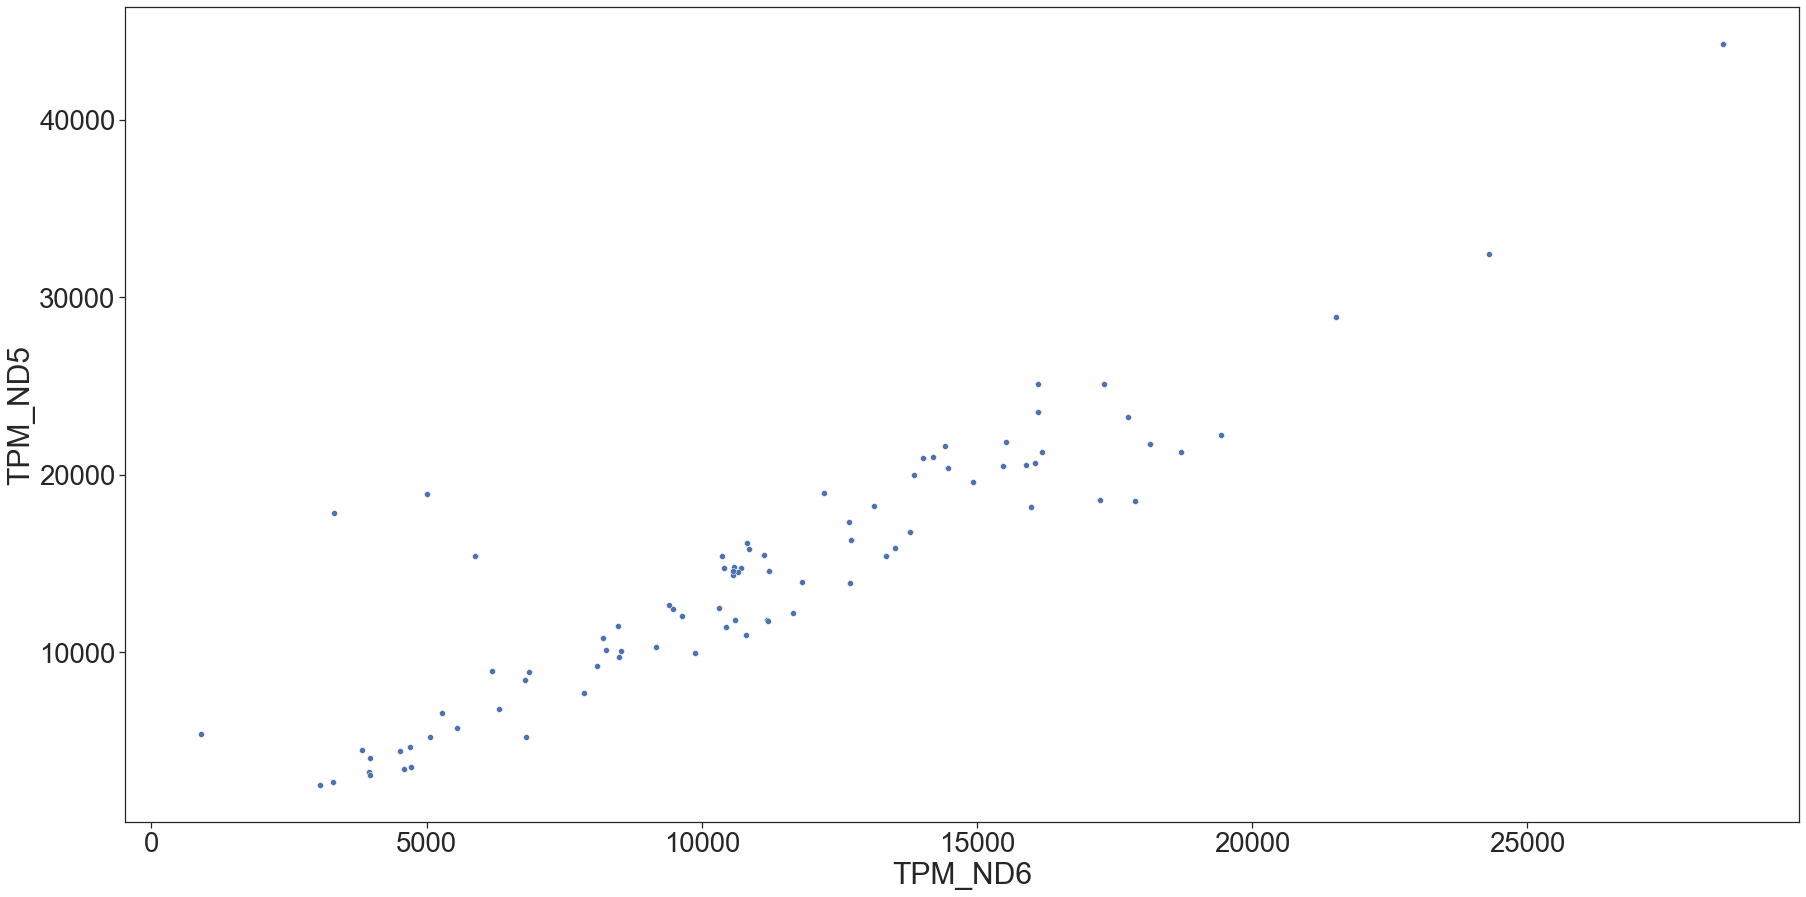

In [31]:
tissue = 'Muscle - Skeletal'
data = df_tpm_v8_ann_K2[(df_tpm_v8_ann_K2['self_rep_race'] == 'AfAm')&(df_tpm_v8_ann_K2['Tissue'] == tissue)][['short_ID','Gene','TPM']].drop_duplicates()
Y = data[data['Gene']=='ND5']#[['short_ID','TPM']]
X = data[data['Gene']=='ND6']#[['short_ID','TPM']]
data = X.merge(Y, on='short_ID',suffixes=('_ND5', '_ND6'))[['short_ID','TPM_ND5','TPM_ND6']]
data

sns.scatterplot(data=data, y='TPM_ND5',x='TPM_ND6')

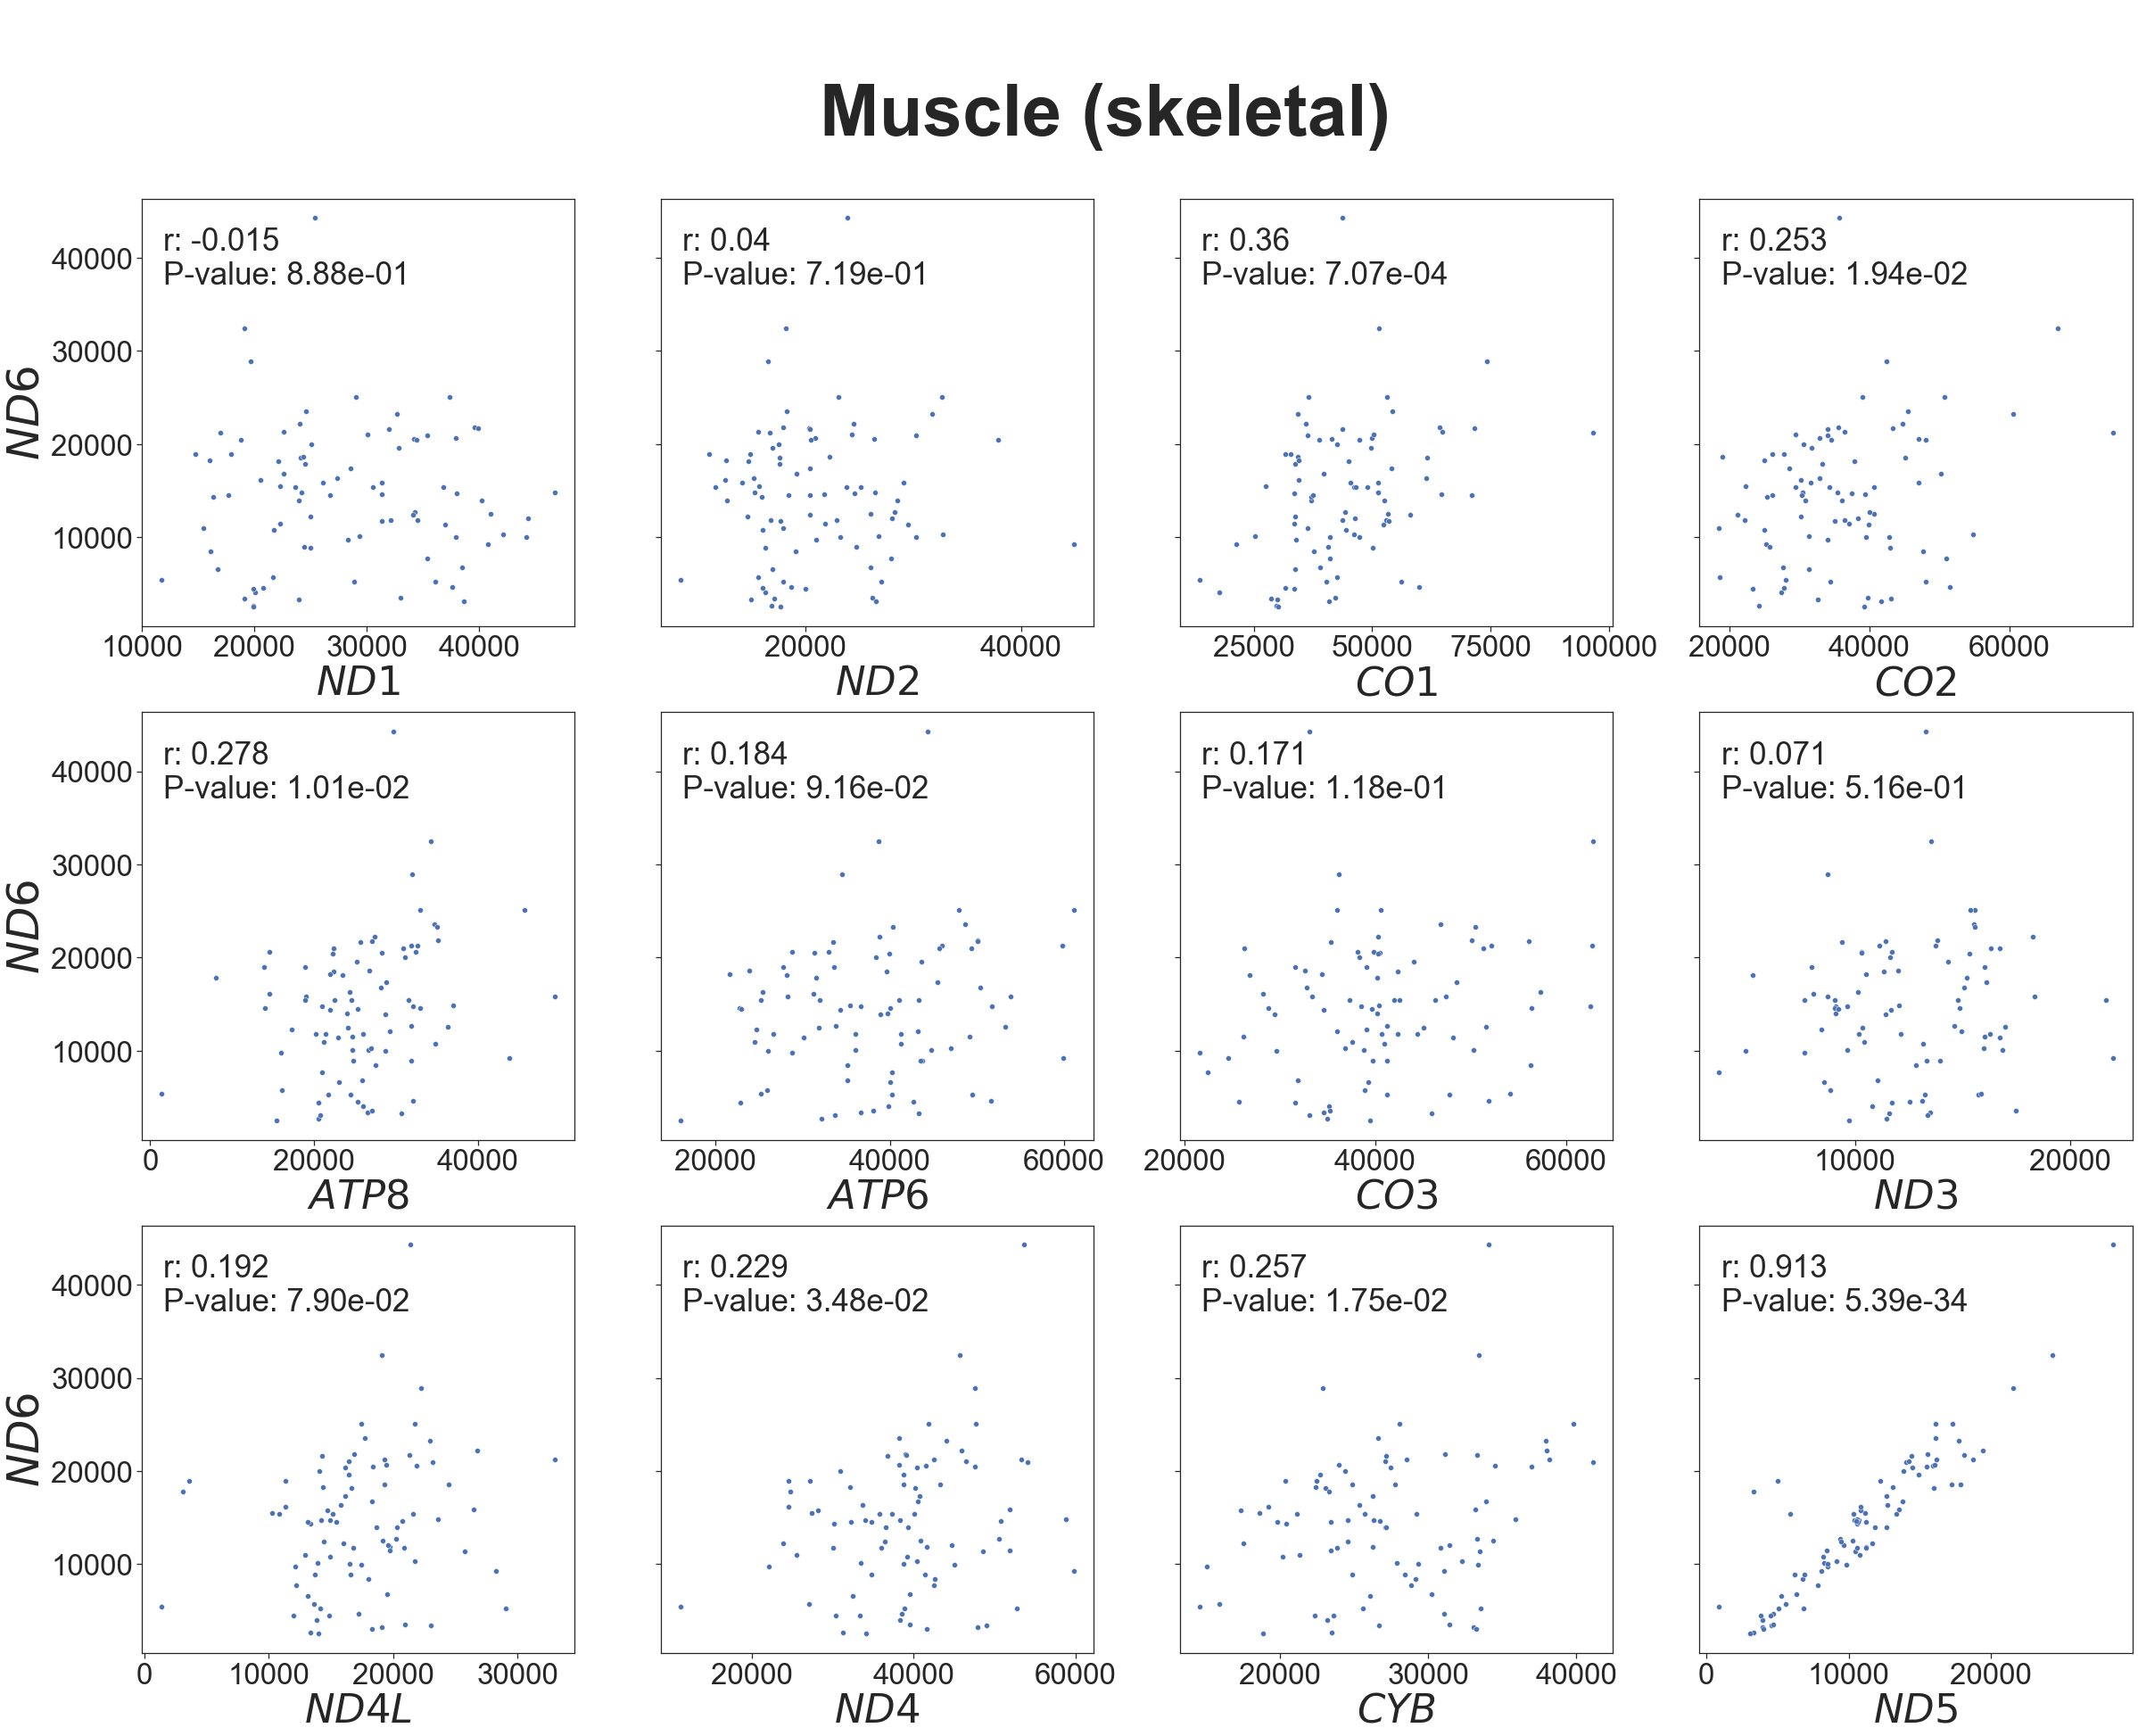

In [32]:
def scatter_anytwogenes(df,pop,tissue,gene1,gene2):
    # Seaborn parameters.
    sns.set(rc={'figure.figsize':(15,15)},font_scale=3)
    sns.set_style("ticks")
    # Input data.
    data = df[(df['self_rep_race'] == 'AfAm')&(df['Tissue'] == tissue)][['short_ID','Gene','TPM']].drop_duplicates()
    tpm_gene1 = data[data['Gene']==gene1]
    tpm_gene2 = data[data['Gene']==gene2]
    # Rejoin with Gene TPMs per column.
    data = tpm_gene1.merge(tpm_gene2, on='short_ID',suffixes=('_gene1', '_gene2'))[['short_ID','TPM_gene1','TPM_gene2']]
    # Plot scatter plot.
    sns.scatterplot(data=data, y='TPM_gene1',x='TPM_gene2')
    plt.ylabel(gene1)
    plt.xlabel(gene2)
    # Alternate tissue names for title.
    dict_altTiss = {'Esophagus - Muscularis':'Smooth muscle (esophagus)','Muscle - Skeletal':'Muscle (skeletal)','Heart - Left Ventricle':'Heart (ventricle)','Artery - Tibial':'Artery (Tibial)','Whole Blood':'Whole blood','Heart - Atrial Appendage':'Heart (atrium)','Nerve - Tibial':'Nerve (Tibial)'}
    # Get correlation values.
    cor,pval = cor_anytwogenes(data)
    plt.title( dict_altTiss[tissue]+"\nr="+str(round(cor,3))+"   pvalue="+str(pval), weight="bold")


def cor_anytwogenes(df):
    #data = df[(df['self_rep_race'] == 'AfAm')&(df['Tissue'] == tissue)][['short_ID','Gene','TPM']].drop_duplicates()
    #tpm_gene1 = data[data['Gene']==gene1]
    #tpm_gene2 = data[data['Gene']==gene2]
    #data = tpm_gene1.merge(tpm_gene2, on='short_ID',suffixes=('_gene1', '_gene2'))[['short_ID','TPM_gene1','TPM_gene2']]
    #return(data)
    data=df
    # Pearson's correlation test.
    cor,pval = stats.pearsonr(x=data['TPM_gene1'],y=data['TPM_gene2'])
    return(cor,pval)


def subplot_anytwogenes_bytissue(df,pop,list_tissue,gene1,gene2):
    # Seaborn parameters.
    sns.set(rc={'figure.figsize':(15,15)},font_scale=3)
    sns.set_style("ticks")
    # Multiple plots / Subplotting.  (https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8)
    fig, axes = plt.subplots(3,4, figsize=(40,60), sharex=False, sharey=False)
    #fig.suptitle("\n" + name +' | '+ tissue + sample_size + s_ea + s_aa +"\n", size=100)
    num_plots=6
    # Iterate through all axes.  (https://stackoverflow.com/questions/41329789/populating-seaborn-subplots-using-an-array)
    ax_order=[]
    for i in range(num_plots):
        row = i % 3
        col = i // 3
        ax_curr = axes[row, col]
        ax_order.append(ax_curr)
    # Plot results for each gene.
    for (tissue,ax_curr) in zip(list_tissue,ax_order):
        # Dataset.
        data = df[(df['self_rep_race'] == 'AfAm')&(df['Tissue'] == tissue)][['short_ID','Gene','TPM']].drop_duplicates()
        tpm_gene1 = data[data['Gene']==gene1]
        tpm_gene2 = data[data['Gene']==gene2]
        data = tpm_gene1.merge(tpm_gene2, on='short_ID',suffixes=('_gene1', '_gene2'))[['short_ID','TPM_gene1','TPM_gene2']]
        # Plot.
        sns.scatterplot(data=data, y='TPM_gene1',x='TPM_gene2', ax=ax_curr)
        ax_curr.set_ylabel(gene1, size=50)
        ax_curr.set_xlabel(gene2, size=50)
        # Get correlation values.
        cor,pval = cor_anytwogenes(data)
        # Alternate tissue names for title.
        dict_altTiss = {'Esophagus - Muscularis':'Smooth muscle (esophagus)','Muscle - Skeletal':'Muscle (skeletal)','Heart - Left Ventricle':'Heart (ventricle)','Artery - Tibial':'Artery (Tibial)','Whole Blood':'Whole blood','Heart - Atrial Appendage':'Heart (atrium)','Nerve - Tibial':'Nerve (Tibial)'}
        ax_curr.set_title( dict_altTiss[tissue]+"\nr="+str(round(cor,3))+"   pvalue="+str(pval), 
                          size=50, weight="bold" )
    # Remove labels.
    axes[0,0].set_xlabel('')
    axes[1,0].set_xlabel('')
    axes[0,1].set_xlabel('')
    axes[0,1].set_ylabel('')
    axes[1,1].set_xlabel('')
    axes[1,1].set_ylabel('')
    axes[2,1].set_ylabel('')
    # Set only one x and y label for the entire plot.
    #axes[1,0].set_ylabel("             Normalized gene expression (TPM)\n", size=70) 
    #axes[2,0].set_xlabel("\n                                                   Genes", size=70) 


def subplot_anytwogenes_bygenes(df,pop,list_mtdna,gene1):
    # Seaborn parameters.
    sns.set(rc={'figure.figsize':(15,15)},font_scale=3)
    sns.set_style("ticks")
    # Alternate tissue names for title.
    dict_altTiss = {'Esophagus - Muscularis':'Smooth muscle (esophagus)','Muscle - Skeletal':'Muscle (skeletal)','Heart - Left Ventricle':'Heart (ventricle)','Artery - Tibial':'Artery (Tibial)','Whole Blood':'Whole blood','Heart - Atrial Appendage':'Heart (atrium)','Nerve - Tibial':'Nerve (Tibial)'}
    # Multiple plots / Subplotting.  (https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8)
    fig, axes = plt.subplots(3,4, figsize=(40,30), sharex=False, sharey=True)
    fig.suptitle("\n"+dict_altTiss[tissue], size=80, weight="bold")
    #fig.suptitle("\n" + name +' | '+ tissue + sample_size + s_ea + s_aa +"\n", size=100)
    num_plots=6
    # Iterate through all axes.  (https://stackoverflow.com/questions/41329789/populating-seaborn-subplots-using-an-array)
    ax_order = [axes[0, 0], axes[0, 1], axes[0, 2], axes[0, 3], axes[1, 0], axes[1, 1], axes[1, 2], axes[1, 3], axes[2, 0], axes[2, 1], axes[2, 2], axes[2, 3]]
    # Exclude gene1 from list of genes.
    list_genes = []
    for gene in list_mtdna:
        if gene != gene1:
            list_genes.append(gene)
    # Plot results for each gene.
    for (gene2,ax_curr) in zip(list_genes,ax_order):
        # Dataset.
        data = df[(df['self_rep_race'] == 'AfAm')&(df['Tissue'] == tissue)][['short_ID','Gene','TPM']].drop_duplicates()
        tpm_gene1 = data[data['Gene']==gene1]
        tpm_gene2 = data[data['Gene']==gene2]
        data = tpm_gene1.merge(tpm_gene2, on='short_ID',suffixes=('_gene1', '_gene2'))[['short_ID','TPM_gene1','TPM_gene2']]
        # Plot.
        sns.scatterplot(data=data, y='TPM_gene1',x='TPM_gene2', ax=ax_curr)
        ax_curr.set_ylabel('$\it{'+gene1+'}$', size=50)
        ax_curr.set_xlabel('$\it{'+gene2+'}$', size=45)
        #ax_curr.set_title(gene2, size=50)
        # Get correlation values.
        cor,pval = cor_anytwogenes(data)
        #ax_curr.set_title( "\nr="+str(round(cor,3))+"   pvalue="+str(pval), size=20, weight="bold" )
        # Write the regression values inside each subplot.
        ax_curr.text(0.05,0.8,"r: "+str(round(cor,3))+"\nP-value: "+str("{:.2e}".format(float(pval))), 
                     size=35 ,transform=ax_curr.transAxes)


#scatter_anytwogenes(df_tpm_v8_ann_K2,'AfAm','Muscle - Skeletal', 'ND5','ND6')
#subplot_anytwogenes_bytissue(df_tpm_v8_ann_K2,'AfAm',list_tissue[1:], 'ND6','ND5')
subplot_anytwogenes_bygenes(df_tpm_v8_ann_K2,'AfAm',list_mtdna, 'ND6')

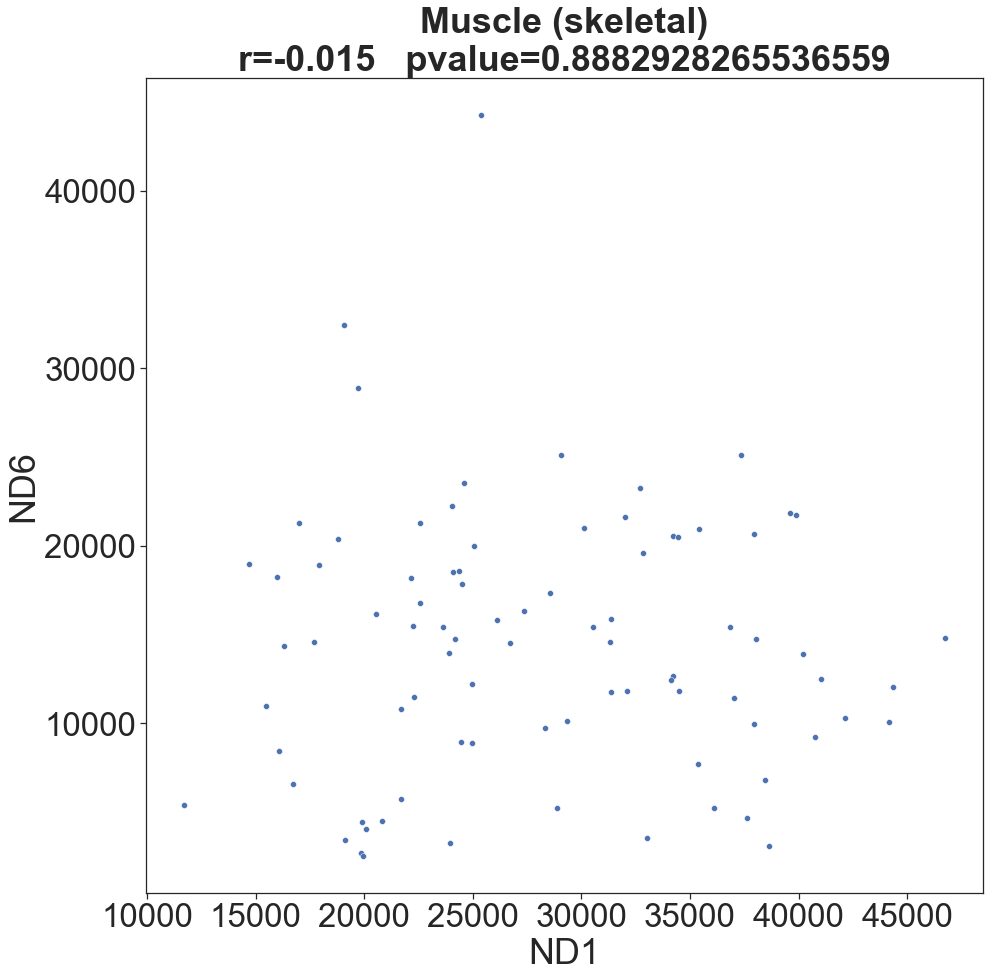

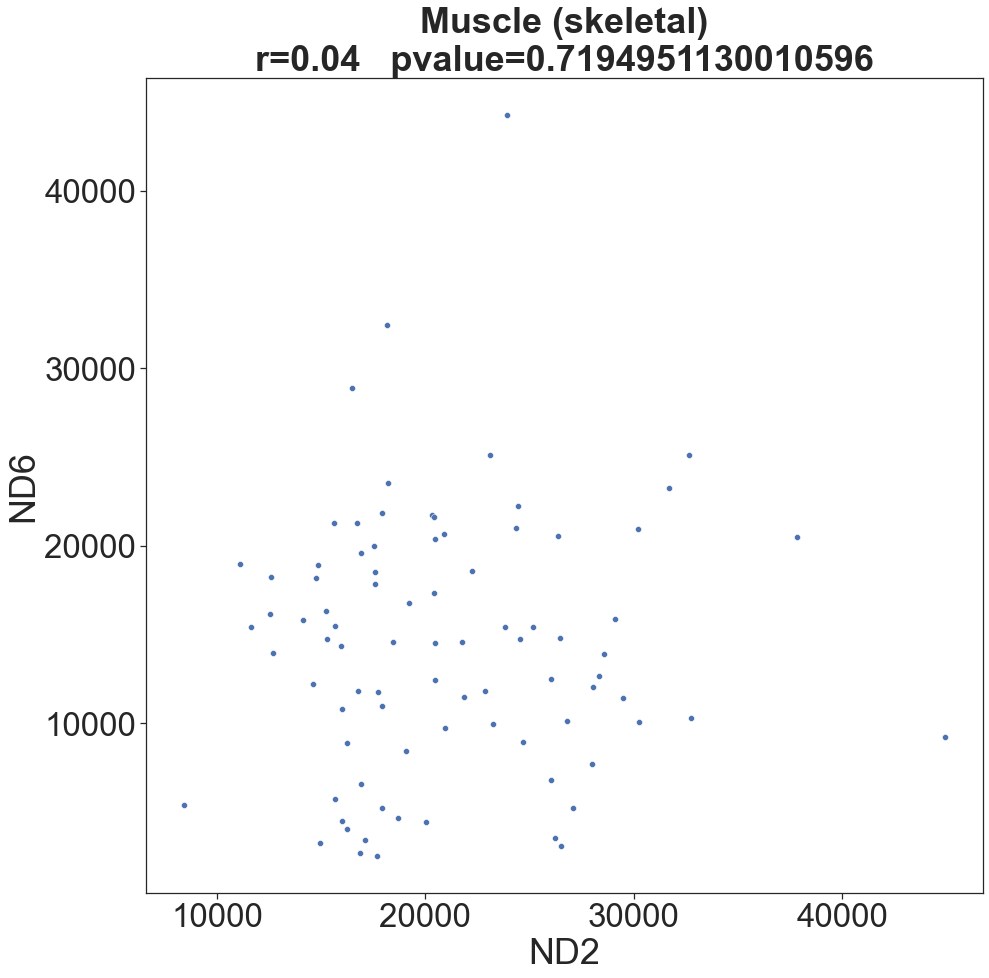

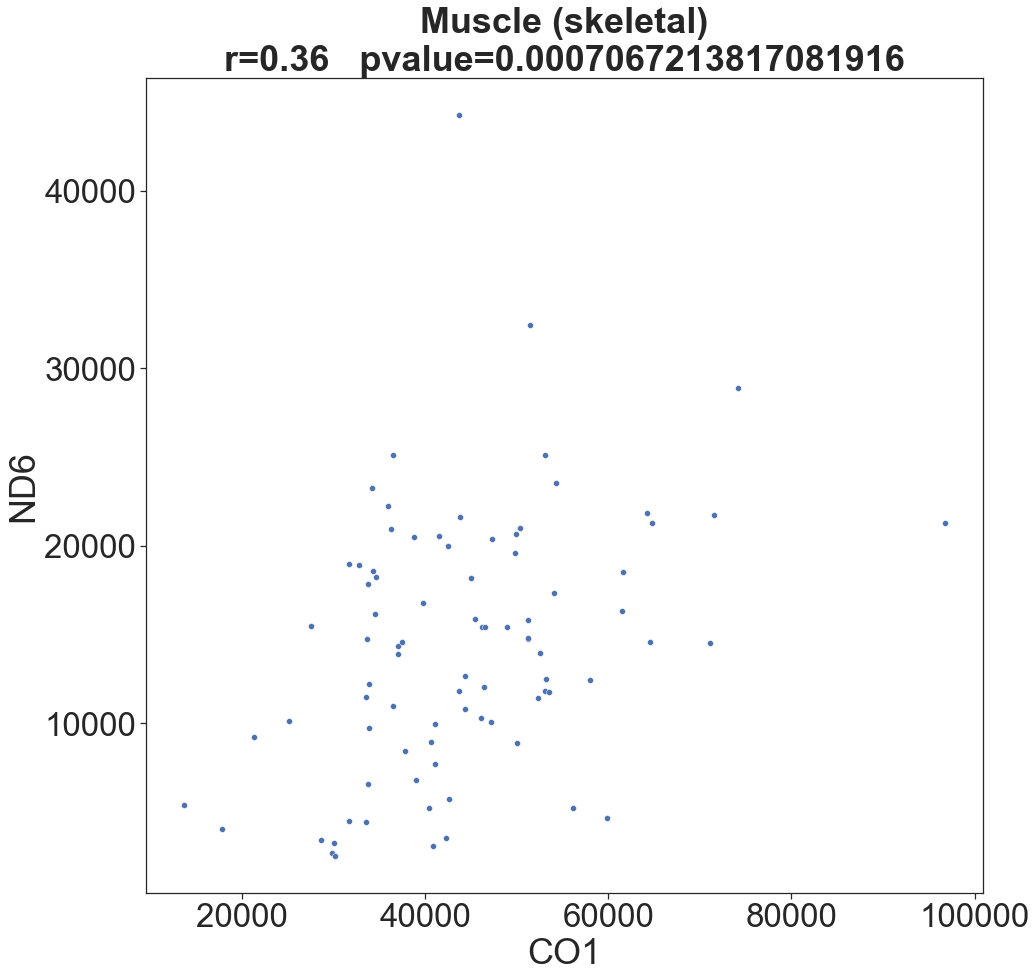

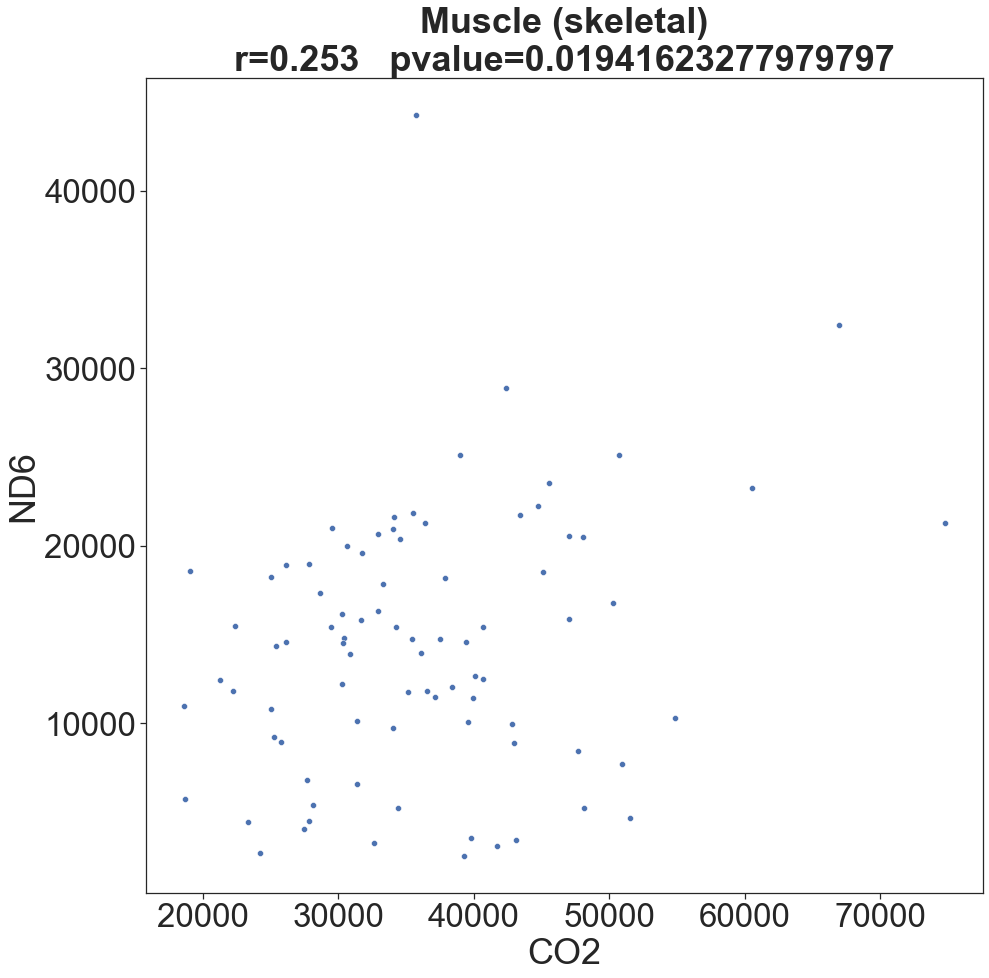

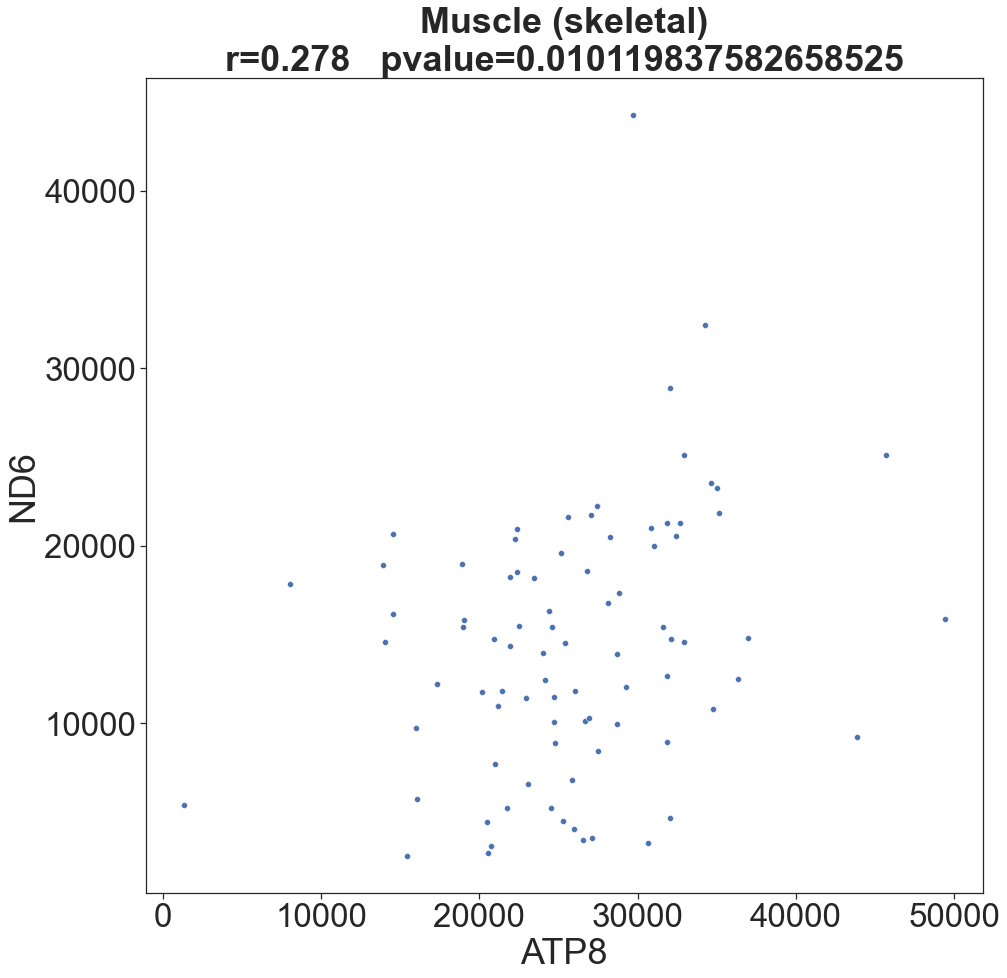

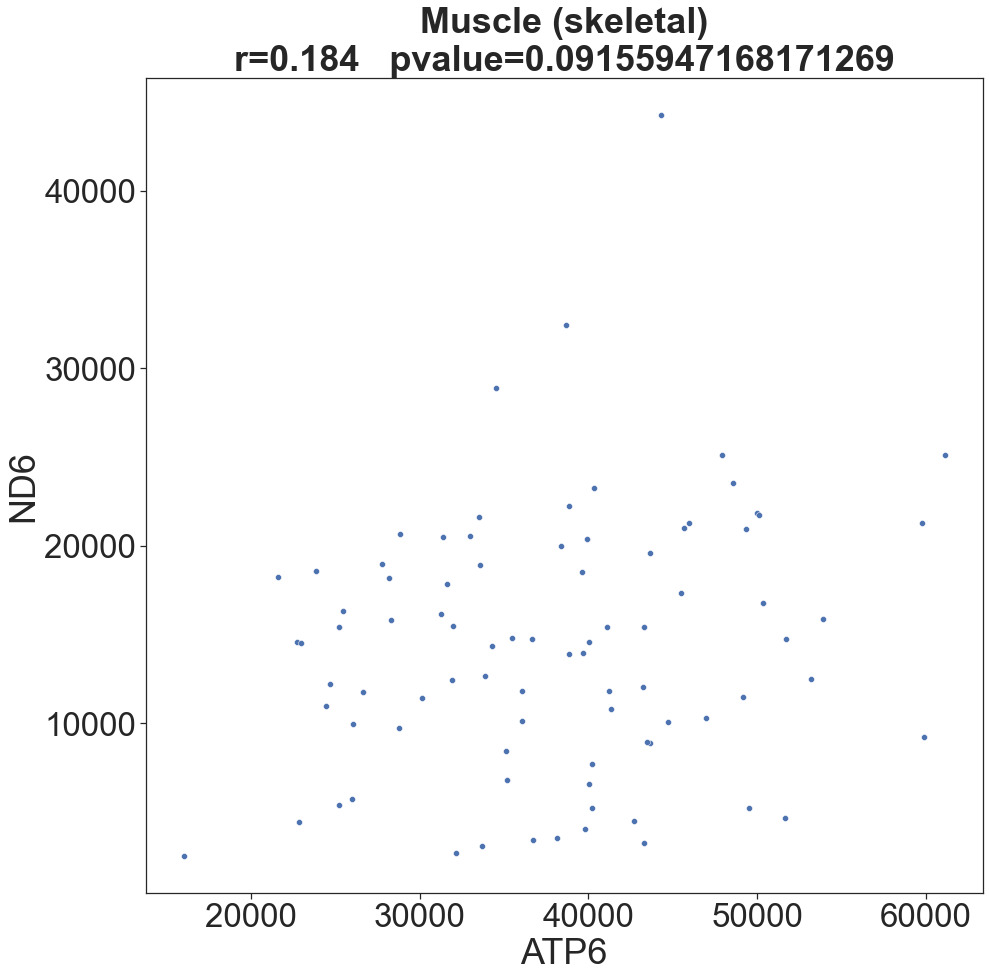

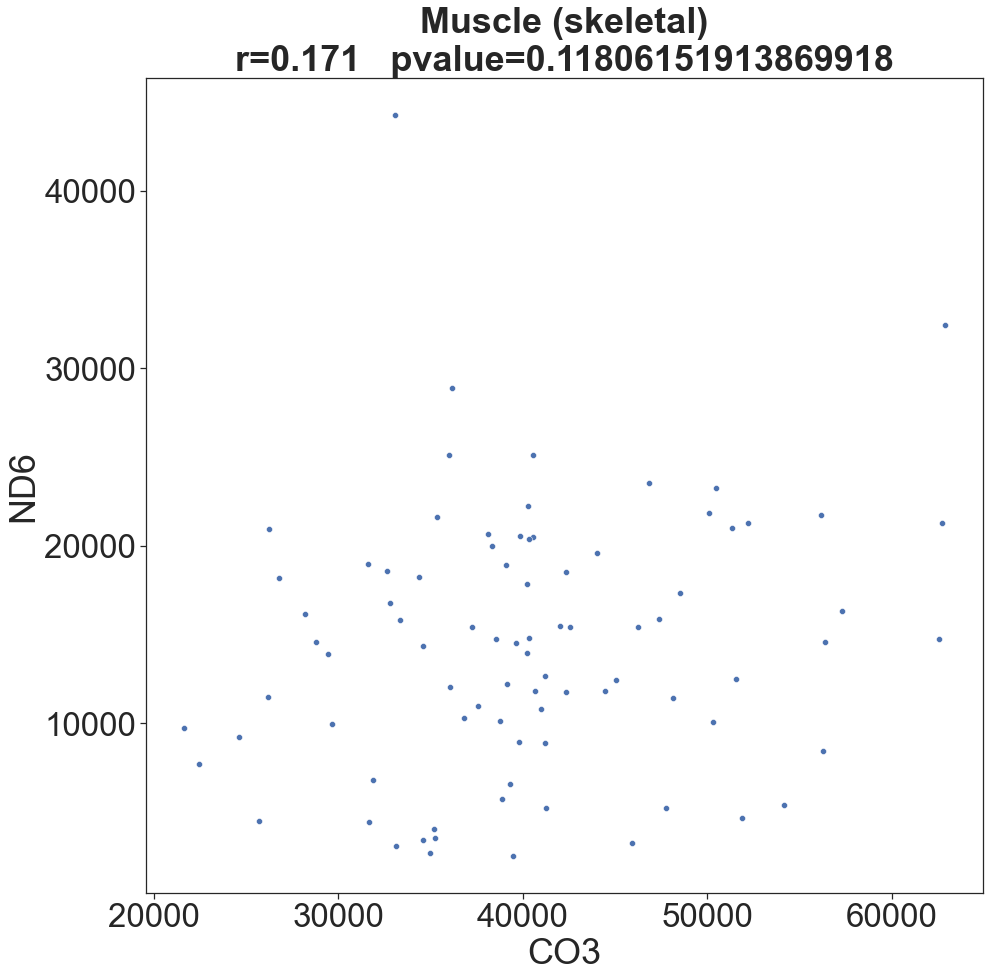

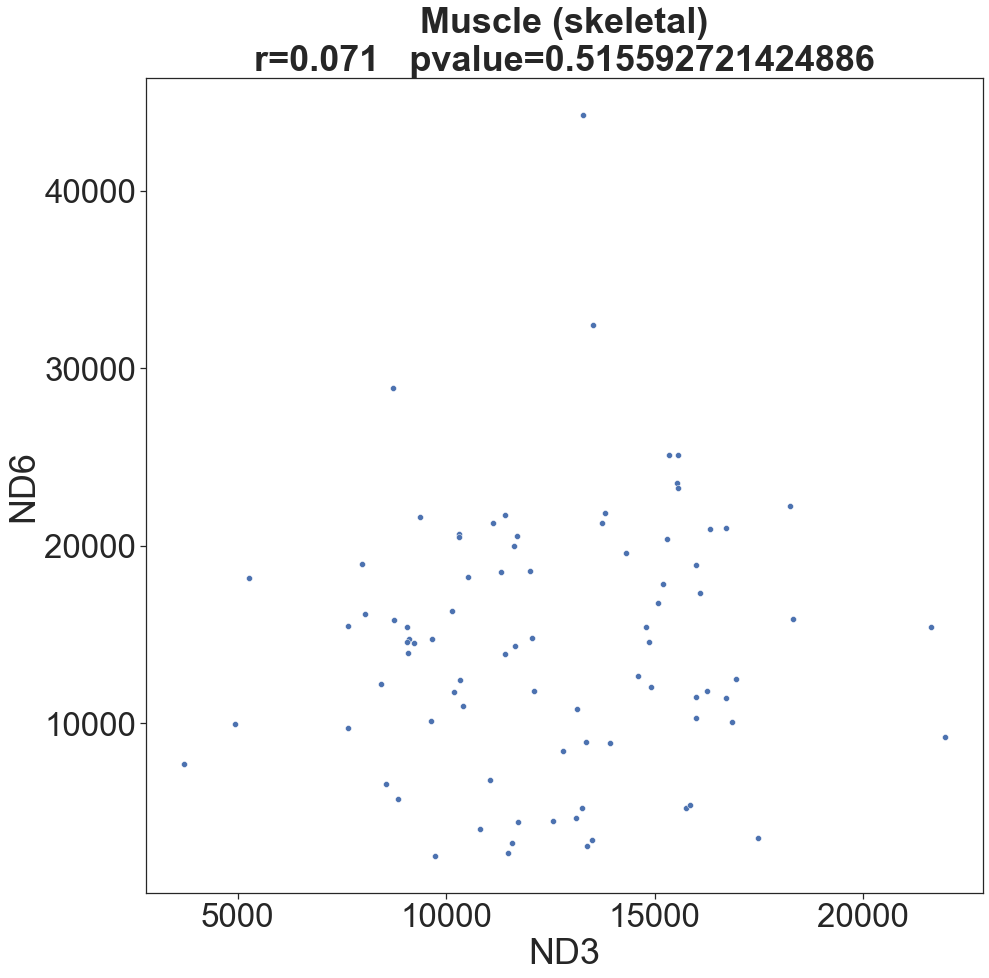

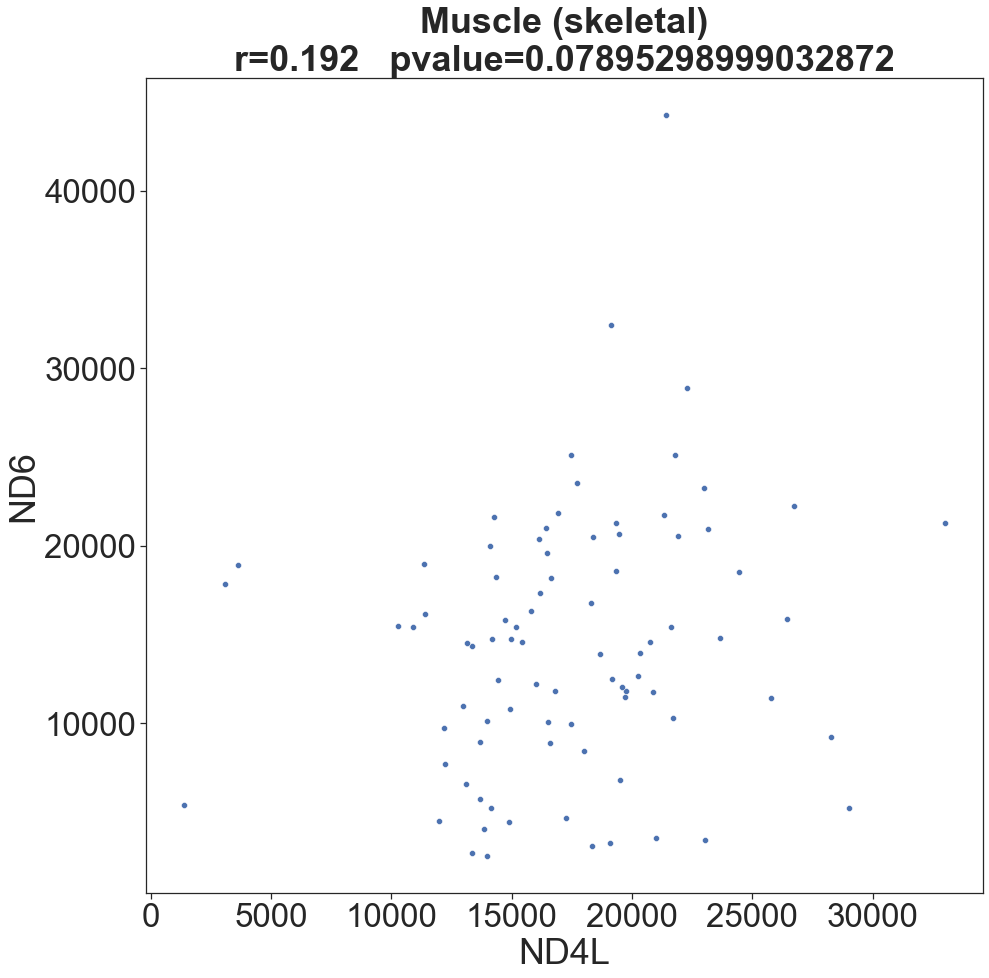

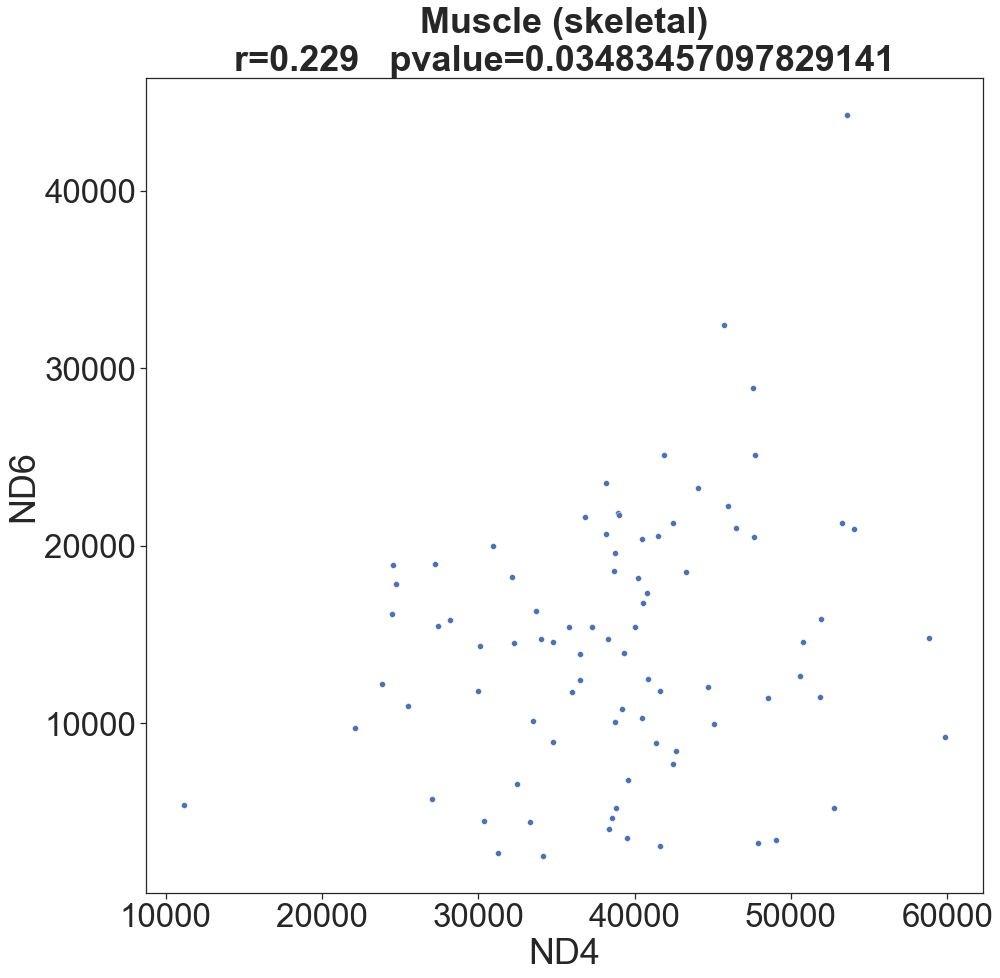

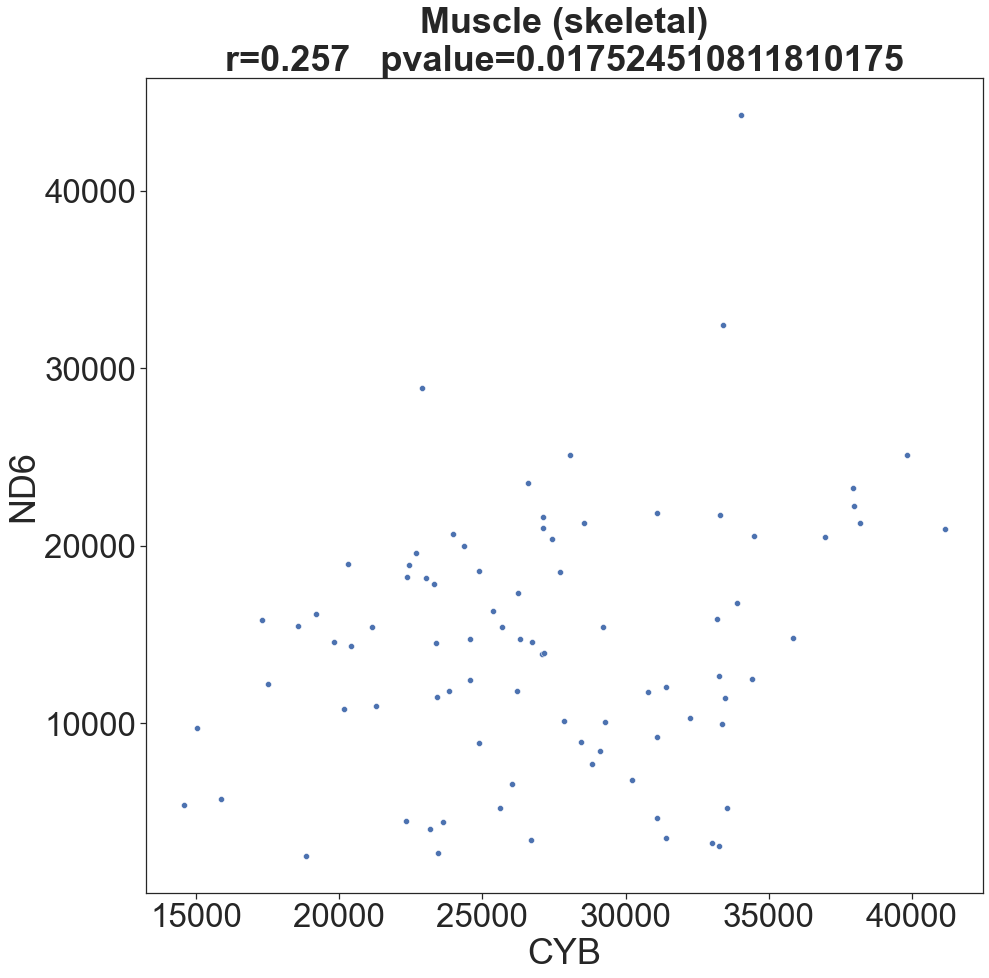

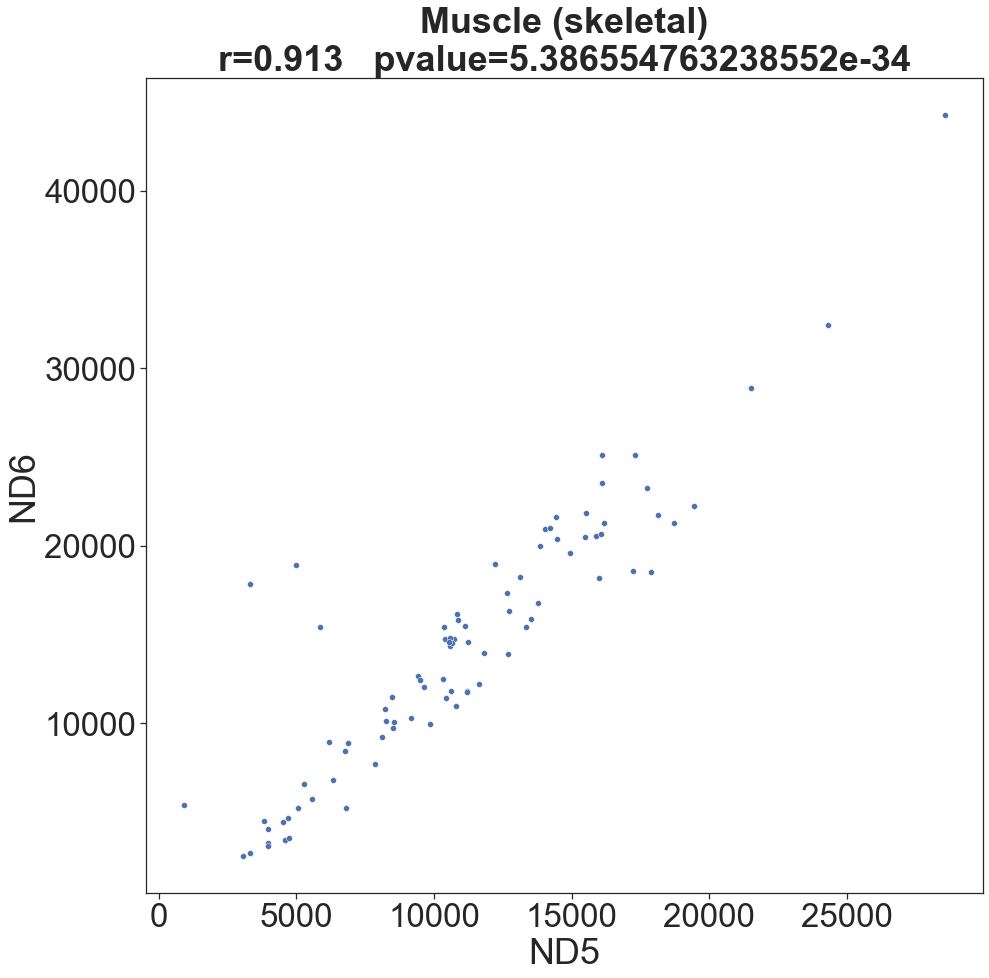

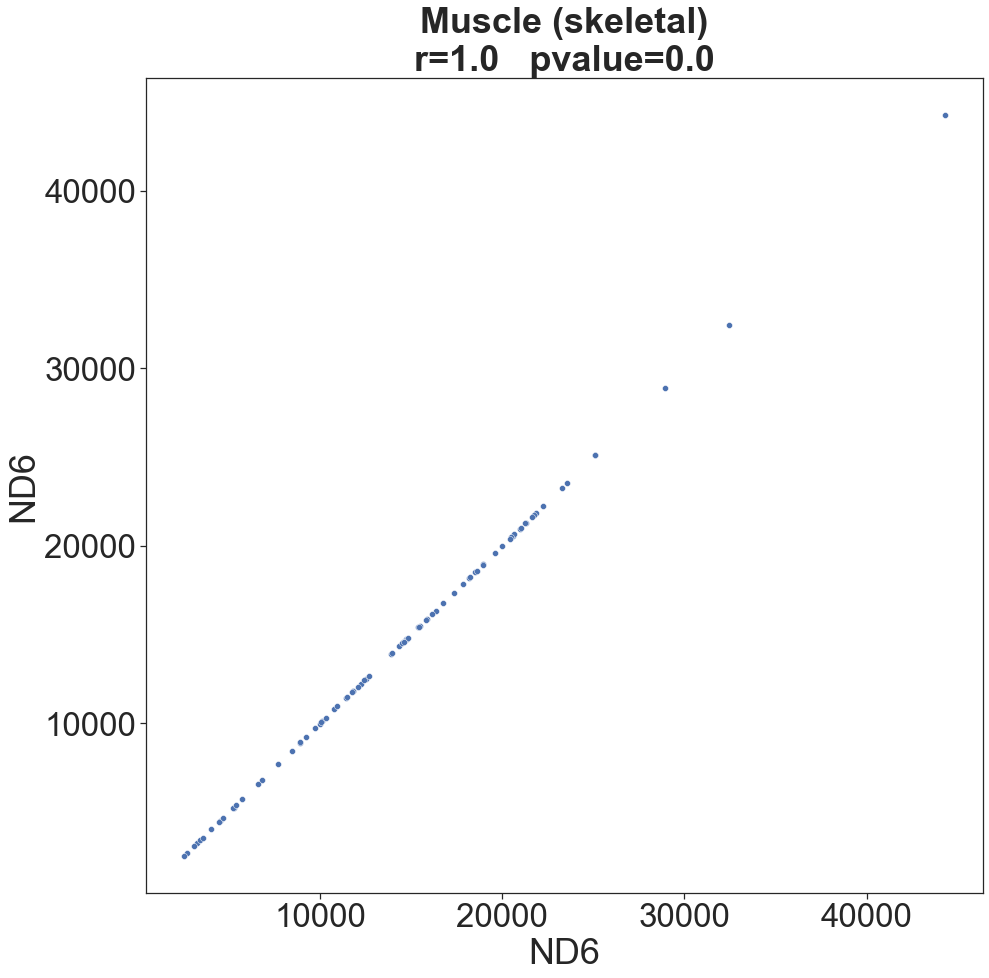

In [33]:
#fig,axes = plt.subplots(3,2, figsize=(40,60), sharex=False, sharey=False)
for gene in list_mtdna:
    scatter_anytwogenes(df_tpm_v8_ann_K2,'AfAm','Muscle - Skeletal', 'ND6', gene)
    plt.show()

## Simple linear regression (assumes normal distributions)

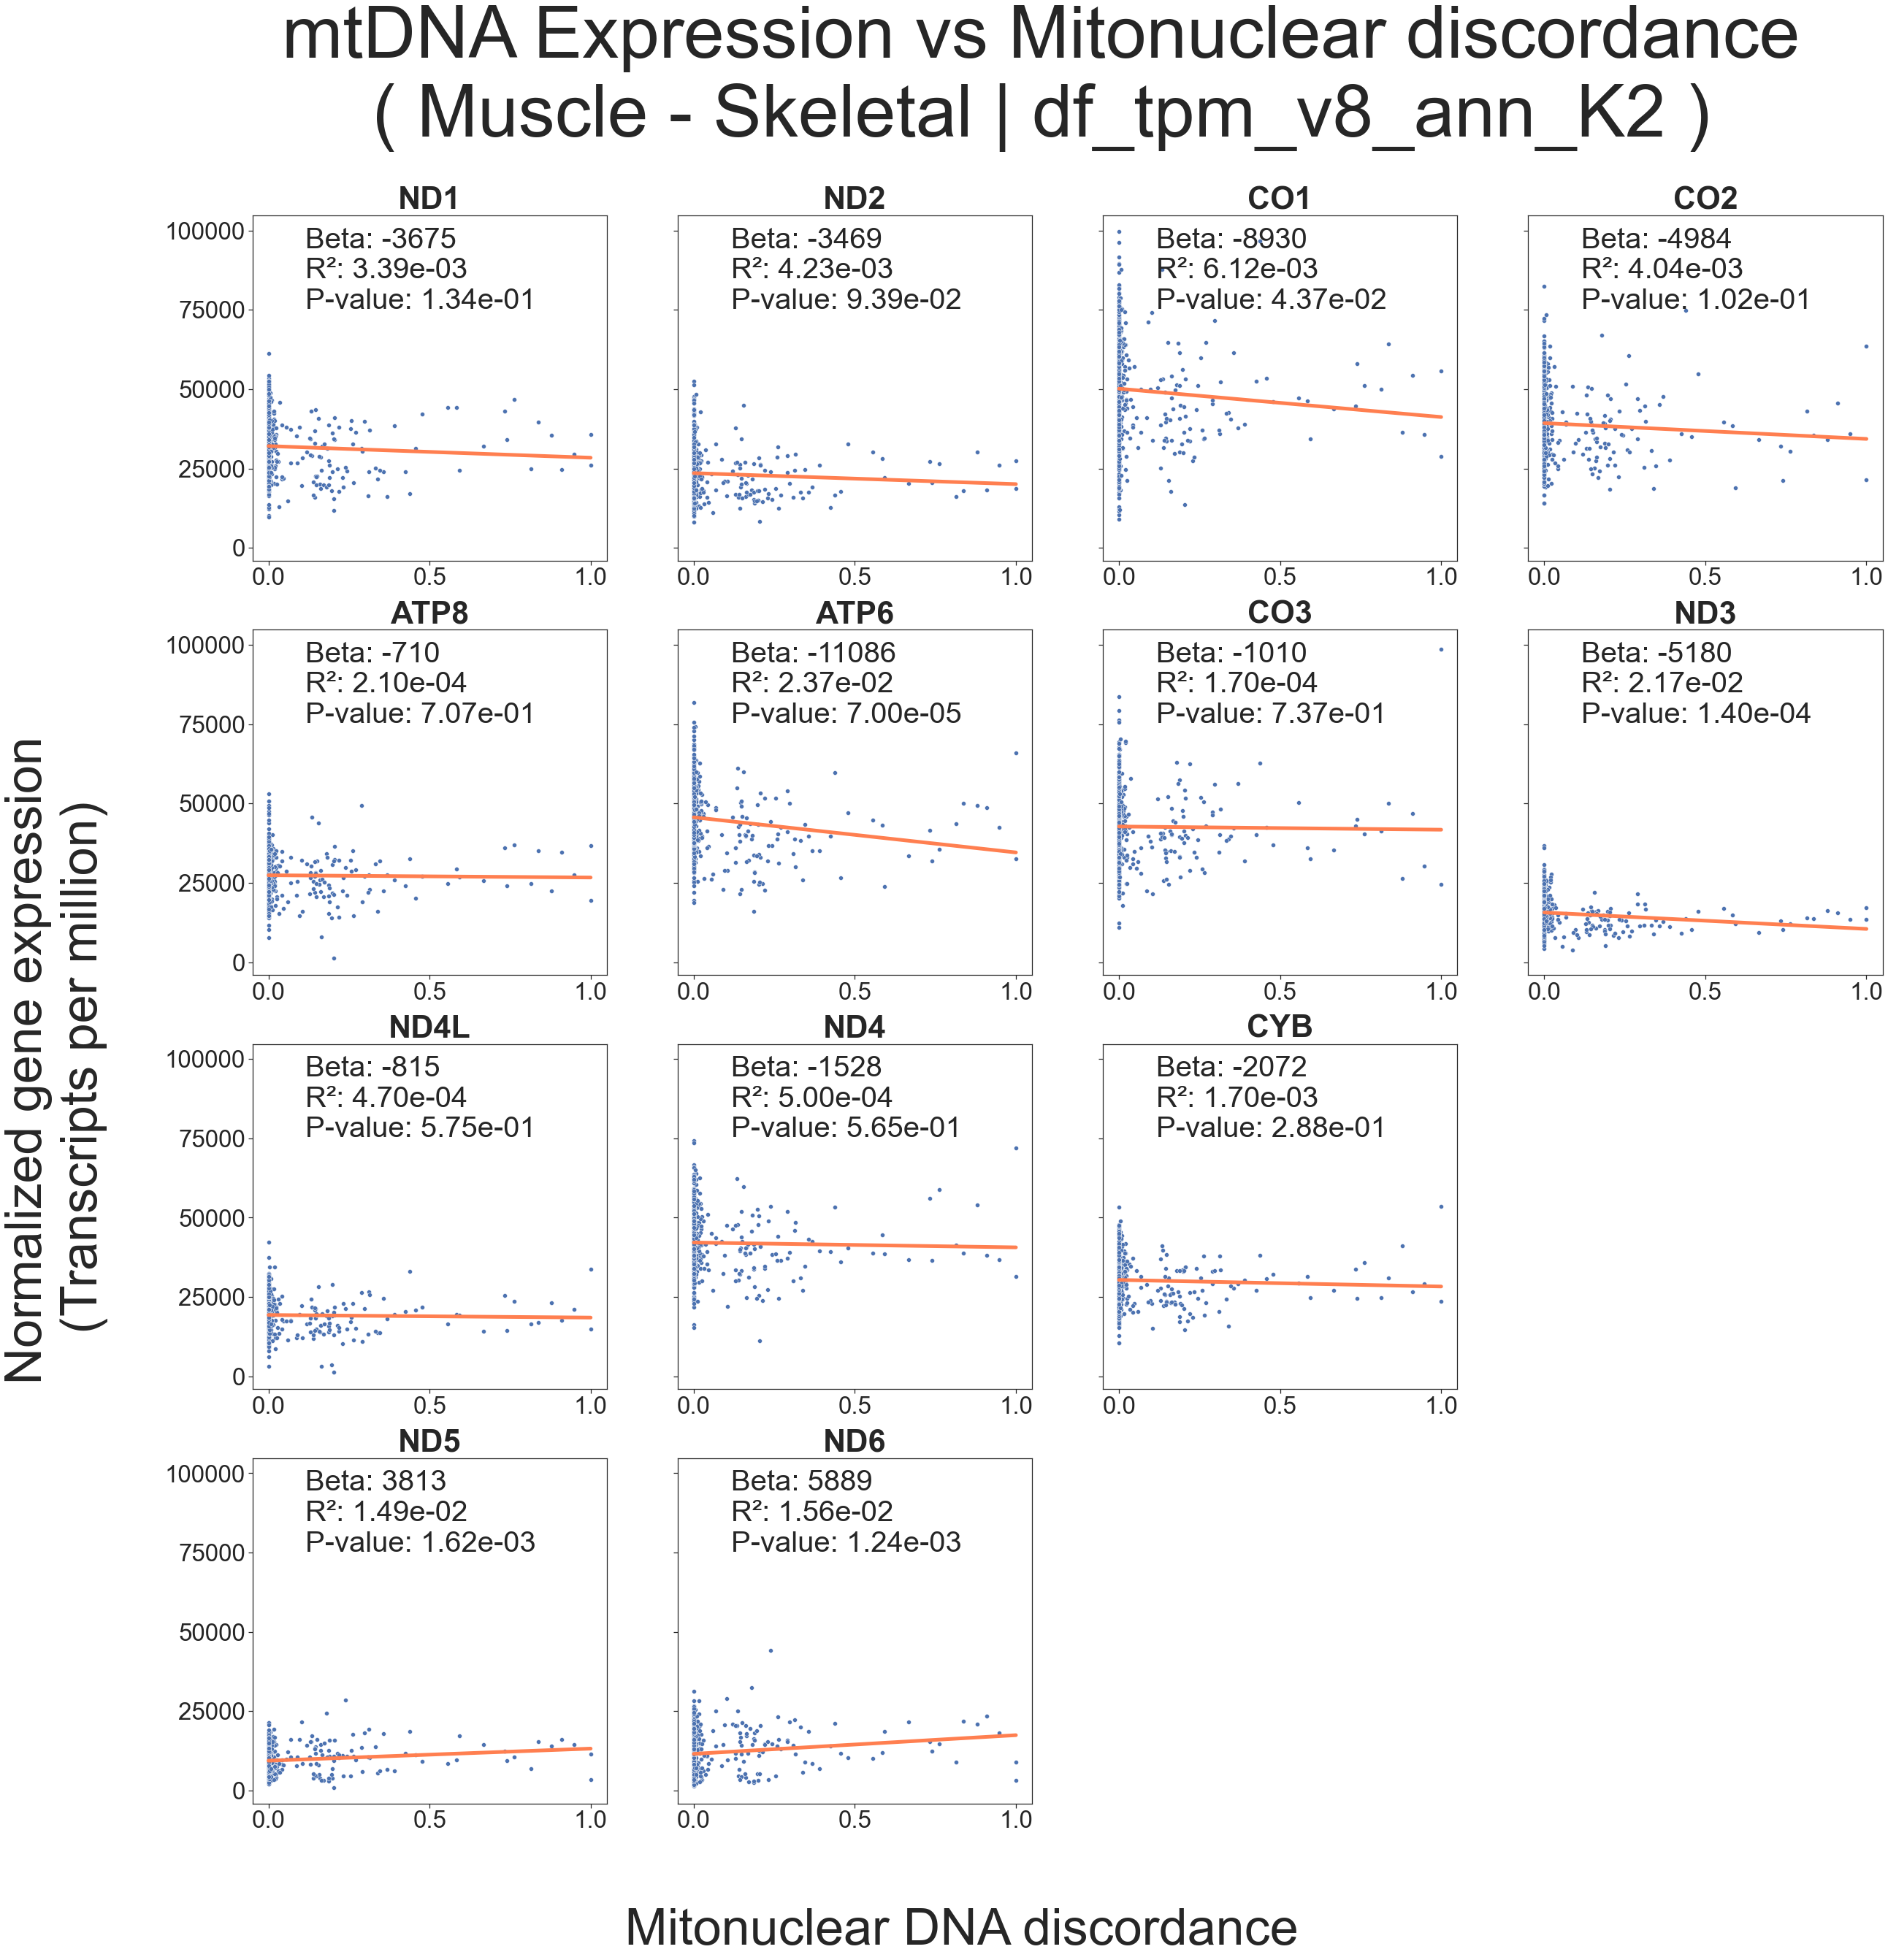

In [34]:
def plot_expr_mnd(df,tissue,gene):
    data = df[(df['Tissue']==tissue)&(df['Gene']==gene)]
    # Seaborn parameters.
    sns.set(rc={'figure.figsize':(6,5)},font_scale=1.7)
    sns.set_style("ticks")
    sns.scatterplot(data=data, y='TPM',x='mitonucl_discord')
    #sns.regplot(data=data, y='TPM',x='mitonucl_discord')
    plt.title(tissue+' | '+gene+' | '+df.name)
    plt.xlabel("Mitonuclear discordance")
    plt.show()
    
    
def subplot_expr_mnd(df,tissue):
    # Multiple plots / Subplotting.  (https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8)
    fig, axes = plt.subplots(4,4, figsize=(40,40), sharex=False, sharey=True)
    fig.suptitle('mtDNA Expression vs Mitonuclear discordance\n( '+tissue+' | '+df.name+' )', size=100)
    num_plots=13
    # Iterate through all axes.  (https://stackoverflow.com/questions/41329789/populating-seaborn-subplots-using-an-array)
    ax_order=[]
    #for i in range(num_plots):
    #    row = i // 4
    #    col = i % 4
    #    ax_curr = axes[row, col]
    #    ax_order.append(ax_curr)
    ax_order = [axes[0, 0], axes[0, 1], axes[0, 2], axes[0, 3], axes[1, 0], axes[1, 1], axes[1, 2], axes[1, 3], axes[2, 0], axes[2, 1], axes[2, 2], axes[3, 0], axes[3, 1]]
    # Plot results for each gene.
    for ( gene , ax_curr ) in zip( list_mtdna , ax_order ):  #(https://stackoverflow.com/questions/1663807/how-to-iterate-through-two-lists-in-parallel)
        # Filter data.
        data = df[(df['Tissue']==tissue)&(df['Gene']==gene)]
        # Regression values.
        result, beta, rsquared, pvalue = reg_values(data,tissue,gene)
        # Seaborn parameters.
        sns.set(rc={'figure.figsize':(20,20)},font_scale=3.6)
        sns.set_style("ticks")
        # Choose plot.
        ###sns.regplot(data=data, y='TPM',x='mitonucl_discord', ax=ax_curr)
        
        # Plot datapoints.
        sns.scatterplot(data=data, x='mitonucl_discord', y='TPM', ax=ax_curr )
        # Add regression line.
        x = np.linspace(0,1,100)
        y = result.slope*x + result.intercept
        ax_curr.plot(x,y,linewidth=5,color='coral')
        
        ax_curr.set_title(gene, weight='bold')
        #ax_curr.set_ylabel("Normalized gene expression (TPM)")
        #ax_curr.set_xlabel("Mitonuclear discordance")
        ax_curr.set_ylabel("")
        ax_curr.set_xlabel("")
        # Write the regression values inside each subplot.
        ax_curr.text(0.15,0.73,"Beta: "+str(round(float(beta)))+"\nR²: "+str("{:.2e}".format(float(rsquared)))+"\nP-value: "+str("{:.2e}".format(float(pvalue))), 
                     size=40 ,transform=ax_curr.transAxes)
    # Set only one x and y label for the entire plot.
    axes[2,0].set_ylabel("                       Normalized gene expression \n                     (Transcripts per million)\n", size=70)
    axes[2,1].set_xlabel("\n\n\n\n\n\n\n\n\n               Mitonuclear DNA discordance", size=70)
    # Remove subplots.
    axes[3,3].axis("off")
    axes[3,2].axis("off")
    axes[2,3].axis("off")
    
       
def reg_values(df,tissue,gene):
    data = df[(df['Tissue']==tissue)&(df['Gene']==gene)][['TPM','mitonucl_discord']]
    TPM = data['TPM']
    MND = data['mitonucl_discord']
    # Get regression values (coefficients of linear fit) using SciPy.
    result = stats.linregress( y=TPM , x=MND )
    #return(result)
    beta = str(round(result.slope,5))
    rsquared = str(round(result.rvalue**2,5))
    pvalue = str(round(result.pvalue,5))
    return(result, beta, rsquared, pvalue)


def table_reg_values(df,list_tissue):
    out = []
    for tissue in list_tissue:
        for gene in list_mtdna:
            results, beta, rsquared, pvalue = reg_values(df,tissue,gene)
            out.append([tissue,gene,beta,rsquared,pvalue])
    return( pd.DataFrame(out, columns=['Tissue','Gene','Beta','R-squared','P-value']) )

    
def plot_reg_values(df,tissue,gene,ax):
    # Regression values.
    result,beta,rsquared,pvalue = reg_values(df,tissue,gene)
    # Plot datapoints.
    data = df[(df['Tissue']==tissue)&(df['Gene']==gene)]
    sns.scatterplot(data=data, x='mitonucl_discord', y='TPM')
    # Add regression line.
    x = np.linspace(0,1,100)
    y = result.slope*x + result.intercept
    plt.plot(x,y,linewidth=5,color='coral')
    

#plot_expr_mnd(df_tpm_v8_ann_K2,'Muscle - Skeletal', 'ND1')
subplot_expr_mnd(df_tpm_v8_ann_K2,'Muscle - Skeletal')
#reg_values(df_tpm_v8_ann_K2,'Muscle - Skeletal','ND1')
#table_reg_values(df_tpm_v8_ann_K2,['Muscle - Skeletal','Heart - Left Ventricle','Heart - Atrial Appendage'])
#plot_reg_values(df_tpm_v8_ann_K2,'Muscle - Skeletal','ND1','d')

[None, None, None, None, None, None]

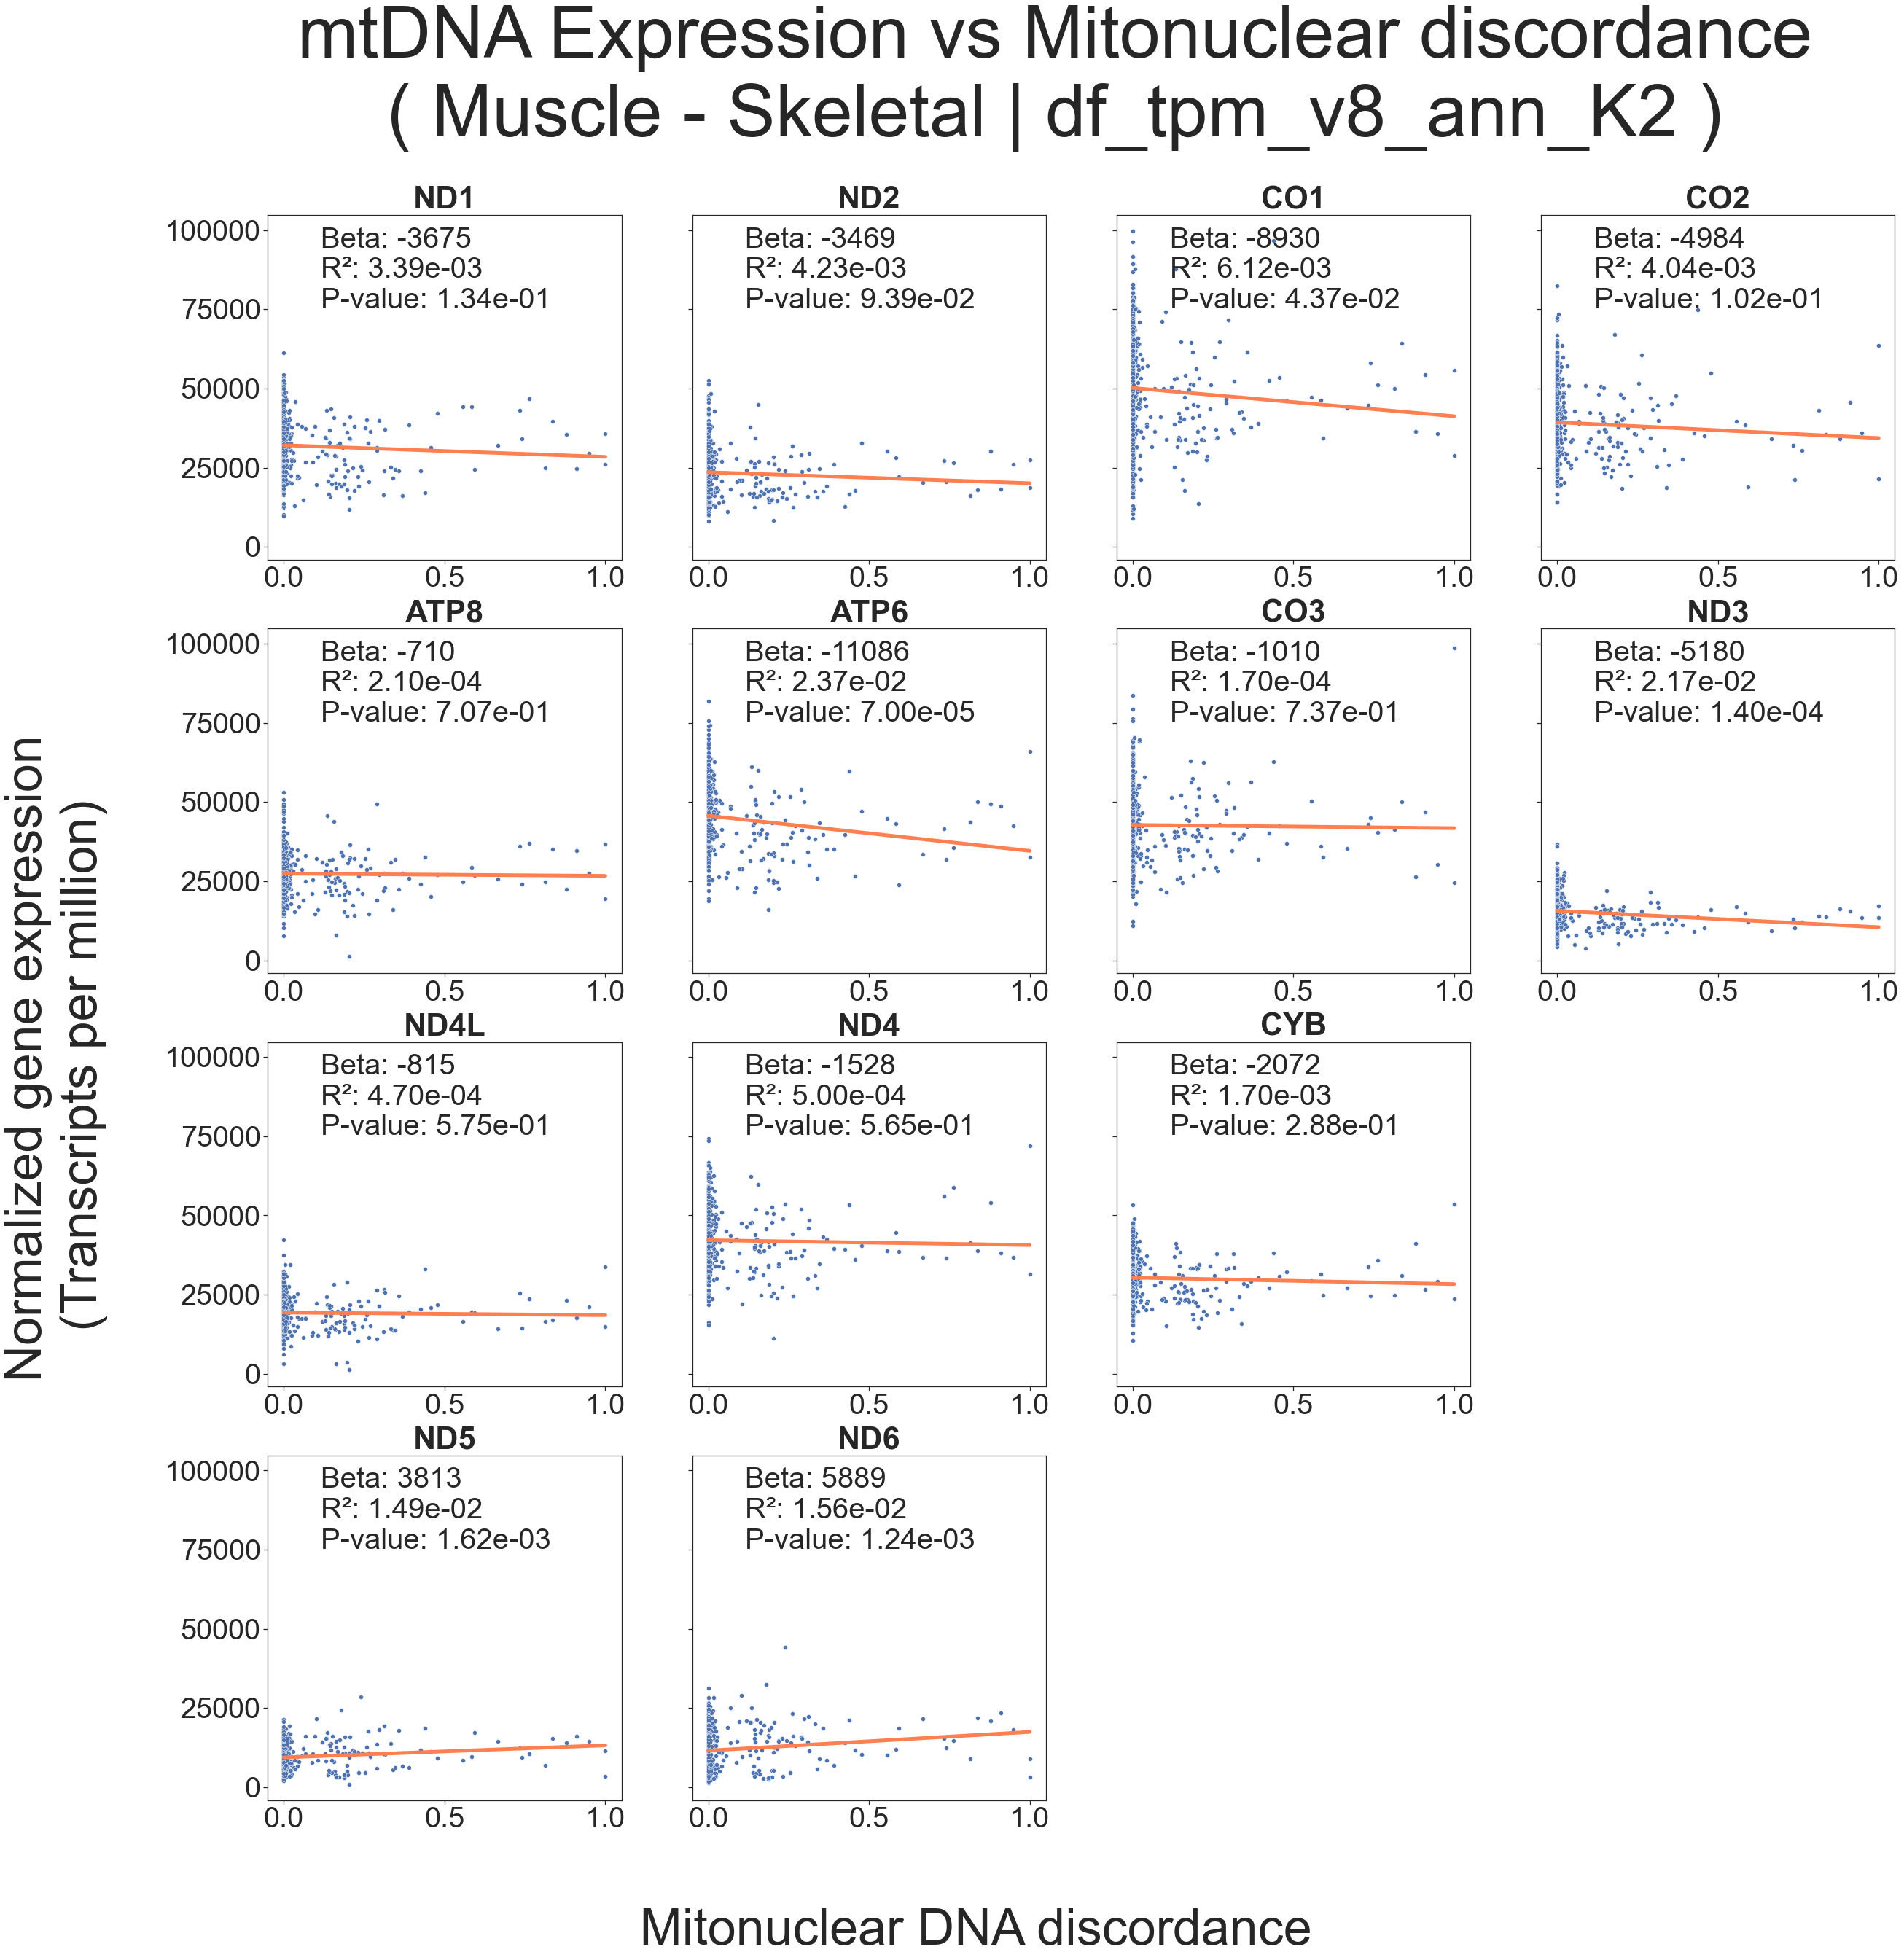

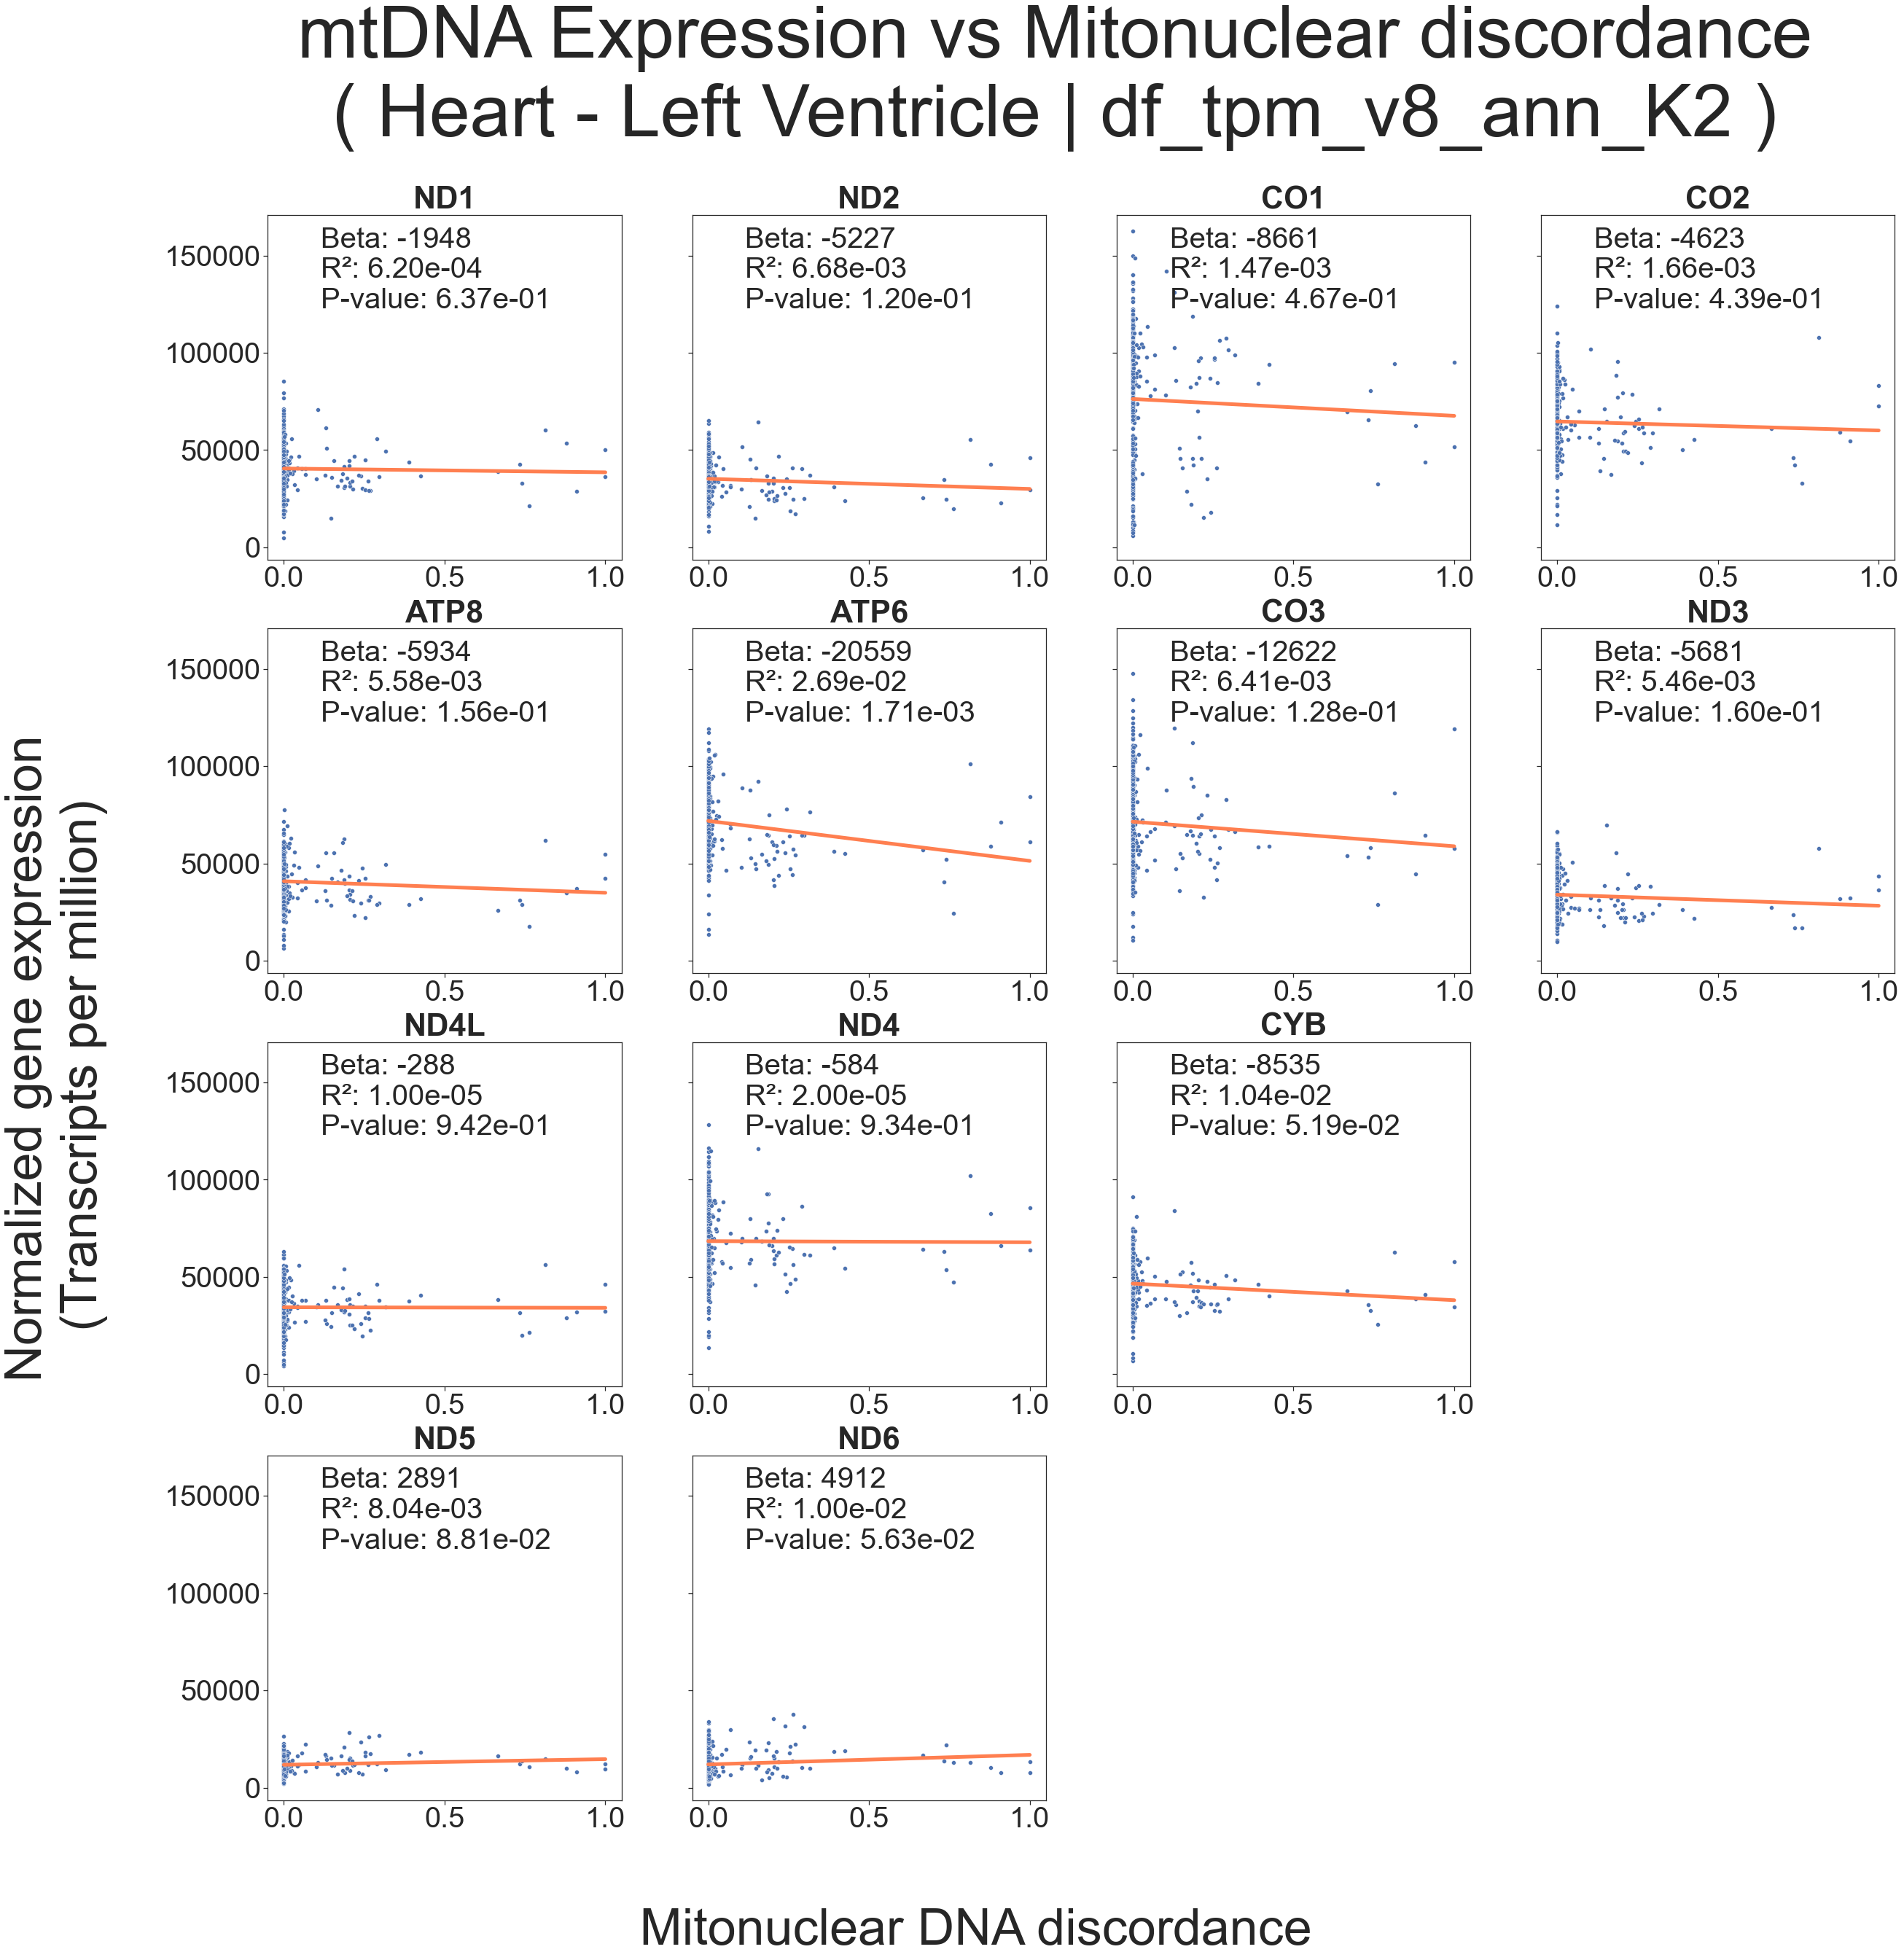

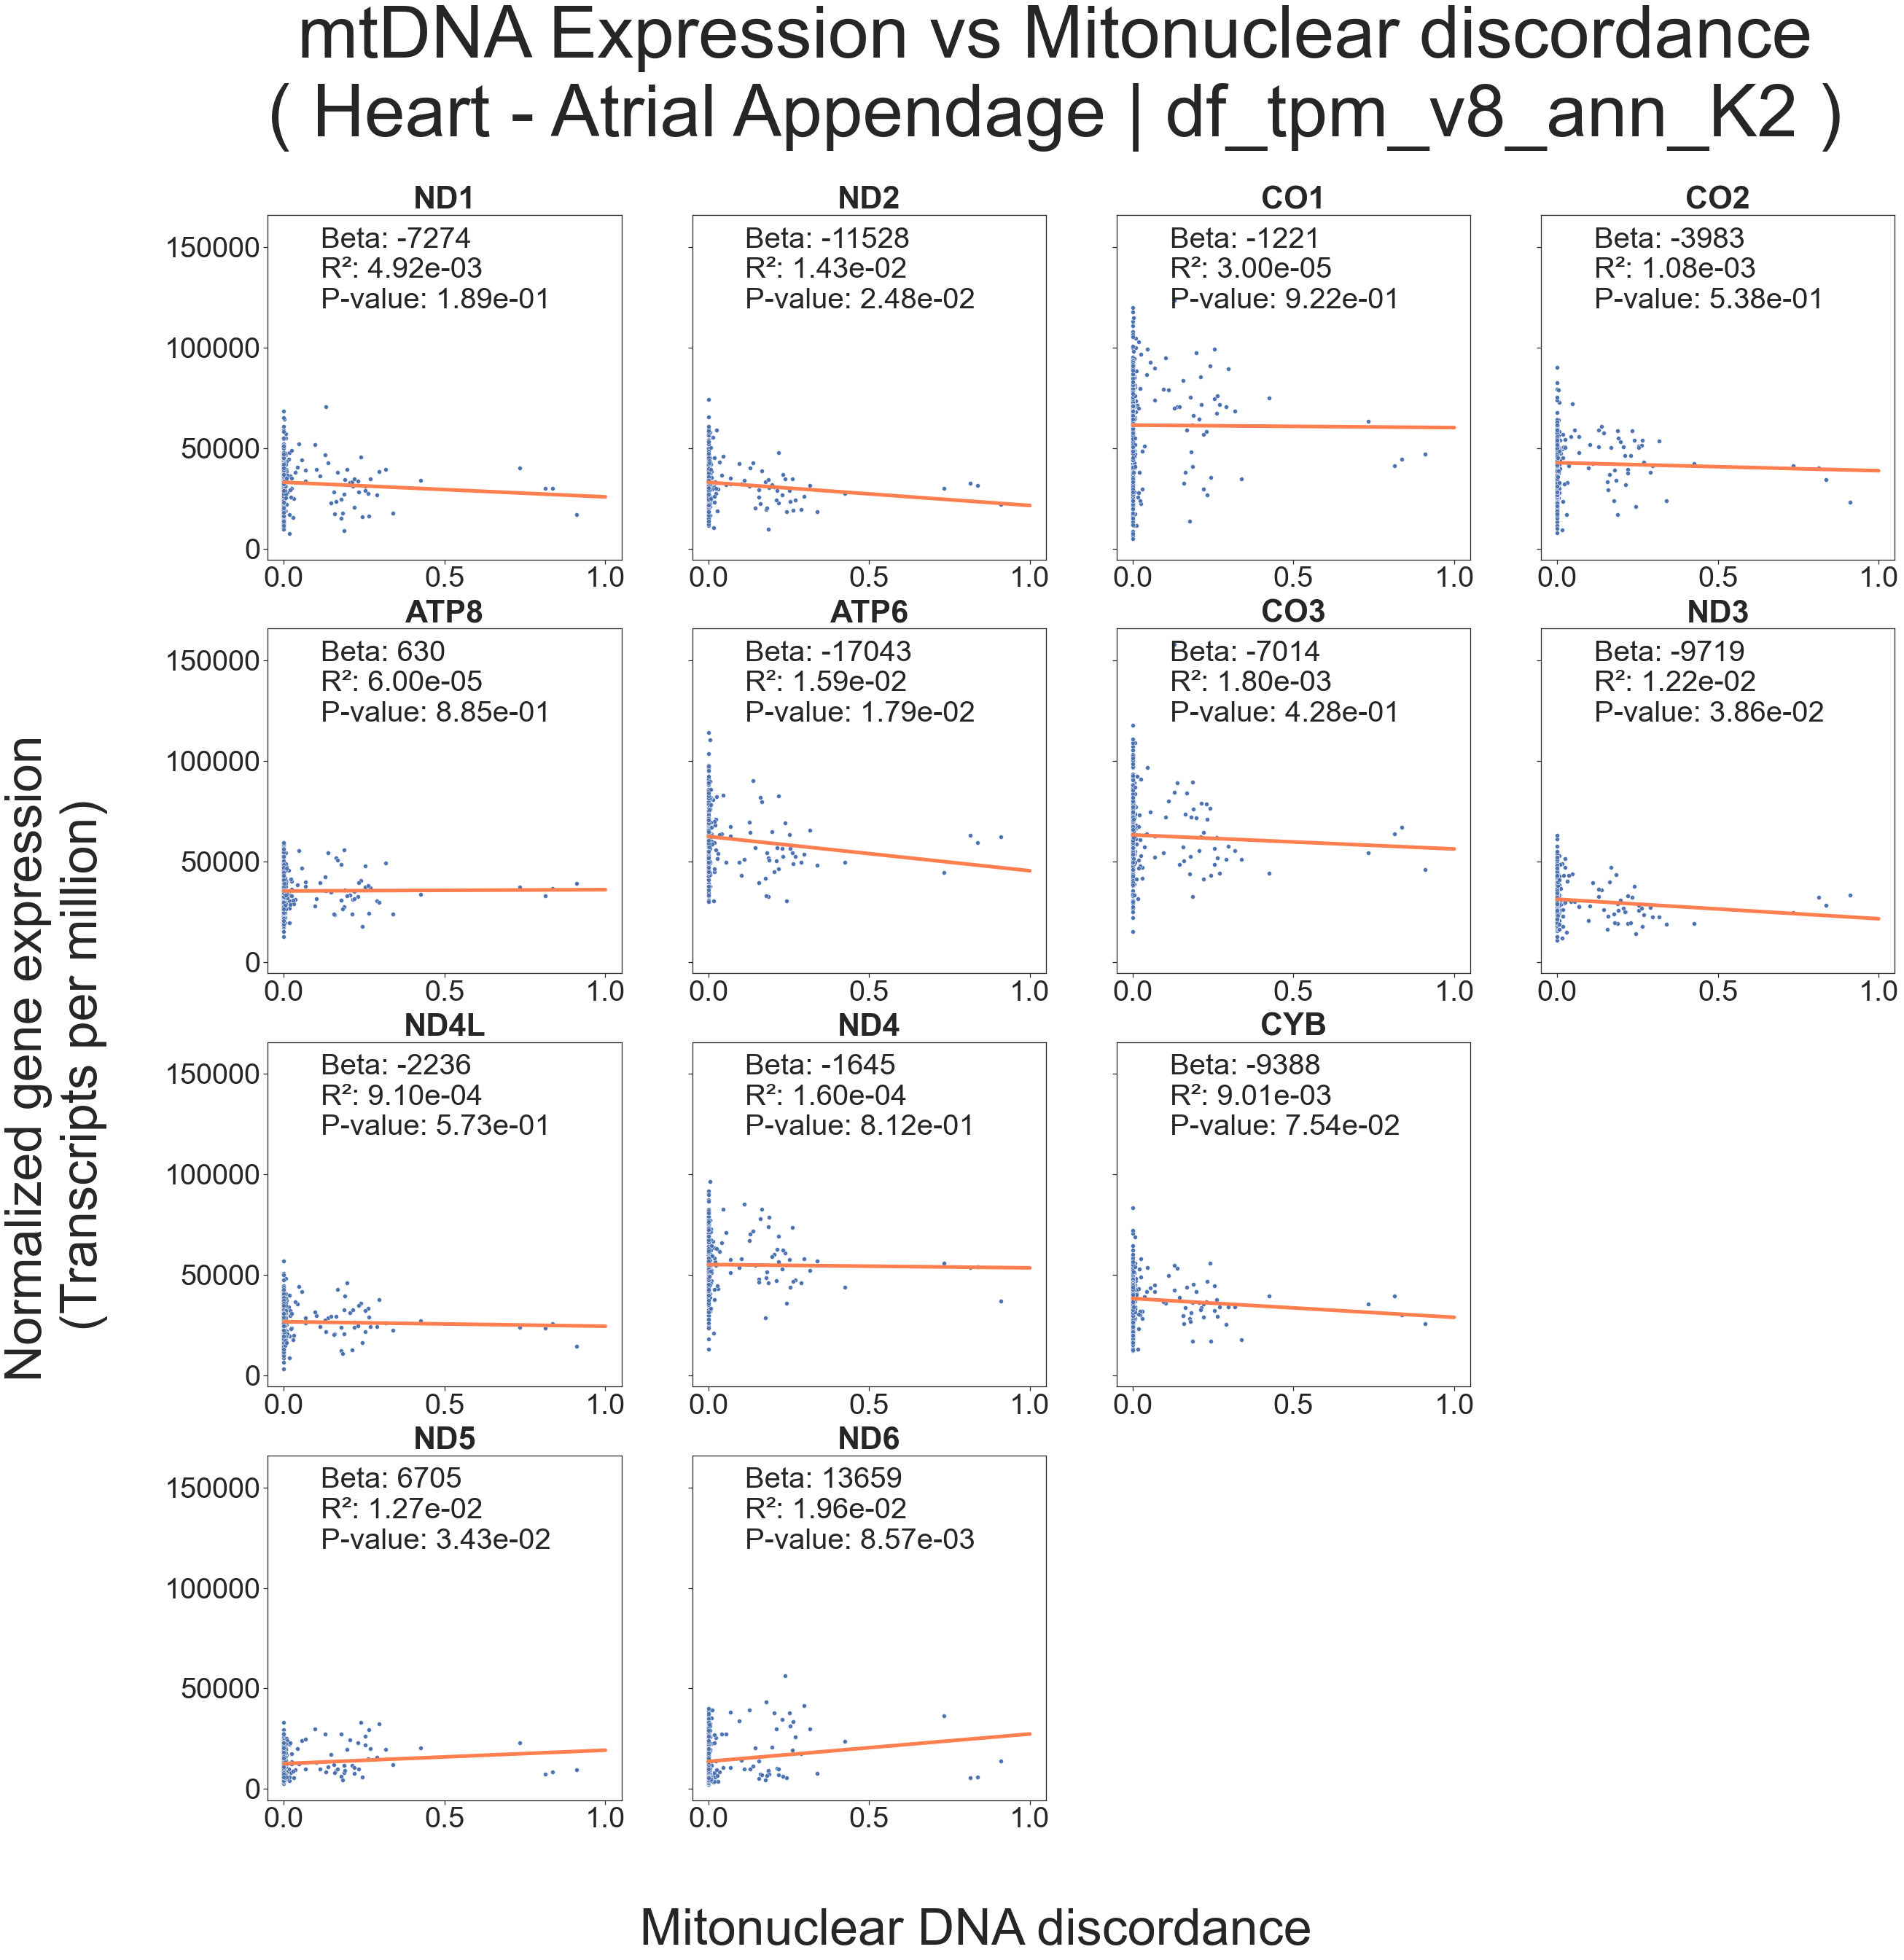

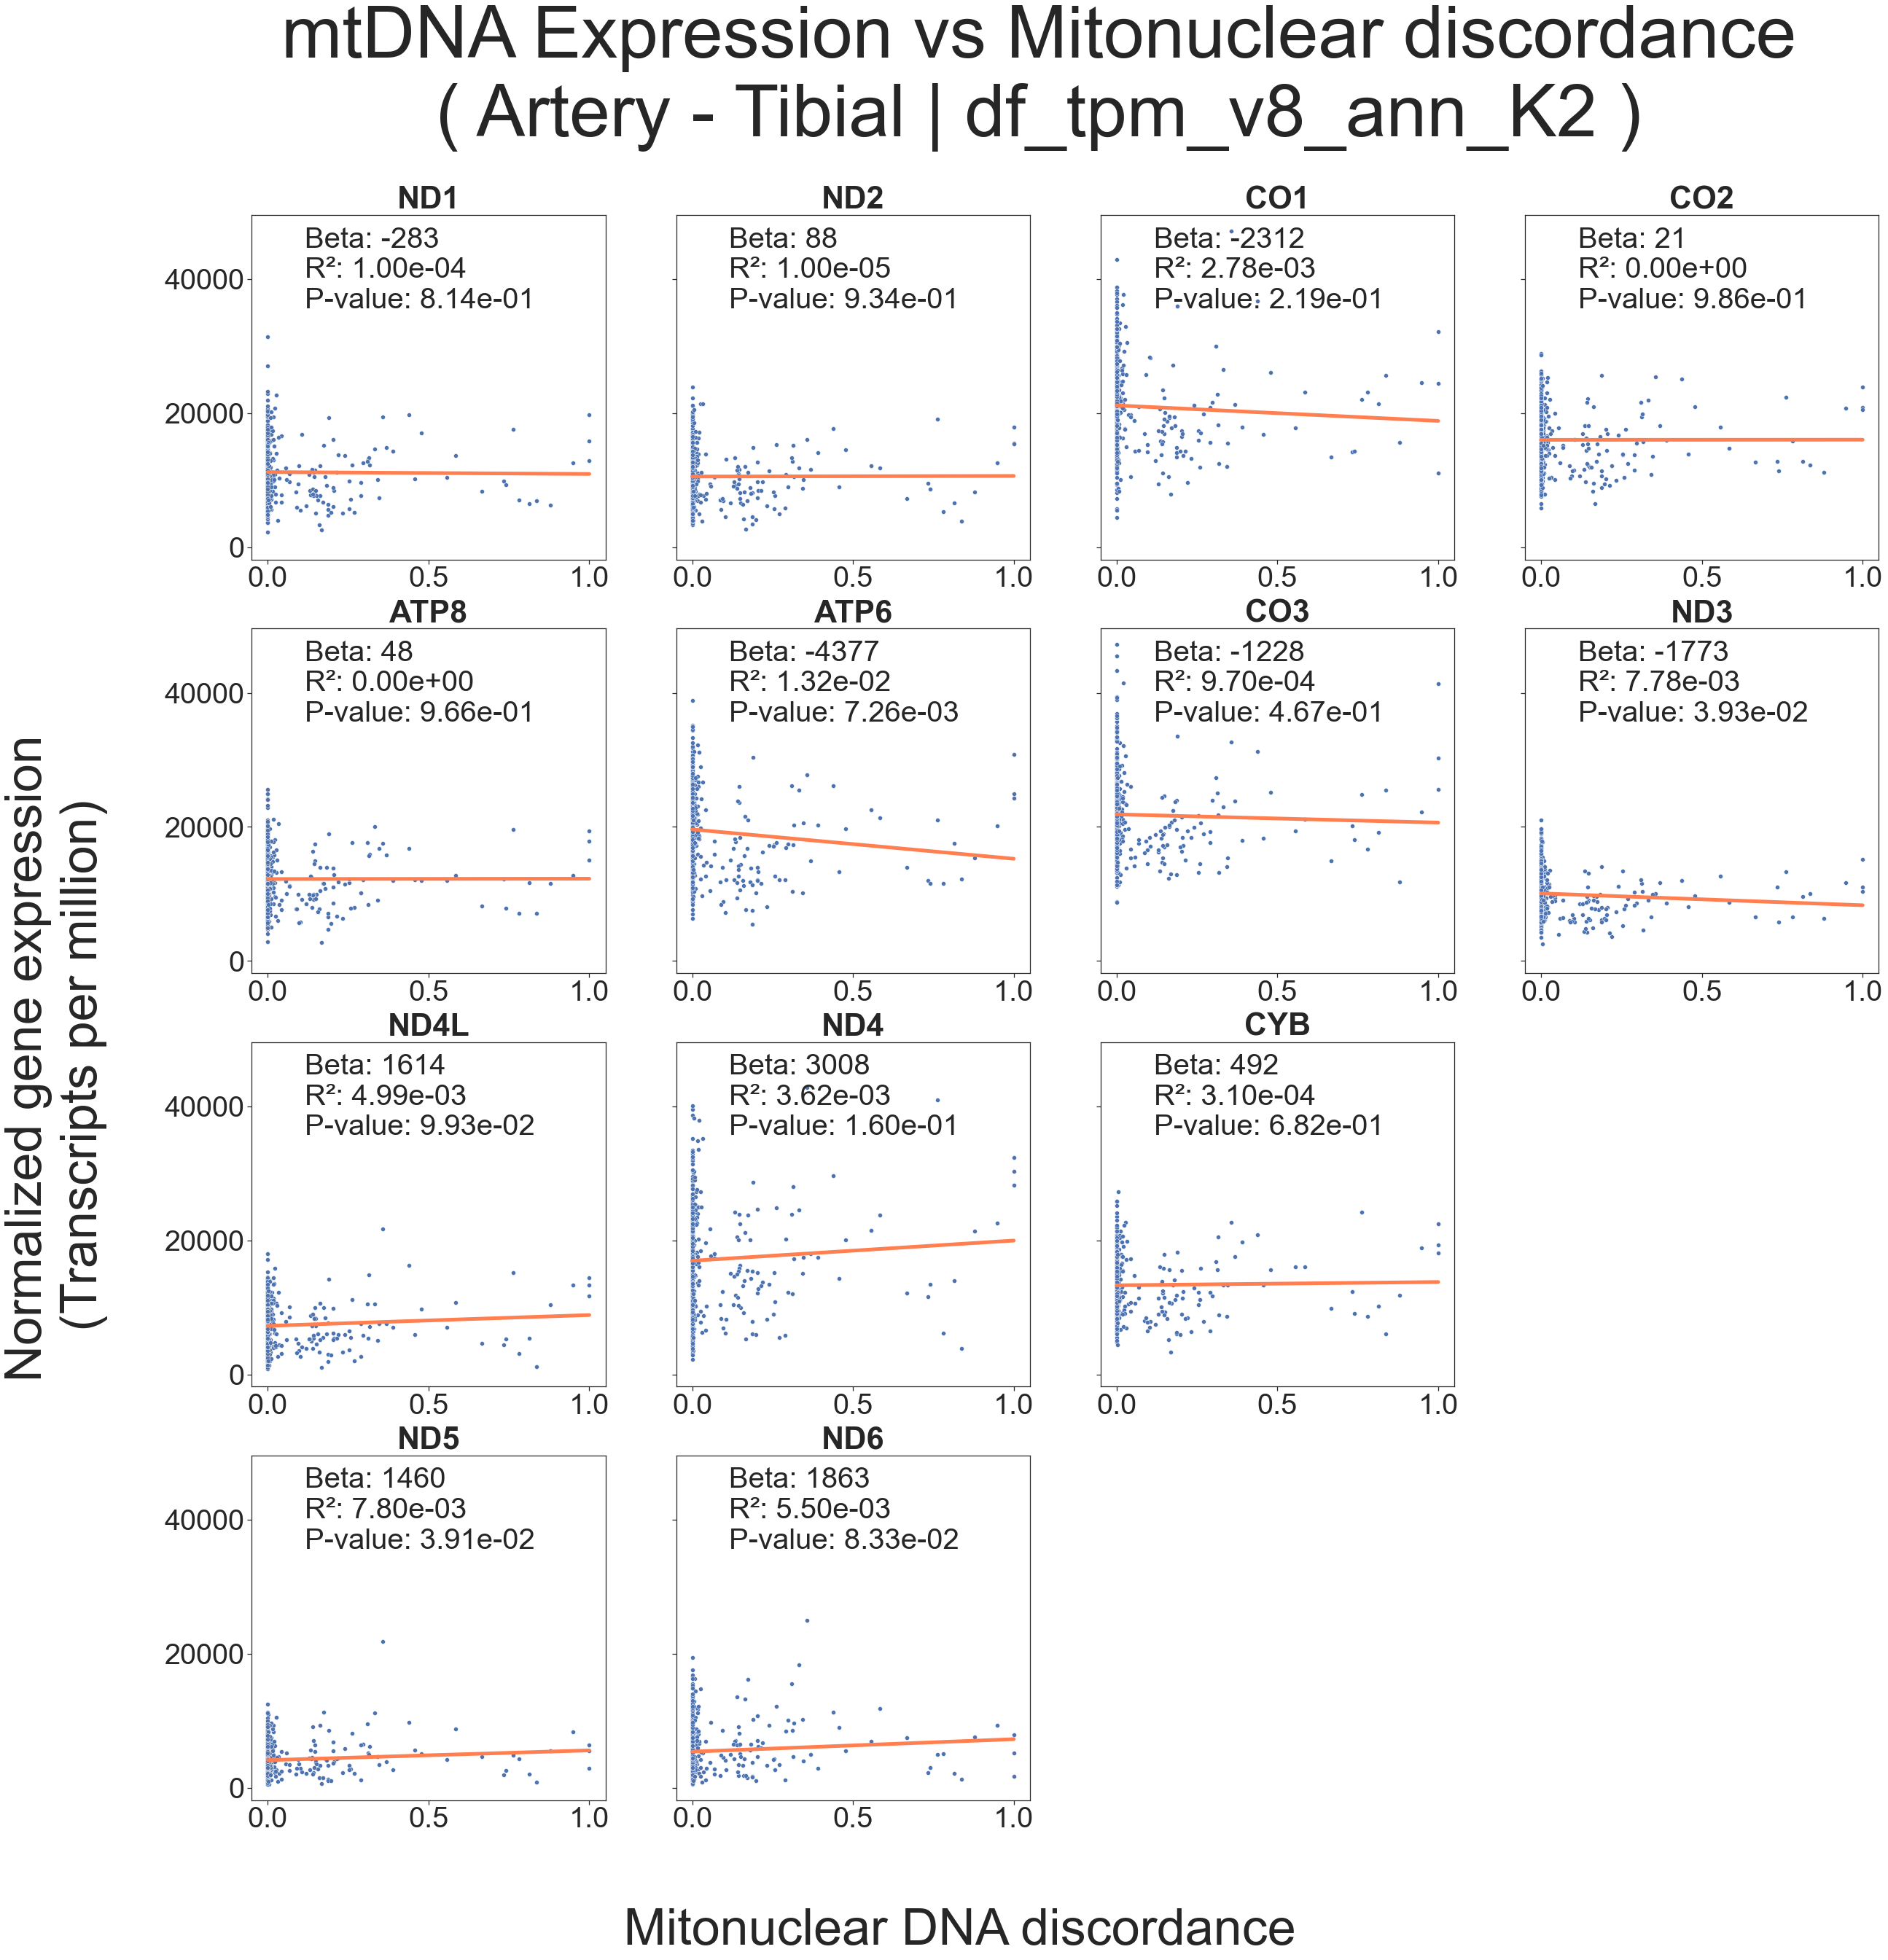

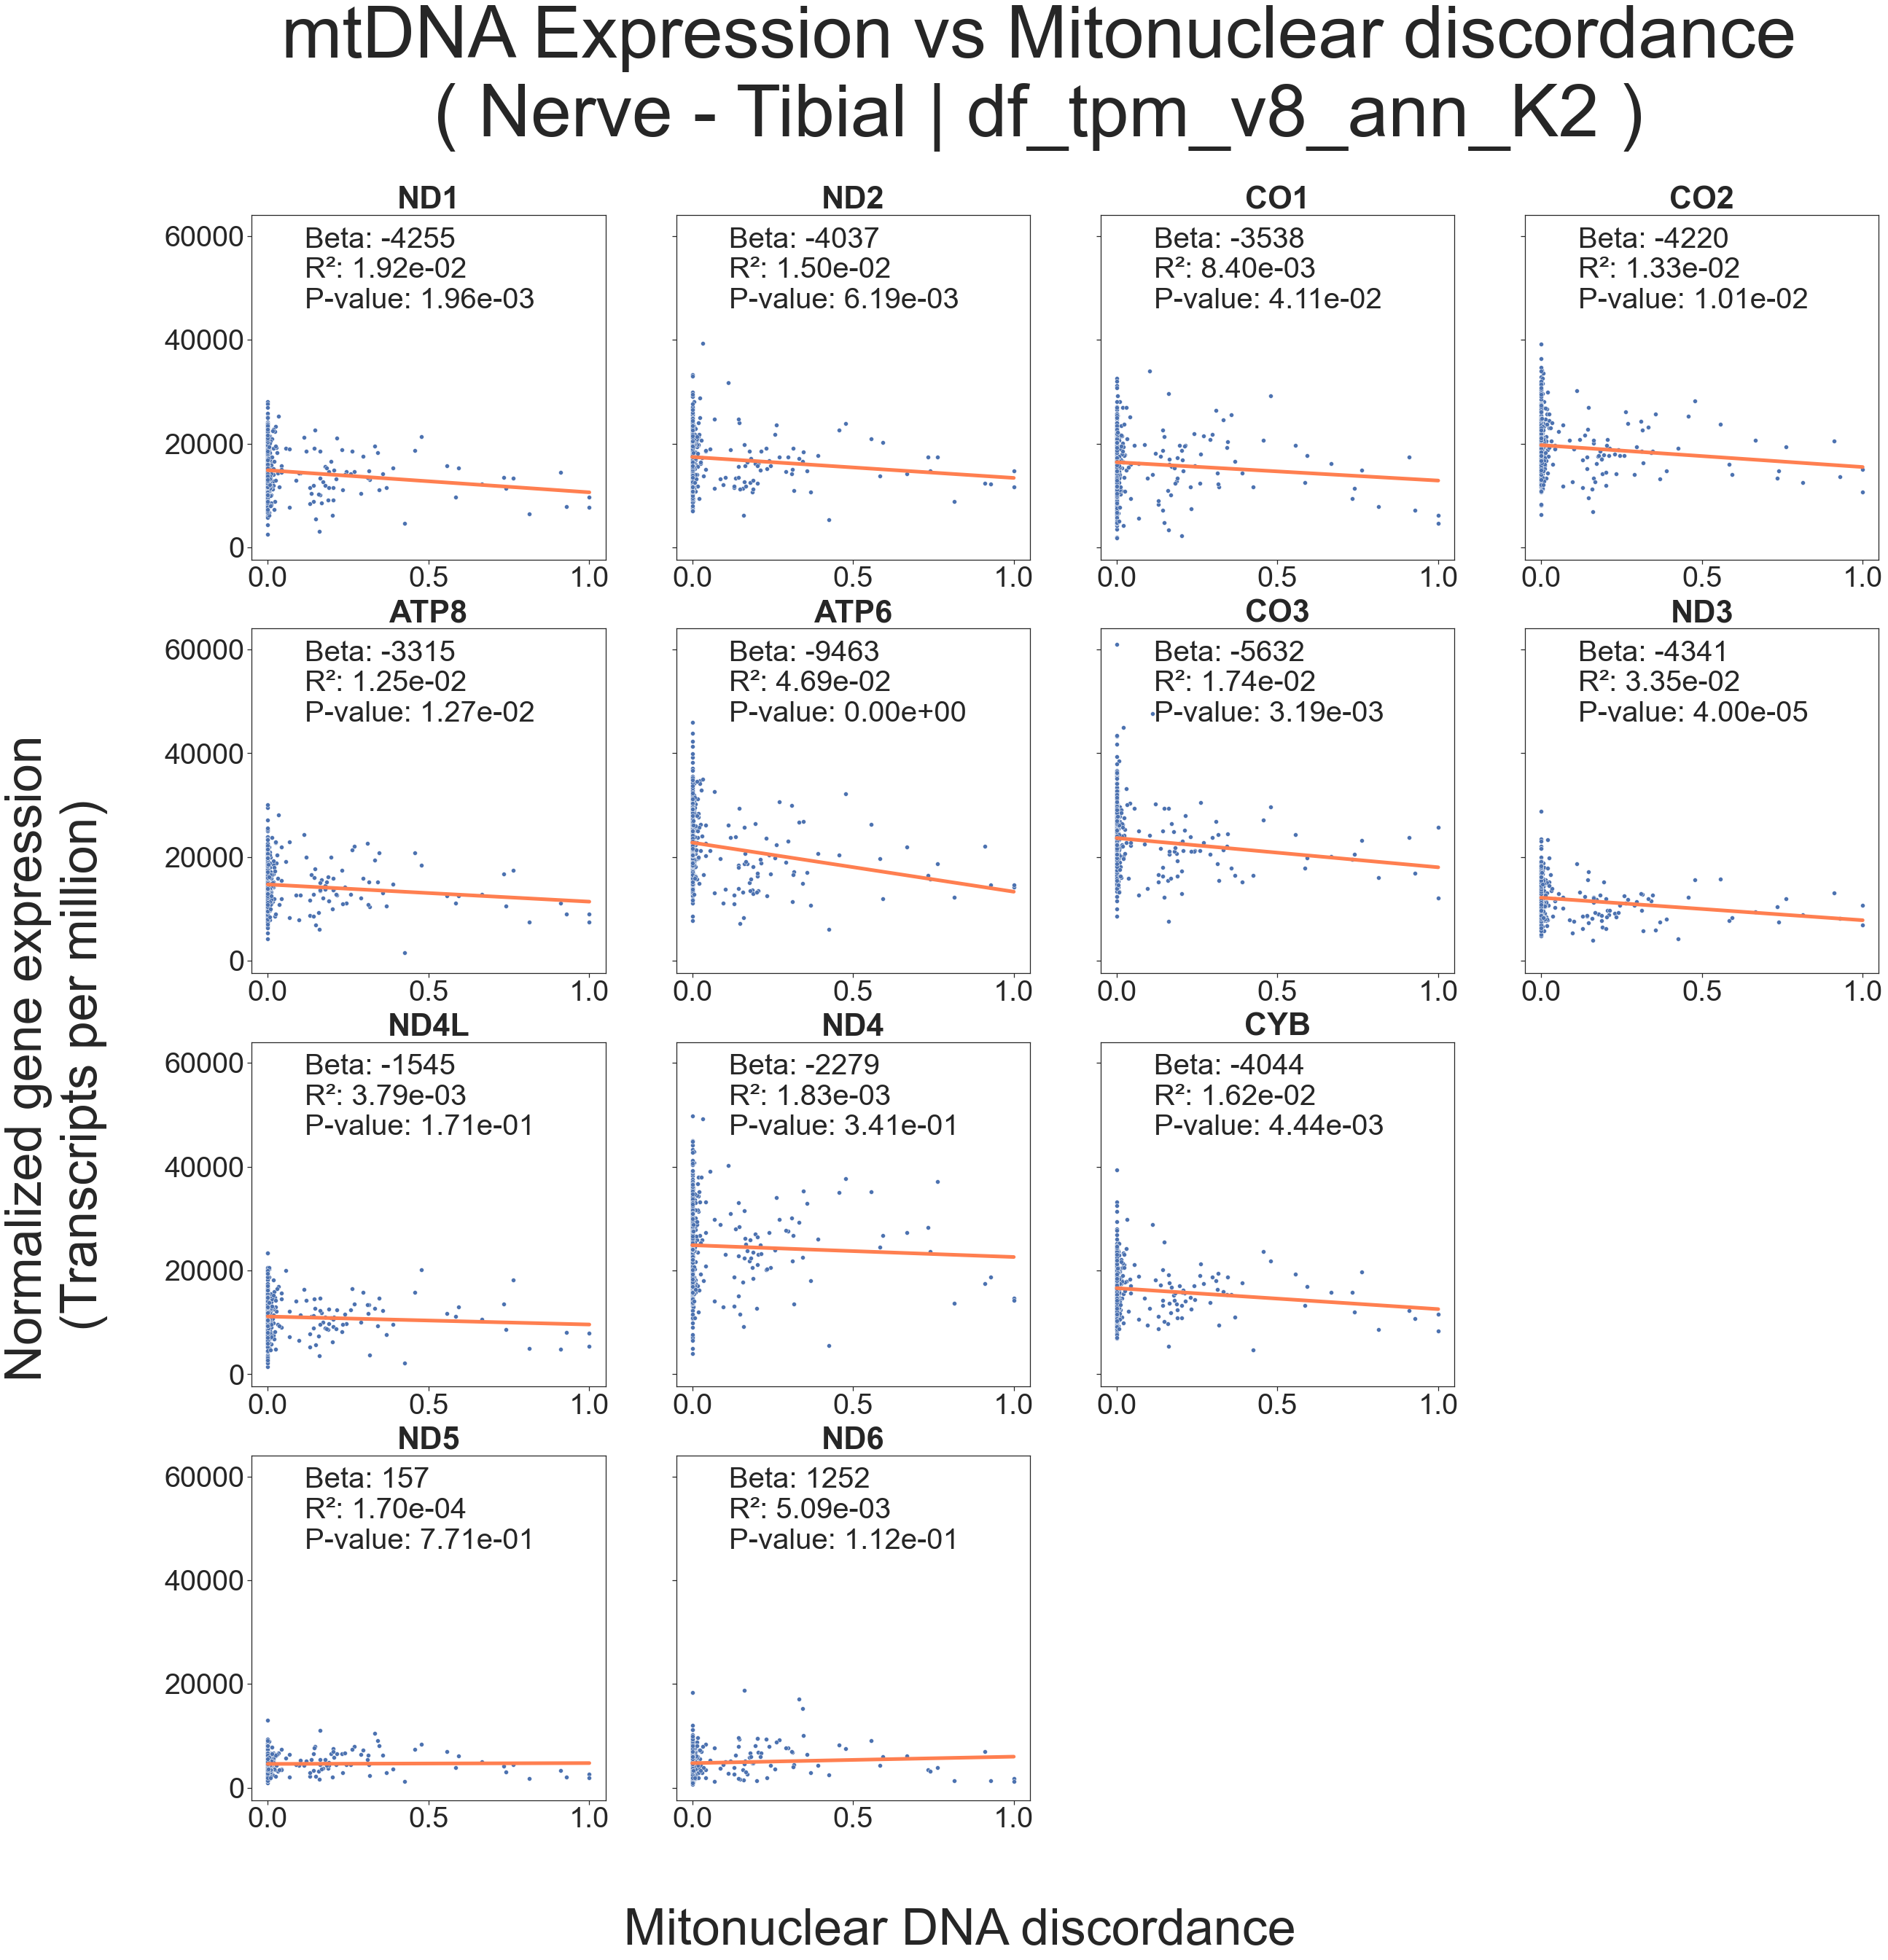

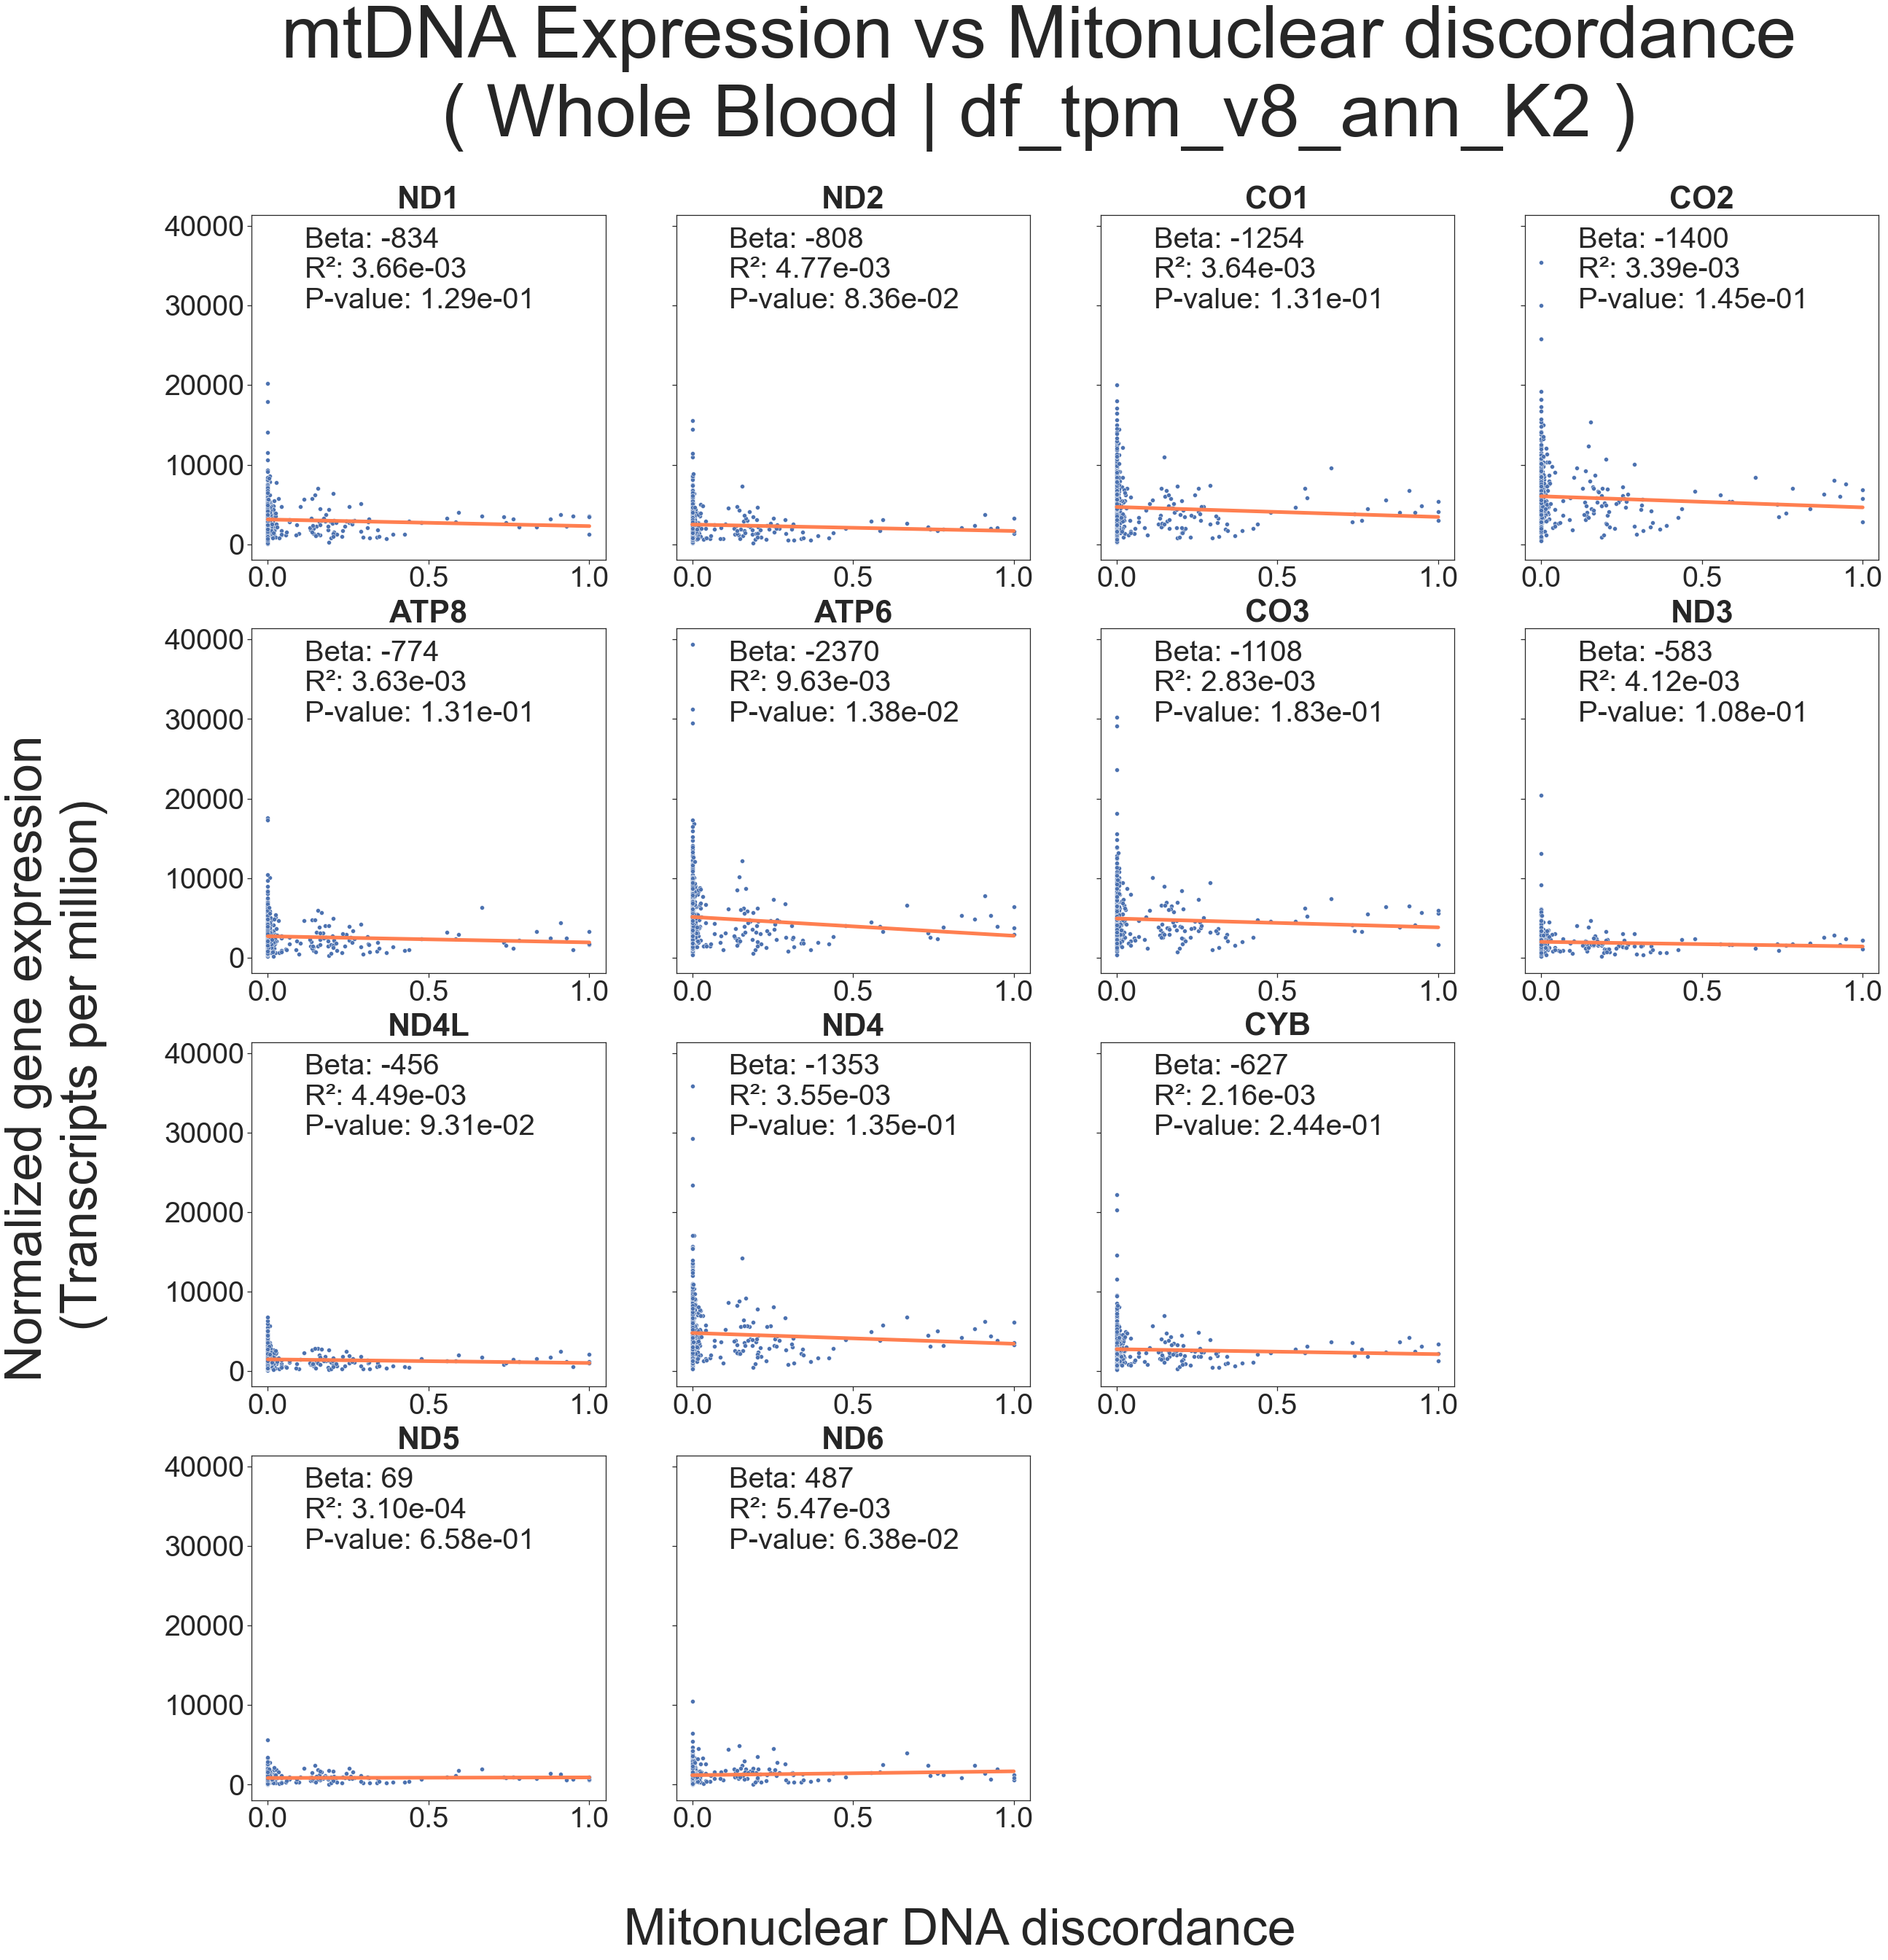

In [35]:
# All genes for list of tissues.
list_tissue = [ 'Muscle - Skeletal','Heart - Left Ventricle','Heart - Atrial Appendage','Artery - Tibial','Nerve - Tibial','Whole Blood' ]
[subplot_expr_mnd(df_tpm_v8_ann_K2,tissue) for tissue in list_tissue]

In [36]:
# Table summarizing Regression results.
list_tissue = [ 'Muscle - Skeletal','Heart - Left Ventricle','Heart - Atrial Appendage','Artery - Tibial','Nerve - Tibial', 'Whole Blood' ]
table_reg_values(df_tpm_v8_ann_K2, list_tissue).pivot(index='Gene',columns='Tissue',values=['Beta','R-squared','P-value']).sort_values('Gene')

Beta                                                  \
Tissue Artery - Tibial Heart - Atrial Appendage Heart - Left Ventricle   
Gene                                                                     
ATP6       -4377.15508             -17042.76021           -20558.67334   
ATP8          47.51886                630.24888            -5934.34548   
CO1        -2312.26552              -1221.42784            -8661.09021   
CO2            20.7344              -3983.43181            -4623.16598   
CO3        -1228.21709              -7013.67656           -12621.93439   
CYB          491.57846               -9388.0387            -8535.24485   
ND1           -283.327              -7274.26056            -1948.09466   
ND2           88.10494             -11528.23404            -5227.09901   
ND3        -1772.91429              -9719.03257            -5680.51602   
ND4         3007.94708              -1644.64759              -584.2763   
ND4L        1614.46612              -2236.36583             -287.92399   
ND5         1460.10773               6705.32358              2891.1283   
ND6         1862.75124              13658.53875             4911.70065   

                                                           R-squared  \
Tissue Muscle - Skeletal Nerve - Tibial  Whole Blood Artery - Tibial   
Gene                                                                   
ATP6         -11086.3769    -9463.02856  -2369.67639         0.01317   
ATP8          -710.44385    -3314.59987   -773.99073             0.0   
CO1          -8929.57085    -3538.46358  -1254.09646         0.00278   
CO2          -4984.41443    -4219.61742  -1400.12898             0.0   
CO3          -1009.78093    -5631.65178  -1107.52855         0.00097   
CYB          -2072.35786    -4044.38909   -627.48602         0.00031   
ND1          -3674.62748    -4254.55425   -834.22459          0.0001   
ND2          -3469.07546    -4037.31867   -807.55417           1e-05   
ND3          -5179.58303    -4340.53013   -583.10459         0.00778   
ND4          -1528.44933    -2278.88108  -1352.76936         0.00362   
ND4L          -814.69992    -1545.29964   -455.82851         0.00499   
ND5           3812.88984      156.70679     68.96044          0.0078   
ND6           5888.81613     1251.57705     486.7959          0.0055   

                                                                          \
Tissue Heart - Atrial Appendage Heart - Left Ventricle Muscle - Skeletal   
Gene                                                                       
ATP6                    0.01593                0.02692           0.02366   
ATP8                      6e-05                0.00558           0.00021   
CO1                       3e-05                0.00147           0.00612   
CO2                     0.00108                0.00166           0.00404   
CO3                      0.0018                0.00641           0.00017   
CYB                     0.00901                0.01043            0.0017   
ND1                     0.00492                0.00062           0.00339   
ND2                     0.01431                0.00668           0.00423   
ND3                     0.01217                0.00546           0.02171   
ND4                     0.00016                  2e-05            0.0005   
ND4L                    0.00091                  1e-05           0.00047   
ND5                     0.01274                0.00804           0.01488   
ND6                     0.01958                0.01005           0.01561   

                                          P-value                           \
Tissue Nerve - Tibial Whole Blood Artery - Tibial Heart - Atrial Appendage   
Gene                                                                         
ATP6          0.04686     0.00963         0.00726                  0.01785   
ATP8          0.01248     0.00363         0.96569                  0.88535   
CO1            0.0084     0.00364         0.21899                  0.9221

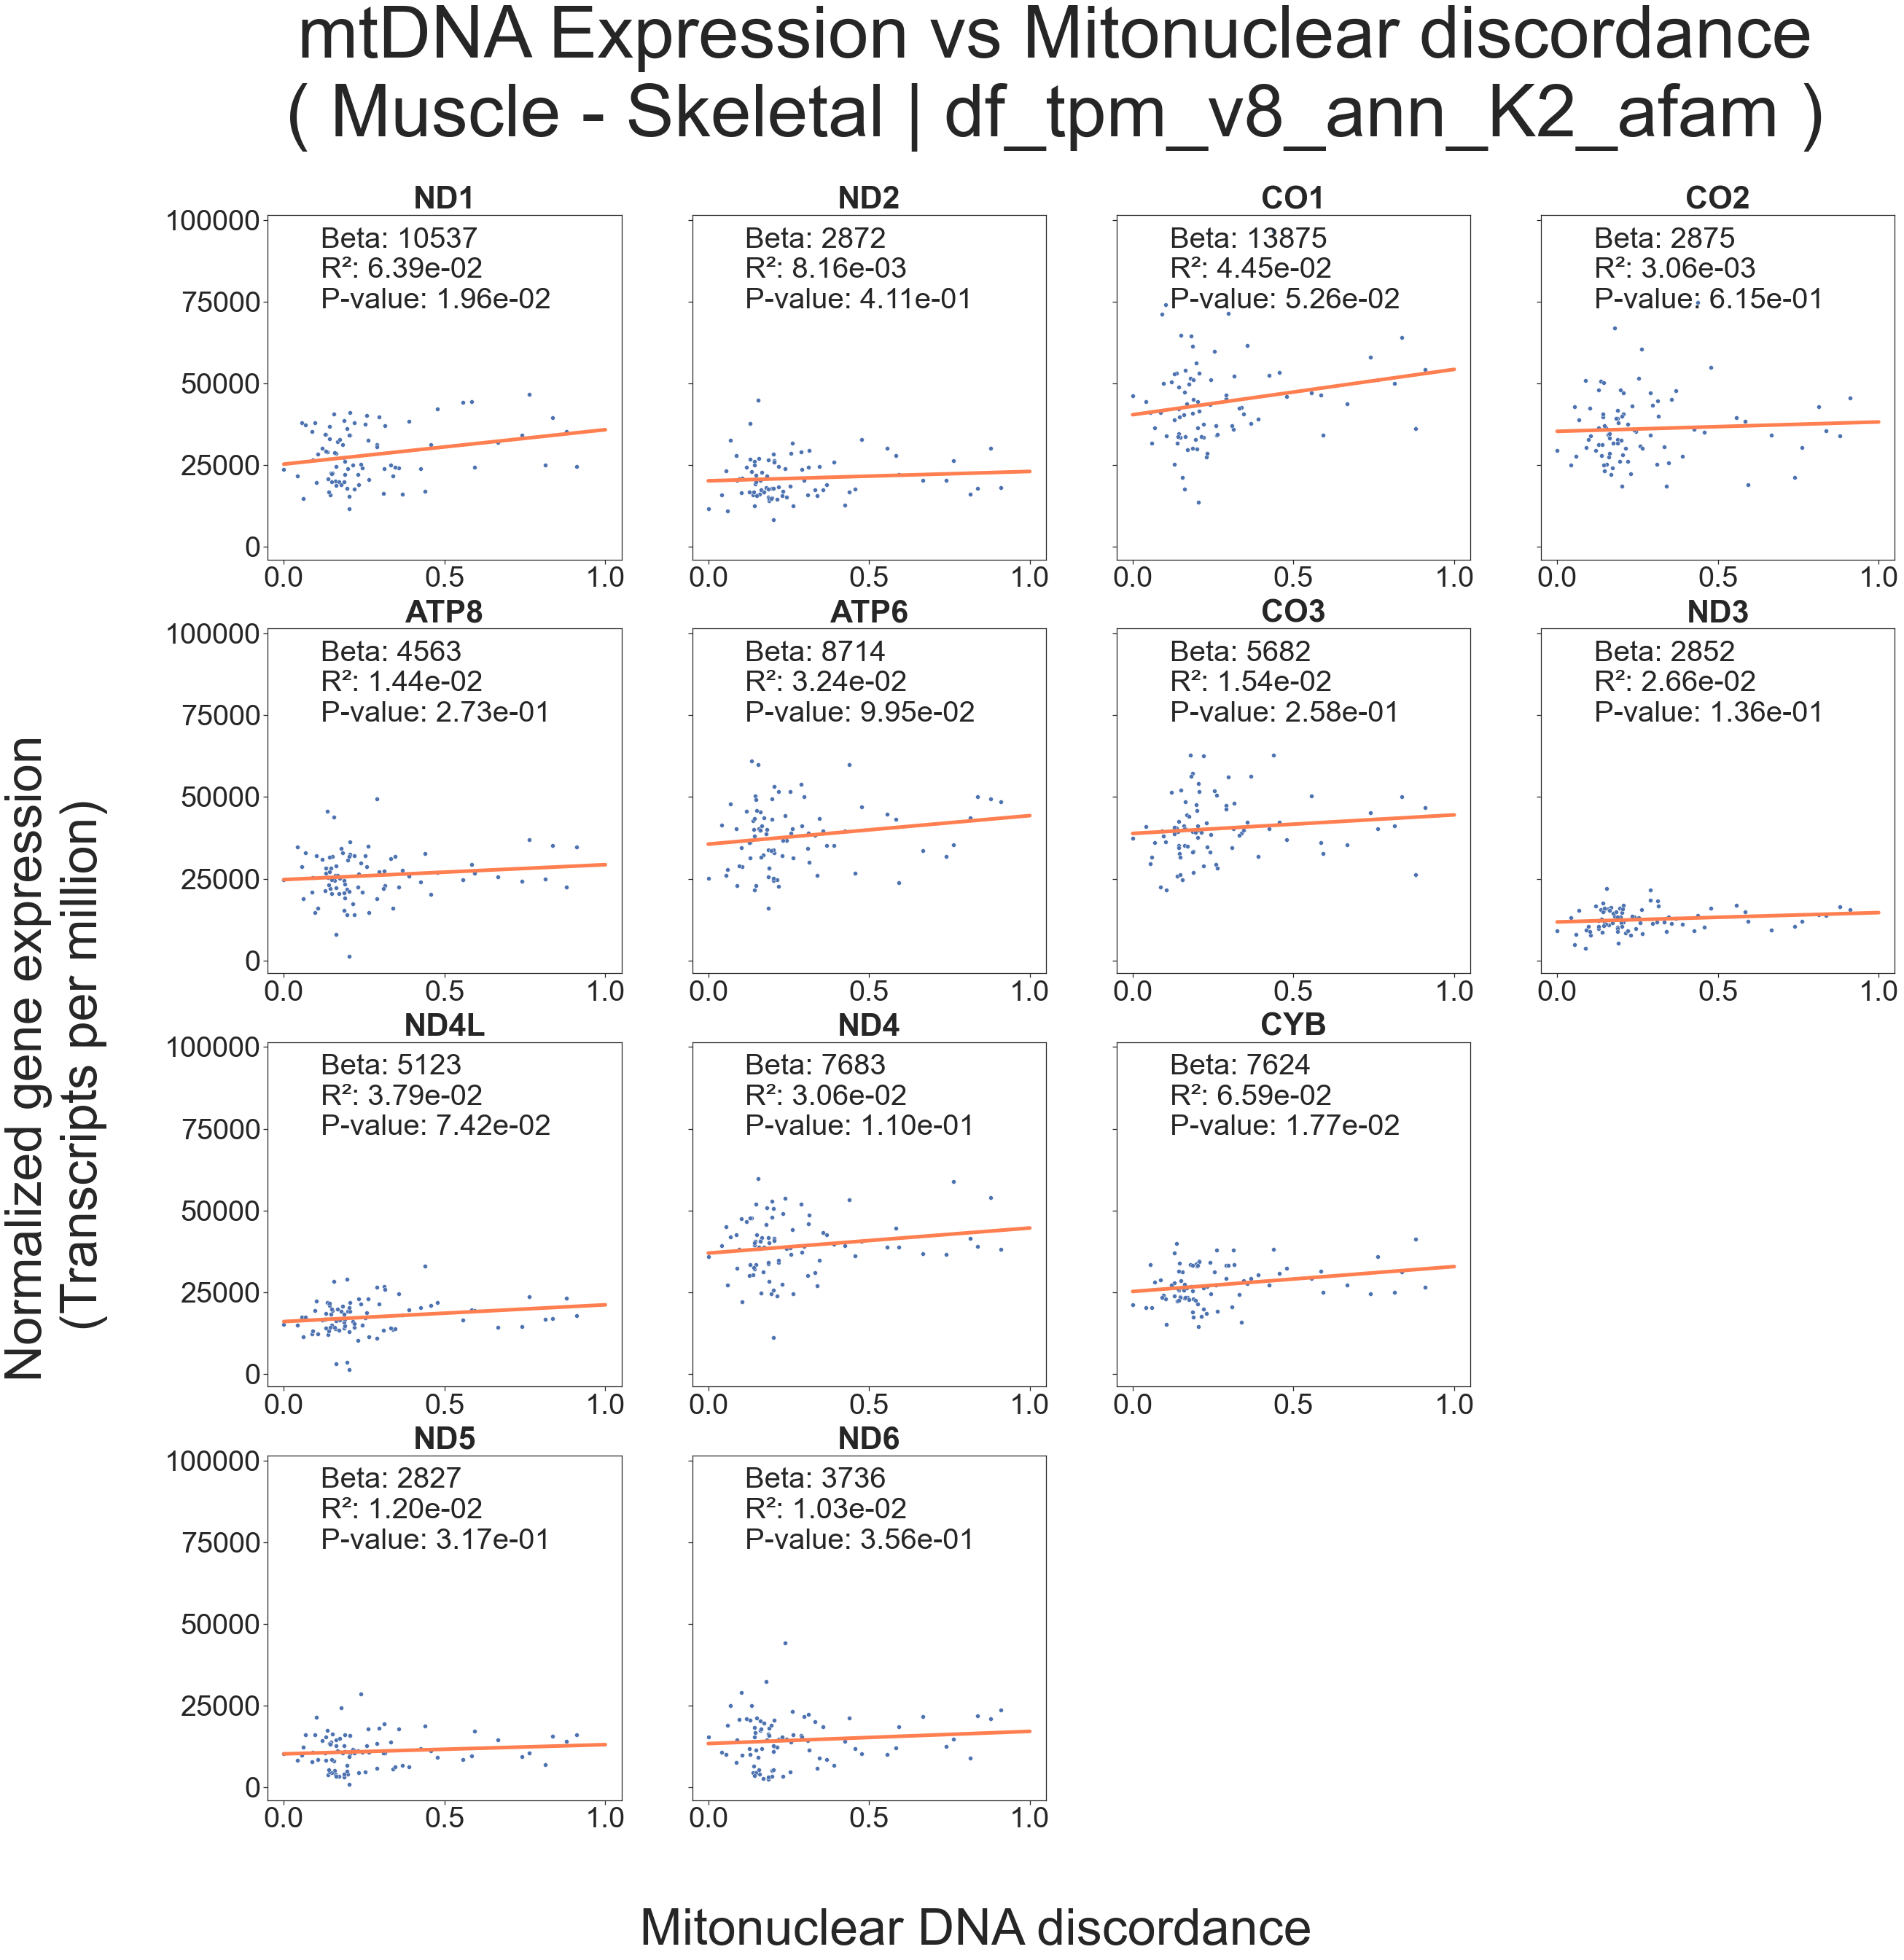

In [37]:
# Regression with just AfAm (no EuAM because most MND values are near 0).
df_tpm_v8_ann_K2_afam = df_tpm_v8_ann_K2[df_tpm_v8_ann_K2['self_rep_race']=='AfAm']
df_tpm_v8_ann_K2_afam.name = 'df_tpm_v8_ann_K2_afam'
subplot_expr_mnd(df_tpm_v8_ann_K2_afam,'Muscle - Skeletal')

# Permutation tests
- Statistic: difference in mean TPM below the MND cutoff, and mean TPM above the MND cutoff.
- Observed difference in mean TPM: Calculates this statistic in our observed data.
- Expected distribution of differences in mean TPM: For 1000 permutations, the statistic is calculated then plotted.
- one-sided P-value: The proportion of permutations with a result above the observed difference in mean TPM.


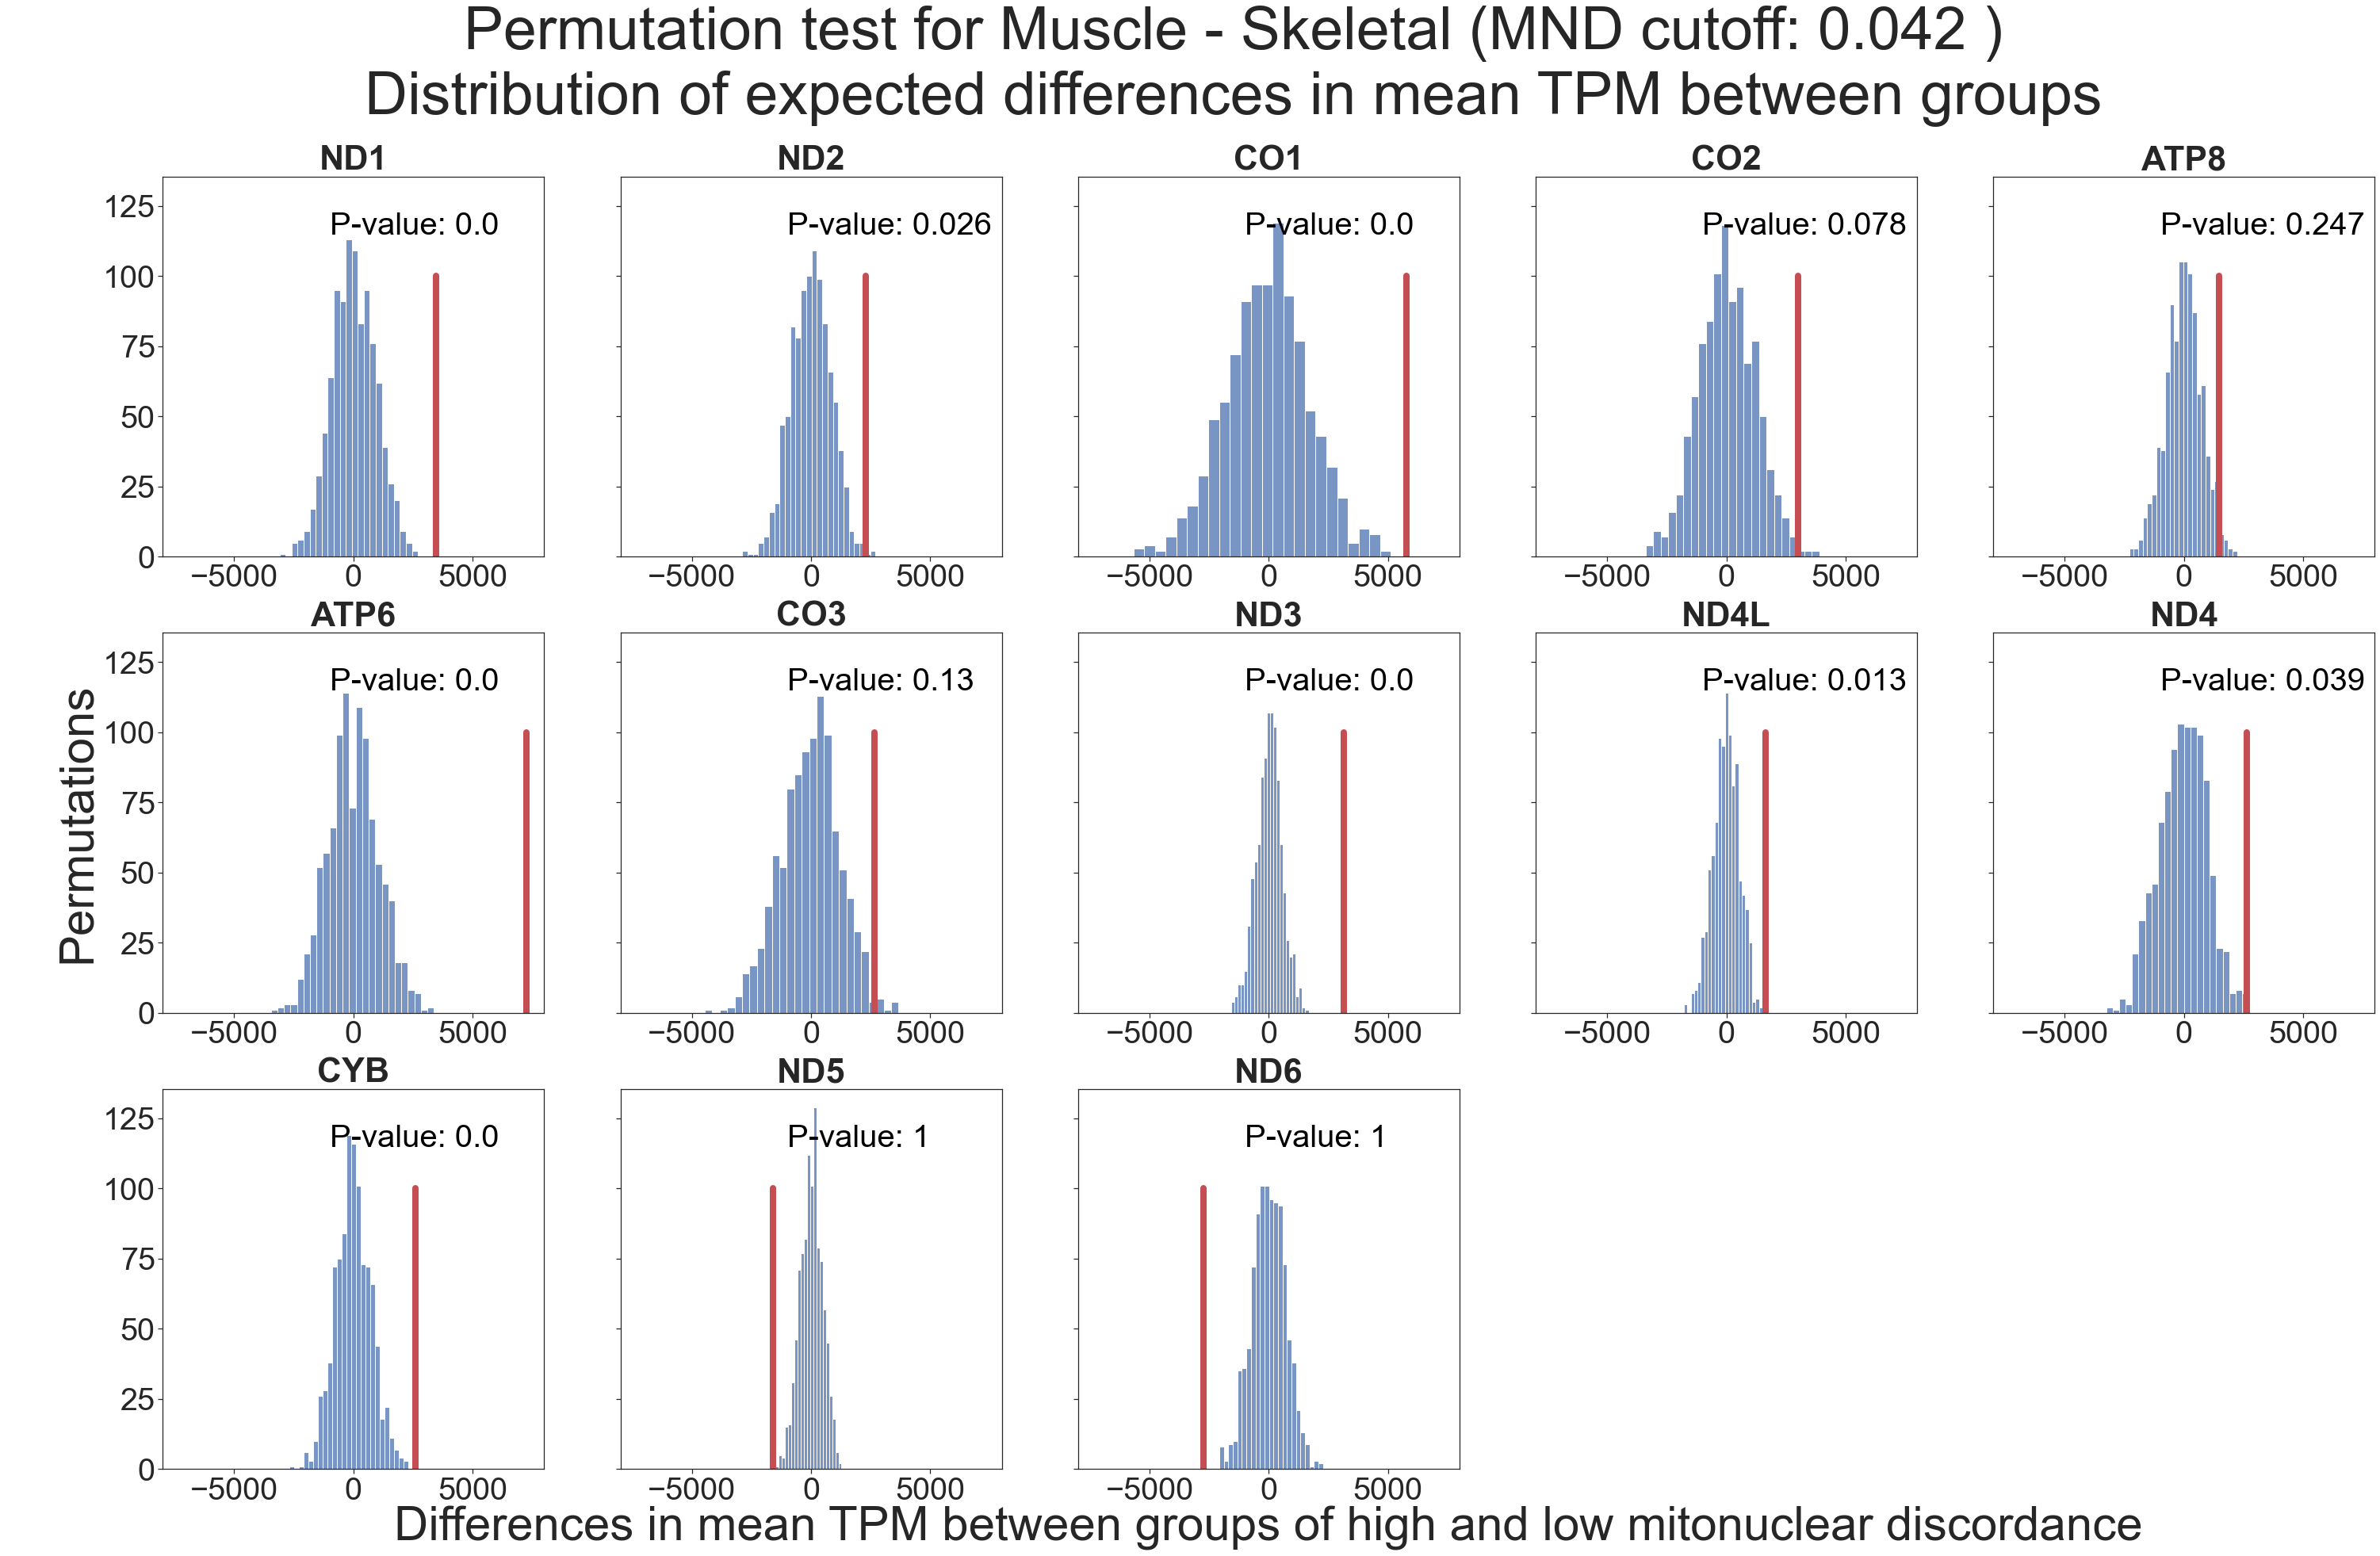

In [38]:
#%%timeit
# The list of mtDNA protein-coding genes.
###list_mtdna = [ 'MT-ND1','MT-ND2','MT-CO1','MT-CO2','MT-ATP8','MT-ATP6','MT-CO3','MT-ND3','MT-ND4L','MT-ND4','MT-CYB','MT-ND5','MT-ND6' ]


def permut_mnd_tpm( df,tissue,gene,cutoffMND ):
    # Keep MND and TPM for a single gene.
    data = df[(df['Tissue'] == tissue)&(df['Gene'] == gene)][['mitonucl_discord','Gene','TPM']]
    if cutoffMND == 'median':
        cutoffMND = data['mitonucl_discord'].median()
    elif cutoffMND == 'mean':
        cutoffMND = data['mitonucl_discord'].mean()
    # Observed difference in mean TPMs.
    obs_diff = data[data['mitonucl_discord'] < cutoffMND]['TPM'].mean() - data[data['mitonucl_discord'] >= cutoffMND]['TPM'].mean()
    # Permutation values.
    perm_repl = 1000
    perm_results = []
    for seq in list(range(perm_repl)):
        # Permute MND labels.
        data['mitonucl_discord'] = np.random.permutation(data['mitonucl_discord'])
        # Split data at MND of 0.1, then get the mean TPM (sample statistic).
        mean_up = data[data['mitonucl_discord'] >= cutoffMND]['TPM'].mean()
        mean_down = data[data['mitonucl_discord'] < cutoffMND]['TPM'].mean()
        # Add results.
        perm_results.append((mean_down,mean_up))
    # Add results into a dataframe (to be exported).
    results = pd.DataFrame(perm_results)
    results.columns = ['Below_MND_'+str(cutoffMND),'Above_MND_'+str(cutoffMND)]
    results['Difference'] = results['Below_MND_'+str(cutoffMND)] - results['Above_MND_'+str(cutoffMND)]
    # Estimate p-value.
    no_aboveObs = results[results['Difference'] > obs_diff].shape[0]
    pvalue = no_aboveObs/perm_repl
    return(results,obs_diff,cutoffMND,pvalue)


def subplot_perm( df,tissue,cutoffMND,list_mtdna ):
    # Parameters for multiple plots / Subplotting.  (https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8)
    fig, axes = plt.subplots(3,5, figsize=(50,30), sharex=False, sharey=True)
    num_plots=13
    perm_repl=1000
    # Choose ax_order.
    ax_order = [axes[0, 0], axes[0, 1], axes[0, 2], axes[0, 3], axes[0, 4], axes[1, 0], axes[1, 1], axes[1, 2], axes[1, 3], axes[1, 4], axes[2, 0], axes[2, 1], axes[2, 2]]
    #ax_order = [axes[0, 0], axes[0, 1], axes[0, 2], axes[0, 3], axes[1, 0], axes[1, 1], axes[1, 2], axes[1, 3], axes[2, 0], axes[2, 1], axes[2, 2], axes[3, 0], axes[3, 1]]
    # Plot results of permutation for each gene.
    for ( gene , ax_curr ) in zip( list_mtdna , ax_order ):  #(https://stackoverflow.com/questions/1663807/how-to-iterate-through-two-lists-in-parallel)
        # Run permutation.
        results,obs_diff,cutoffMND,pvalue = permut_mnd_tpm(df,tissue,gene,cutoffMND)
        # Plot results for this gene.
        sns.set(rc={'figure.figsize':(20,20)},font_scale=3.6)
        sns.set_style("ticks")
        sns.histplot( results['Difference'] , ax=ax_curr)
        ax_curr.set_xlim(-8000, 8000)
        ax_curr.set_title(gene, weight='bold')
        ax_curr.set_ylabel("")
        ax_curr.set_xlabel("")
        # Plot line of the Observed mean difference in TPM .
        ax_curr.plot([obs_diff,obs_diff], [100, 0], linewidth=8, color='r')
        # Plot the p-value (the number of results above the observed value over the number of iterations of the test).
        no_aboveObs = results[results['Difference'] > obs_diff].shape[0]
        # Bonferroni-corrected p-value.
        pvalue = round((no_aboveObs/perm_repl)*13, 4)
        if pvalue >= 1:
            pvalue = 1
        ax_curr.text(-1000, 115, 'P-value: '+str(pvalue) , fontsize=40, color='black')
    # Title for the entire plot.
    fig.suptitle('Permutation test for '+tissue+' (MND cutoff: '+str(round(cutoffMND,3))+" )\nDistribution of expected differences in mean TPM between groups", size=75)
    # Manually insert y-axis and explain vertical red line.
    axes[1,0].set_ylabel('\nPermutations',
                         fontsize=60, ha='center')
    axes[1,2].set_xlabel('\n\n\n\n\n\n\n\n\nDifferences in mean TPM between groups of high and low mitonuclear discordance' , 
                         fontsize=60, ha='center' )
    ##plt.text(-40000, -30,'Observed difference in mean TPM' , fontsize=60, color='r', ha='left')
    # Remove subplots.
    ##axes[3,3].axis("off")
    axes[2,4].axis("off")
    axes[2,3].axis("off")
    
    ## Save figure.
    #plt.savefig('../results/permutation_skeletal_10142021.pdf')


def table_permut_mnd_tpm( df,list_tissue,cutoffMND ):
    out = []
    for tissue in list_tissue:
        for gene in list_mtdna:
            results,obs_diff,cutoff,pvalue = permut_mnd_tpm(df,tissue,gene,cutoffMND)
            out.append([tissue,gene,cutoff,obs_diff,pvalue])
    ##out['Bonf_p-value'] = out['P-value']*13
    ## If Bonferroni-corrected p-value is above 1, reset to 1 (the upper range of all p-values).
    ##out.loc[out['Bonf_p-value'] >=1,'Bonf_p-value'] = 1
    return(pd.DataFrame(out, columns=['Tissue','Gene','Cutoff_MND','Obs_diff','P-value']))



#permut_mnd_tpm(df_tpm_v8_ann_K2,'Muscle - Skeletal','MT-ATP6',0.1)[0]
#permut_mnd_tpm(df_tpm_v8_ann_K2,'Muscle - Skeletal','MT-ATP6','median')[0]
subplot_perm(df_tpm_v8_ann_K2,'Muscle - Skeletal','mean',list_mtdna)
#table_permut_mnd_tpm(df_tpm_v8_ann_K2,list_tissue,'mean')

In [39]:
list_tissue = [ 'Muscle - Skeletal','Esophagus - Muscularis','Heart - Left Ventricle','Heart - Atrial Appendage','Artery - Tibial','Nerve - Tibial','Whole Blood' ]
#[subplot_perm(df_tpm_v8_ann_K2,tissue,'mean',list_mtdna) for tissue in list_tissue]

In [40]:
# Table summarizing permutation results.
table_perm = table_permut_mnd_tpm(df_tpm_v8_ann_K2,list_tissue,'mean')
table_perm

Tissue  Gene  Cutoff_MND      Obs_diff  P-value
0          Muscle - Skeletal   ND1    0.042487   3465.114745    0.000
1          Muscle - Skeletal   ND2    0.042487   2294.888206    0.000
2          Muscle - Skeletal   CO1    0.042487   5790.368768    0.000
3          Muscle - Skeletal   CO2    0.042487   3024.921611    0.004
4          Muscle - Skeletal  ATP8    0.042487   1458.567261    0.020
5          Muscle - Skeletal  ATP6    0.042487   7251.142379    0.000
6          Muscle - Skeletal   CO3    0.042487   2643.864012    0.007
7          Muscle - Skeletal   ND3    0.042487   3163.822750    0.000
8          Muscle - Skeletal  ND4L    0.042487   1641.878149    0.001
9          Muscle - Skeletal   ND4    0.042487   2618.348184    0.005
10         Muscle - Skeletal   CYB    0.042487   2613.200053    0.001
11         Muscle - Skeletal   ND5    0.042487  -1609.287089    1.000
12         Muscle - Skeletal   ND6    0.042487  -2753.266016    1.000
13    Esophagus - Muscularis   ND1    0.047615   2402.591045    0.000
14    Esophagus - Muscularis   ND2    0.047615   2638.016702    0.005
15    Esophagus - Muscularis   CO1    0.047615   2271.799974    0.097
16    Esophagus - Muscularis   CO2    0.047615   4465.891944    0.000
17    Esophagus - Muscularis  ATP8    0.047615   1354.190287    0.063
18    Esophagus - Muscularis  ATP6    0.047615   7837.036841    0.000
19    Esophagus - Muscularis   CO3    0.047615   4684.337211    0.008
20    Esophagus - Muscularis   ND3    0.047615   4539.393927    0.000
21    Esophagus - Muscularis  ND4L    0.047615   1778.397673    0.007
22    Esophagus - Muscularis   ND4    0.047615   4026.151066    0.008
23    Esophagus - Muscularis   CYB    0.047615   3543.525472    0.000
24    Esophagus - Muscularis   ND5    0.047615  -1108.379032    0.978
25    Esophagus - Muscularis   ND6    0.047615  -1958.162789    0.989
26    Heart - Left Ventricle   ND1    0.043616   1522.928968    0.187
27    Heart - Left Ventricle   ND2    0.043616   3347.720635    0.009
28    Heart - Left Ventricle   CO1    0.043616   1299.308333    0.392
29    Heart - Left Ventricle   CO2    0.043616   2703.111111    0.139
30    Heart - Left Ventricle  ATP8    0.043616   2810.506746    0.061
31    Heart - Left Ventricle  ATP6    0.043616  11895.180556    0.000
32    Heart - Left Ventricle   CO3    0.043616   5731.150794    0.044
33    Heart - Left Ventricle   ND3    0.043616   3709.882540    0.012
34    Heart - Left Ventricle  ND4L    0.043616    202.677778    0.464
35    Heart - Left Ventricle   ND4    0.043616    886.960317    0.365
36    Heart - Left Ventricle   CYB    0.043616   4091.651190    0.007
37    Heart - Left Ventricle   ND5    0.043616  -2415.369246    0.997
38    Heart - Left Ventricle   ND6    0.043616  -3721.979563    1.000
39  Heart - Atrial Appendage   ND1    0.033720    517.103872    0.380
40  Heart - Atrial Appendage   ND2    0.033720   3193.721660    0.030
41  Heart - Atrial Appendage   CO1    0.033720  -6233.673805    0.935
42  Heart - Atrial Appendage   CO2    0.033720  -2311.003907    0.892
43  Heart - Atrial Appendage  ATP8    0.033720  -1029.871643    0.781
44  Heart - Atrial Appendage  ATP6    0.033720   6470.562260    0.001
45  Heart - Atrial Appendage   CO3    0.033720  -1464.325776    0.698
46  Heart - Atrial Appendage   ND3    0.033720   3268.704569    0.008
47  Heart - Atrial Appendage  ND4L    0.033720  -1389.060342    0.873
48  Heart - Atrial Appendage   ND4    0.033720  -3360.325078    0.935
49  Heart - Atrial Appendage   CYB    0.033720   1606.762469    0.176
50  Heart - Atrial Appendage   ND5    0.033720  -3440.263621    1.000
51  Heart - Atrial Appendage   ND6    0.033720  -6316.443460    1.000
52           Artery - Tibial   ND1    0.048465   1184.191886    0.011
53           Artery - Tibial   ND2    0.048465   1013.101043    0.010
54           Artery - Tibial   CO1    0.048465   2535.174582    0.000
55           Artery - Tibial   CO2    0.048465   1201.983060    0.008
56           Artery - Tibial  AT

In [41]:
table_perm.pivot(index='Gene',columns='Tissue',values=['P-value'])

P-value                                                  \
Tissue Artery - Tibial Esophagus - Muscularis Heart - Atrial Appendage   
Gene                                                                     
ATP6             0.000                  0.000                    0.001   
ATP8             0.011                  0.063                    0.781   
CO1              0.000                  0.097                    0.935   
CO2              0.008                  0.000                    0.892   
CO3              0.000                  0.008                    0.698   
CYB              0.003                  0.000                    0.176   
ND1              0.011                  0.000                    0.380   
ND2              0.010                  0.005                    0.030   
ND3              0.000                  0.000                    0.008   
ND4              0.197                  0.008                    0.935   
ND4L             0.251                  0.007                    0.873   
ND5              0.953                  0.978                    1.000   
ND6              0.977                  0.989                    1.000   

                                                                            
Tissue Heart - Left Ventricle Muscle - Skeletal Nerve - Tibial Whole Blood  
Gene                                                                        
ATP6                    0.000             0.000          0.000       0.000  
ATP8                    0.061             0.020          0.033       0.009  
CO1                     0.392             0.000          0.144       0.002  
CO2                     0.139             0.004          0.002       0.019  
CO3                     0.044             0.007          0.000       0.002  
CYB                     0.007             0.001          0.004       0.011  
ND1                     0.187             0.000          0.005       0.005  
ND2                     0.009             0.000          0.002       0.006  
ND3                     0.012             0.000          0.000       0.002  
ND4                     0.365             0.005          0.201       0.010  
ND4L                    0.464             0.001          0.171       0.000  
ND5                     0.997             1.000          0.980       0.655  
ND6                     1.000             1.000          0.999       0.985

In [42]:
table_permut_mnd_tpm(df_tpm_v8_ann_K2,['Esophagus - Muscularis'],'mean').sort_values('Gene')

Tissue  Gene  Cutoff_MND     Obs_diff  P-value
5   Esophagus - Muscularis  ATP6    0.047615  7837.036841    0.000
4   Esophagus - Muscularis  ATP8    0.047615  1354.190287    0.061
2   Esophagus - Muscularis   CO1    0.047615  2271.799974    0.083
3   Esophagus - Muscularis   CO2    0.047615  4465.891944    0.000
6   Esophagus - Muscularis   CO3    0.047615  4684.337211    0.009
10  Esophagus - Muscularis   CYB    0.047615  3543.525472    0.000
0   Esophagus - Muscularis   ND1    0.047615  2402.591045    0.000
1   Esophagus - Muscularis   ND2    0.047615  2638.016702    0.000
7   Esophagus - Muscularis   ND3    0.047615  4539.393927    0.000
9   Esophagus - Muscularis   ND4    0.047615  4026.151066    0.006
8   Esophagus - Muscularis  ND4L    0.047615  1778.397673    0.013
11  Esophagus - Muscularis   ND5    0.047615 -1108.379032    0.979
12  Esophagus - Muscularis   ND6    0.047615 -1958.162789    0.988

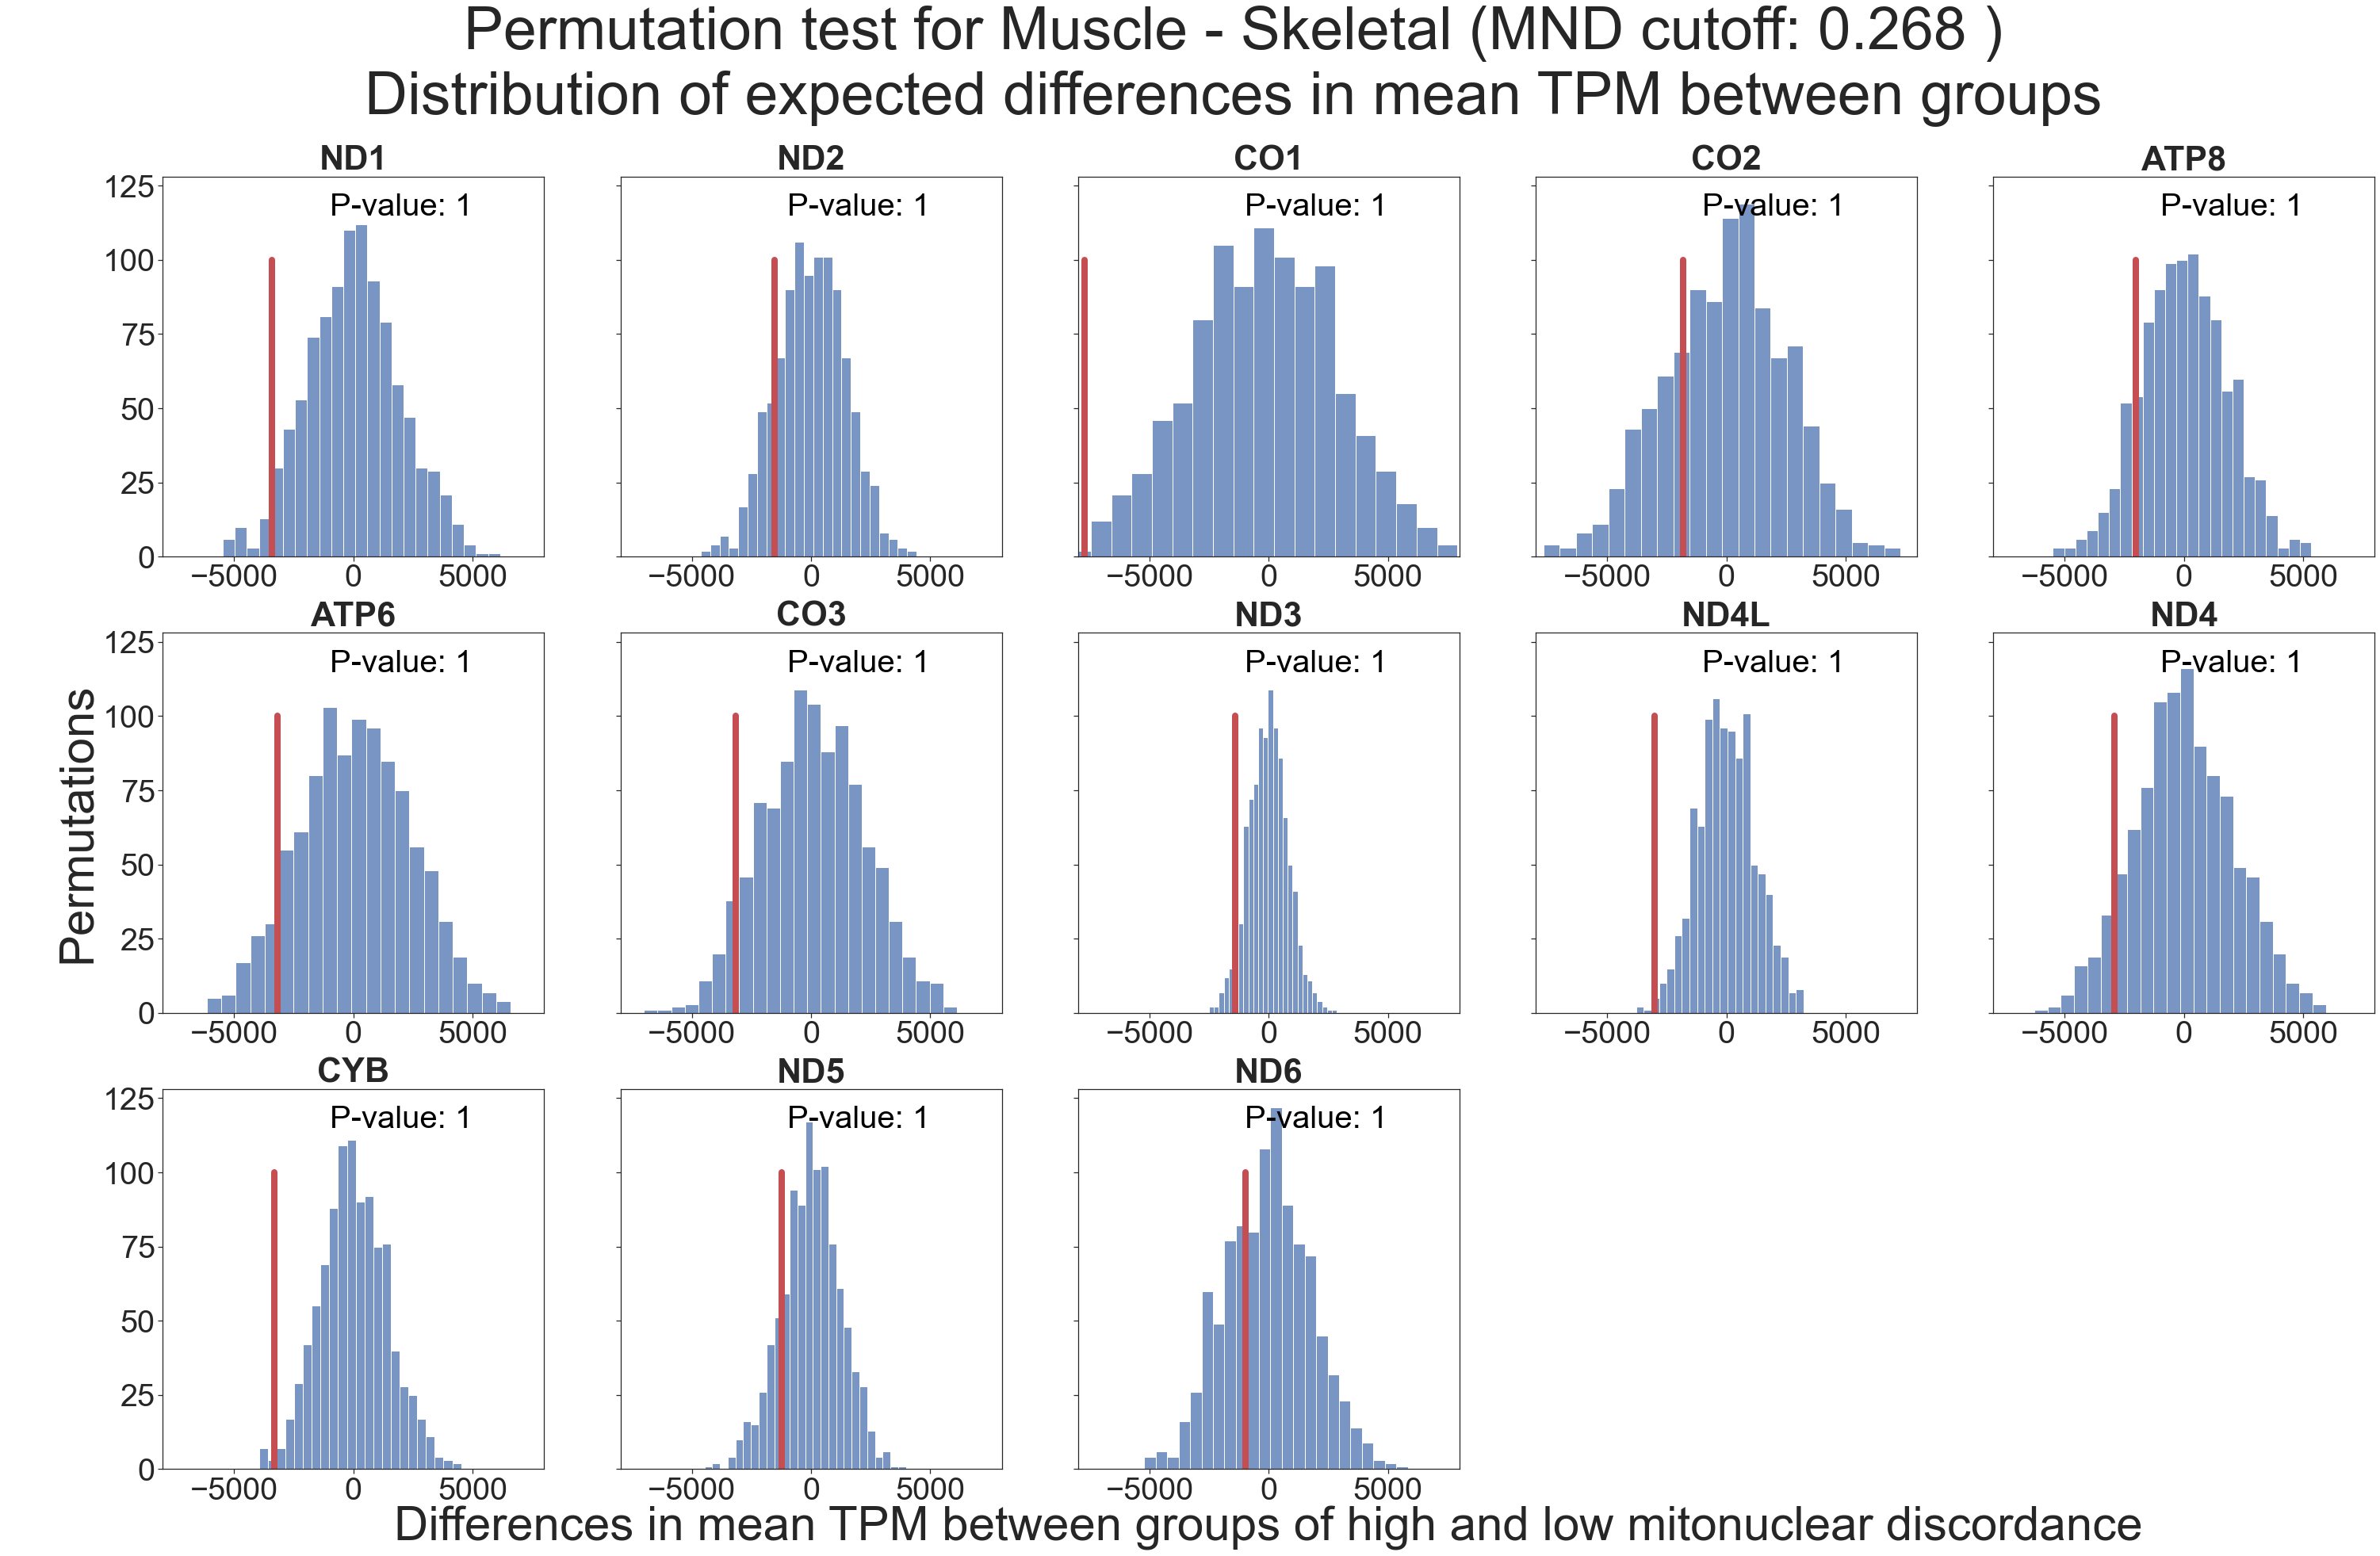

In [43]:
# Permutation with just AfAm (no EuAM because most MND values are near 0).
df_tpm_v8_ann_K2_afam = df_tpm_v8_ann_K2[df_tpm_v8_ann_K2['self_rep_race']=='AfAm']
df_tpm_v8_ann_K2_afam.name = 'df_tpm_v8_ann_K2_afam'
subplot_perm(df_tpm_v8_ann_K2_afam,'Muscle - Skeletal','mean',list_mtdna)

In [44]:
df_tpm_v8_ann_K2_afam[(df_tpm_v8_ann_K2_afam['Tissue']=='Muscle - Skeletal')&(df_tpm_v8_ann_K2_afam['Gene']=='ND1')]#['short_ID'].sort_values()

Gene                   GTEX_ID      TPM    short_ID self_rep_race  \
13      ND1  GTEX-1117F-0426-SM-5EGHI  38030.0  GTEX-1117F          AfAm   
2886    ND1  GTEX-11DXZ-2426-SM-5N9DT  34210.0  GTEX-11DXZ          AfAm   
7111    ND1  GTEX-11NV4-0326-SM-5HL58  39620.0  GTEX-11NV4          AfAm   
8489    ND1  GTEX-11P7K-1926-SM-5GU6R  29050.0  GTEX-11P7K          AfAm   
9256    ND1  GTEX-11PRG-0326-SM-5GU53  21710.0  GTEX-11PRG          AfAm   
10166   ND1  GTEX-11UD1-0326-SM-5EQKX  14700.0  GTEX-11UD1          AfAm   
10881   ND1  GTEX-11WQC-2626-SM-5CVLF  20070.0  GTEX-11WQC          AfAm   
13130   ND1  GTEX-12126-0526-SM-5PNW4  19860.0  GTEX-12126          AfAm   
15106   ND1  GTEX-12WSD-0526-SM-5EQ6F  24590.0  GTEX-12WSD          AfAm   
19409   ND1  GTEX-13113-5019-SM-7EPH2  16100.0  GTEX-13113          AfAm   
20072   ND1  GTEX-131XE-2726-SM-5P9G7  27360.0  GTEX-131XE          AfAm   
20982   ND1  GTEX-131XH-2726-SM-5GCO2  23650.0  GTEX-131XH          AfAm   
27729   ND1  GTEX-13FHP-0526-SM-5K7UY  24960.0  GTEX-13FHP          AfAm   
29224   ND1  GTEX-13FXS-0326-SM-5K7TV  20800.0  GTEX-13FXS          AfAm   
29991   ND1  GTEX-13JUV-2326-SM-5IJCE  28580.0  GTEX-13JUV          AfAm   
30615   ND1  GTEX-13N11-2726-SM-5L3ER  19080.0  GTEX-13N11          AfAm   
31629   ND1  GTEX-13NYB-2726-SM-5J2MT  19930.0  GTEX-13NYB          AfAm   
34021   ND1  GTEX-13OVI-1726-SM-5L3DW  22260.0  GTEX-13OVI          AfAm   
39637   ND1  GTEX-13SLX-0326-SM-5Q5E4  24170.0  GTEX-13SLX          AfAm   
40183   ND1  GTEX-13VXT-0326-SM-5LU4U  25360.0  GTEX-13VXT          AfAm   
42354   ND1  GTEX-13YAN-0526-SM-5O9BE  29350.0  GTEX-13YAN          AfAm   
43914   ND1  GTEX-145MG-0226-SM-5TDDB  23940.0  GTEX-145MG          AfAm   
44603   ND1  GTEX-145MN-2426-SM-5NQA5  22560.0  GTEX-145MN          AfAm   
47281   ND1  GTEX-1497J-2626-SM-5SI9K  40750.0  GTEX-1497J          AfAm   
47996   ND1  GTEX-14ASI-0526-SM-5QGQP  28870.0  GTEX-14ASI          AfAm   
51246   ND1  GTEX-14E1K-2326-SM-664MP  37610.0  GTEX-14E1K          AfAm   
59150   ND1  GTEX-15DDE-0526-SM-6ETZQ  19890.0  GTEX-15DDE          AfAm   
62192   ND1  GTEX-15RJ7-2426-SM-6M48L  41030.0  GTEX-15RJ7          AfAm   
62725   ND1  GTEX-15SDE-2326-SM-6PAL4  31360.0  GTEX-15SDE          AfAm   
63258   ND1  GTEX-15SHW-0726-SM-7KUEI  28320.0  GTEX-15SHW          AfAm   
65364   ND1  GTEX-16NGA-1926-SM-7LTA6  24030.0  GTEX-16NGA          AfAm   
74204   ND1  GTEX-18QFQ-0326-SM-731C3  40210.0  GTEX-18QFQ          AfAm   
78442   ND1  GTEX-1AYD5-2226-SM-73KX3  22570.0  GTEX-1AYD5          AfAm   
83122   ND1  GTEX-1C64O-0326-SM-73KVW  19700.0  GTEX-1C64O          AfAm   
88387   ND1  GTEX-1EMGI-0326-SM-9MQM5  32100.0  GTEX-1EMGI          AfAm   
91039   ND1  GTEX-1F6I4-0326-SM-7P8T8  19100.0  GTEX-1F6I4          AfAm   
92196   ND1  GTEX-1F75I-0526-SM-7RHI3  36130.0  GTEX-1F75I          AfAm   
94822   ND1  GTEX-1GMR2-2126-SM-7P8TX  39880.0  GTEX-1GMR2          AfAm   
98527   ND1  GTEX-1GZ4H-1626-SM-7PC3F  37010.0  GTEX-1GZ4H          AfAm   
102180  ND1  GTEX-1JMLX-0326-SM-CM2RP  24960.0  GTEX-1JMLX          AfAm   
102830  ND1  GTEX-1JMPY-1226-SM-CJI3A  42150.0  GTEX-1JMPY          AfAm   
102934  ND1  GTEX-1JMPZ-0126-SM-CNPOZ  26120.0  GTEX-1JMPZ          AfAm   
103948  ND1  GTEX-1JMQL-0126-SM-CY8HN  21680.0  GTEX-1JMQL          AfAm   
105872  ND1  GTEX-1KANB-0126-SM-E6CJT  22140.0  GTEX-1KANB          AfAm   
106262  ND1  GTEX-1KANC-1626-SM-E6CIA  37930.0  GTEX-1KANC          AfAm   
107991  ND1  GTEX-1LBAC-0326-SM-DIPF1  33010.0  GTEX-1LBAC          AfAm   
111904  ND1  GTEX-1MCC2-2726-SM-EWRN3  23910.0  GTEX-1MCC2          AfAm   
112931  ND1  GTEX-1N2DV-0526-SM-DTX8W  24090.0  GTEX-1N2DV          AfAm   
113750  ND1  GTEX-1NHNU-1226-SM-DTX8I  37960.0  GTEX-1NHNU          AfAm   
116974  ND1  GTEX-1PPH8-0326-SM-E76PR  16980.0  GTEX-1PPH8          AfAm   
117650  ND1  GTEX-1QCLY-0426-SM-E8VOH  35350.0  GTEX-1QCLY          AfAm   
124319  ND1  GTEX-1S5ZA-0526-SM-EWRO1  36830.0  GTEX-1S

## mtDNA Haplogroups

In [45]:
def haplo_counts():
    data = df_tpm_v8_ann_K2[['short_ID','self_rep_race','mtDNA_haplo']].drop_duplicates()
    out = pd.DataFrame()
    ## Get total samples.
    ##out = out.append(data['mtDNA_haplo'].value_counts().to_dict(),ignore_index=True)
    for group in ['AfAm','EuAm']:
        # Get the counts of haplogroups per group.
        x = data[data['self_rep_race']==group]['mtDNA_haplo'].value_counts().to_dict()
        out = out.append(x, ignore_index=True)
    # Add label.
    out.index = ['AfAm','EuAm']
    # Transpose.
    out = out.transpose()
    return(out)
    
haplo_counts()

AfAm   EuAm
H   9.0  347.0
L  88.0    6.0
T   1.0   65.0
U   3.0   98.0
I   NaN   13.0
J   NaN   50.0
K   NaN   61.0
V   NaN   22.0
W   NaN   13.0
X   NaN   13.0

## Number of samples per tissue.

In [46]:
def tissue_counts():
    data = df_tpm_v8_ann_K2[['short_ID','self_rep_race','Tissue']].drop_duplicates()
    out = pd.DataFrame()
    ## Get total samples.
    ##out = out.append(data['mtDNA_haplo'].value_counts().to_dict(),ignore_index=True)
    for group in ['AfAm','EuAm']:
        # Get the counts of haplogroups per group.
        x = data[data['self_rep_race']==group]['Tissue'].value_counts().to_dict()
        out = out.append(x, ignore_index=True)
    # Add label.
    out.index = ['AfAm','EuAm']
    # Filter tissues.
    #list_tissue = 
    out = out[list_tissue]
    # Transpose.
    out = out.transpose()
    # Add a column with total number per tissue.
    out['Total'] = out['AfAm'] + out['EuAm']
    # Sorted by total.
    out = out.sort_values('Total', ascending=False)
    return(out)

tissue_counts()

AfAm   EuAm  Total
Muscle - Skeletal         85.0  580.0  665.0
Whole Blood               79.0  550.0  629.0
Artery - Tibial           75.0  471.0  546.0
Nerve - Tibial            66.0  431.0  497.0
Esophagus - Muscularis    54.0  379.0  433.0
Heart - Left Ventricle    42.0  321.0  363.0
Heart - Atrial Appendage  41.0  311.0  352.0

In [47]:
pd.DataFrame(df_tpm_v8_ann_K2[['short_ID','self_rep_race']].drop_duplicates()['self_rep_race'].value_counts())

self_rep_race
EuAm            688
AfAm            101

In [48]:
test=df_tpm_v8_ann_K2[df_tpm_v8_ann_K2['self_rep_race']=='EuAm'][['short_ID','self_rep_race','mito_haplo','mitonucl_discord']].drop_duplicates()
#test[test['mitonucl_discord']>0.04].sort_values('mitonucl_discord')
test['mitonucl_discord'].var()

0.007998670684700579

# Global ancestry

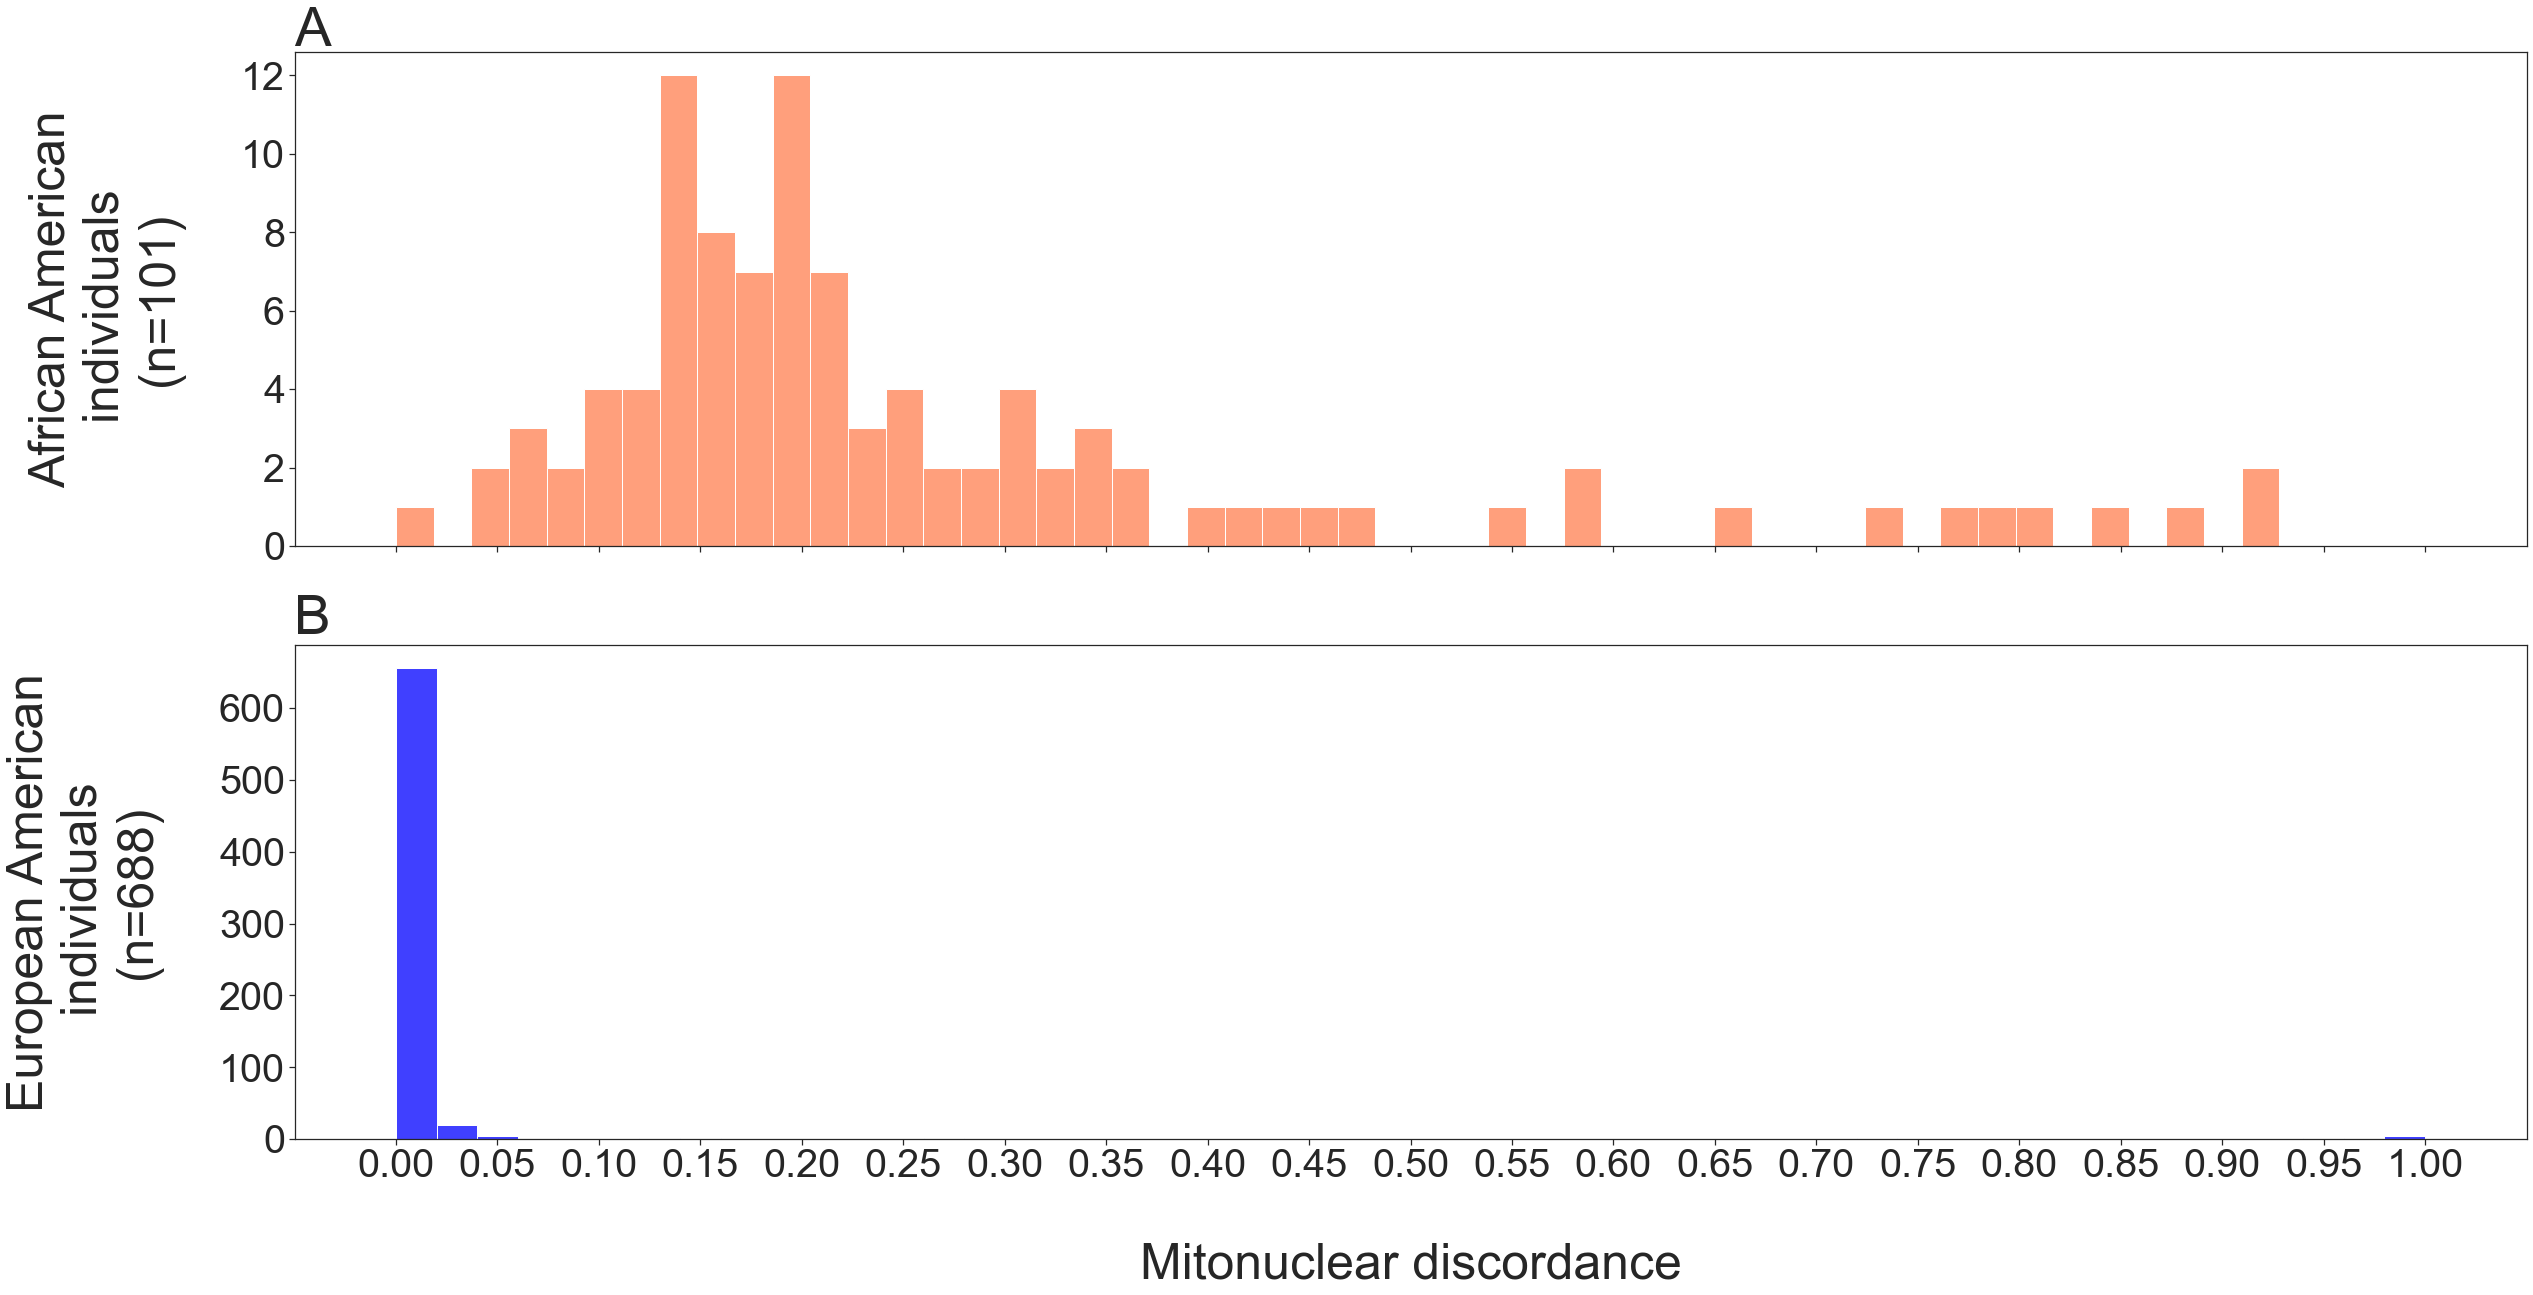

In [49]:
def hist_mnd_hor():
    # Multiple plots / Subplotting.  (https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8)
    fig, axes = plt.subplots(1,3, figsize=(40,10), sharex=True, sharey=True)
    #fig.suptitle('Histogram of mitonuclear discordance values in Skeletal muscle samples' , size=70)
    sns.set(rc={'figure.figsize':(20,20)},font_scale=3)
    sns.set_style("ticks")

    data = df_tpm_v8_ann_K2[['short_ID','self_rep_race','mitonucl_discord']].drop_duplicates()
    sns.histplot( data['mitonucl_discord'] , color='orange', bins=50, binwidth=.03, ax=axes[0] )
    sns.histplot( data[data['self_rep_race']=='EuAm']['mitonucl_discord'] , color='blue', bins=50, binwidth=.03, ax=axes[1] )
    sns.histplot( data[data['self_rep_race']=='AfAm']['mitonucl_discord'] , color='coral', bins=50, binwidth=.03, ax=axes[2] )
    axes[0].set_xlabel('Mitonuclear discordance')
    axes[1].set_xlabel('Mitonuclear discordance')
    axes[2].set_xlabel('Mitonuclear discordance')
    axes[0].set_ylabel('Number of individuals')
    axes[1].set_ylabel('')
    axes[2].set_ylabel('')
    axes[0].set_title('Mitonuclear discordance\nof all samples', size=55 )
    axes[1].set_title('Mitonuclear discordance\nof European American samples', size=55 )
    axes[2].set_title('Mitonuclear discordance\nof African American samples', size=55 )
    
def hist_mnd_vert():
    # Multiple plots / Subplotting.  (https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8)
    fig, axes = plt.subplots(2,1, figsize=(40,20), sharex=True, sharey=False)
    #fig.suptitle('Histogram of mitonuclear discordance values in Skeletal muscle samples' , size=70)
    sns.set(rc={'figure.figsize':(20,20)},font_scale=3)
    sns.set_style("ticks")
    
    data = df_tpm_v8_ann_K2[['short_ID','self_rep_race','mitonucl_discord']].drop_duplicates()
    sns.histplot( data[data['self_rep_race']=='AfAm']['mitonucl_discord'] , 
                 color='coral', bins=50, ax=axes[0] )
    sns.histplot( data[data['self_rep_race']=='EuAm']['mitonucl_discord'] , 
                 color='blue', bins=50, ax=axes[1] )

    plt.xticks(np.arange(0, 1.05, 0.05))
    
    no_eu = data[data['self_rep_race']=='EuAm'].shape[0]
    no_af = data[data['self_rep_race']=='AfAm'].shape[0]
    
    axes[1].set_ylabel('European American\nindividuals \n(n='+str(no_eu)+')\n', size=50)
    axes[0].set_ylabel('African American\nindividuals \n(n='+str(no_af)+')\n', size=50)
    axes[1].set_xlabel('\nMitonuclear discordance', size=50)
    axes[0].set_xlabel('\nMitonuclear discordance', size=50)
    #axes[1].set_title('Mitonuclear discordance of European American samples', size=55 )
    #axes[0].set_title('Mitonuclear discordance of African American samples', size=55 )
    axes[0].set_title('A', size=55, loc='left' )
    axes[1].set_title('B', size=55, loc='left' )

    

#hist_mnd_hor()
hist_mnd_vert()

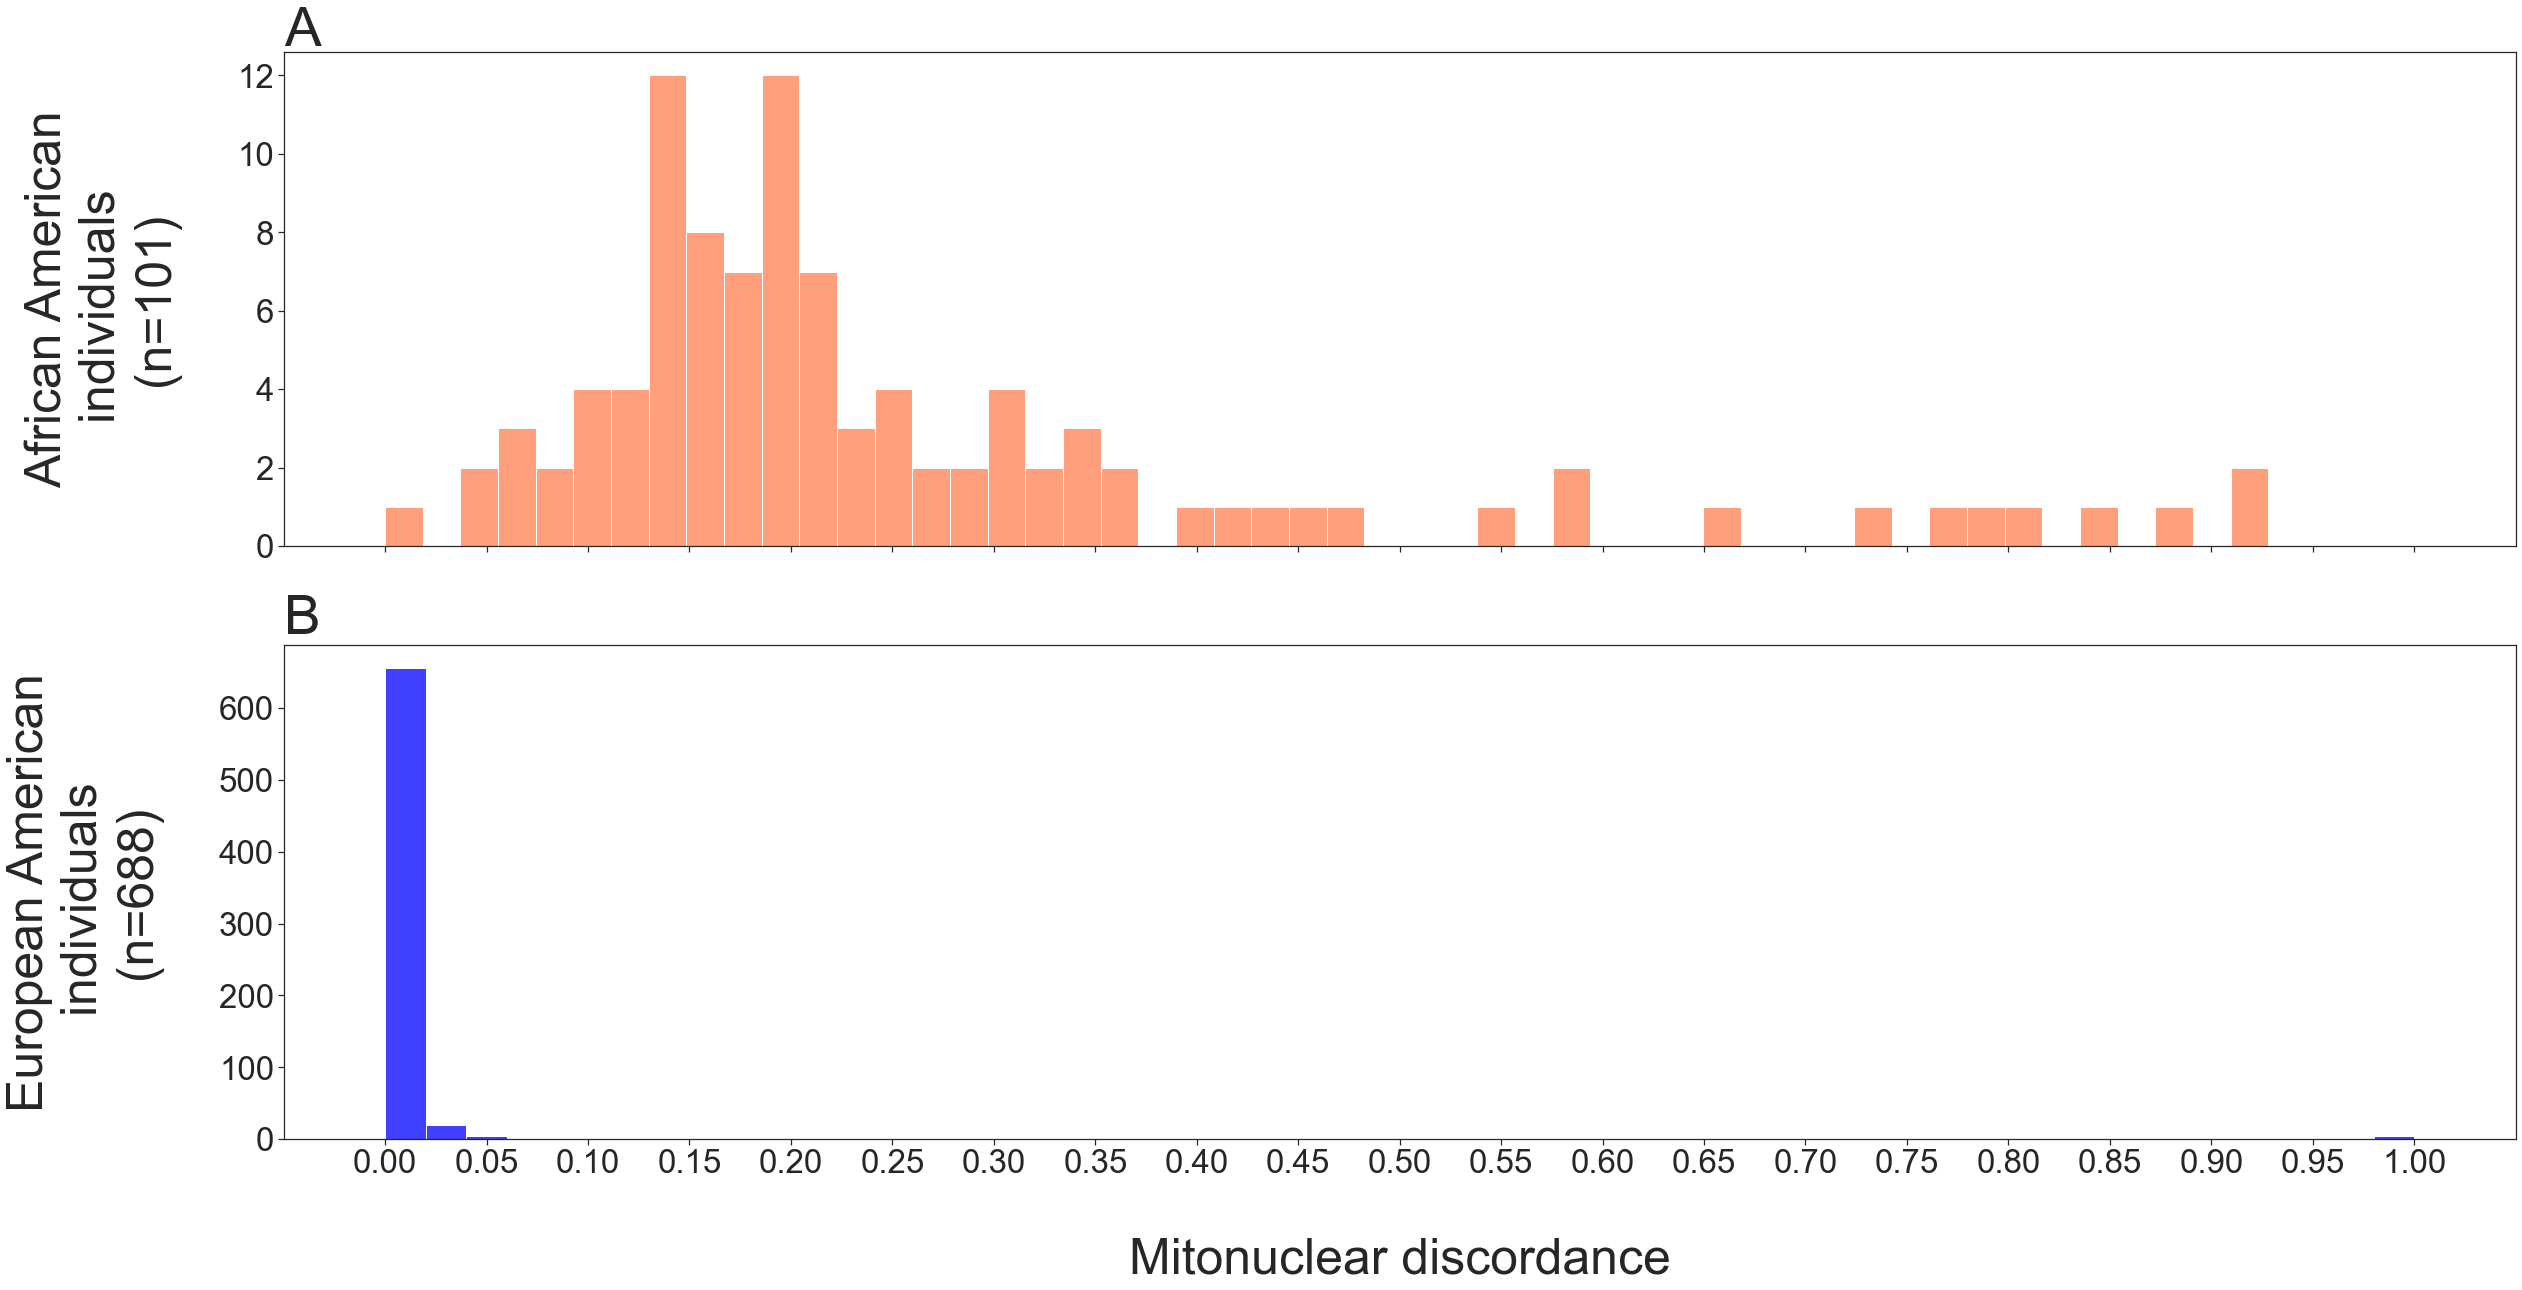

In [50]:
hist_mnd_vert()

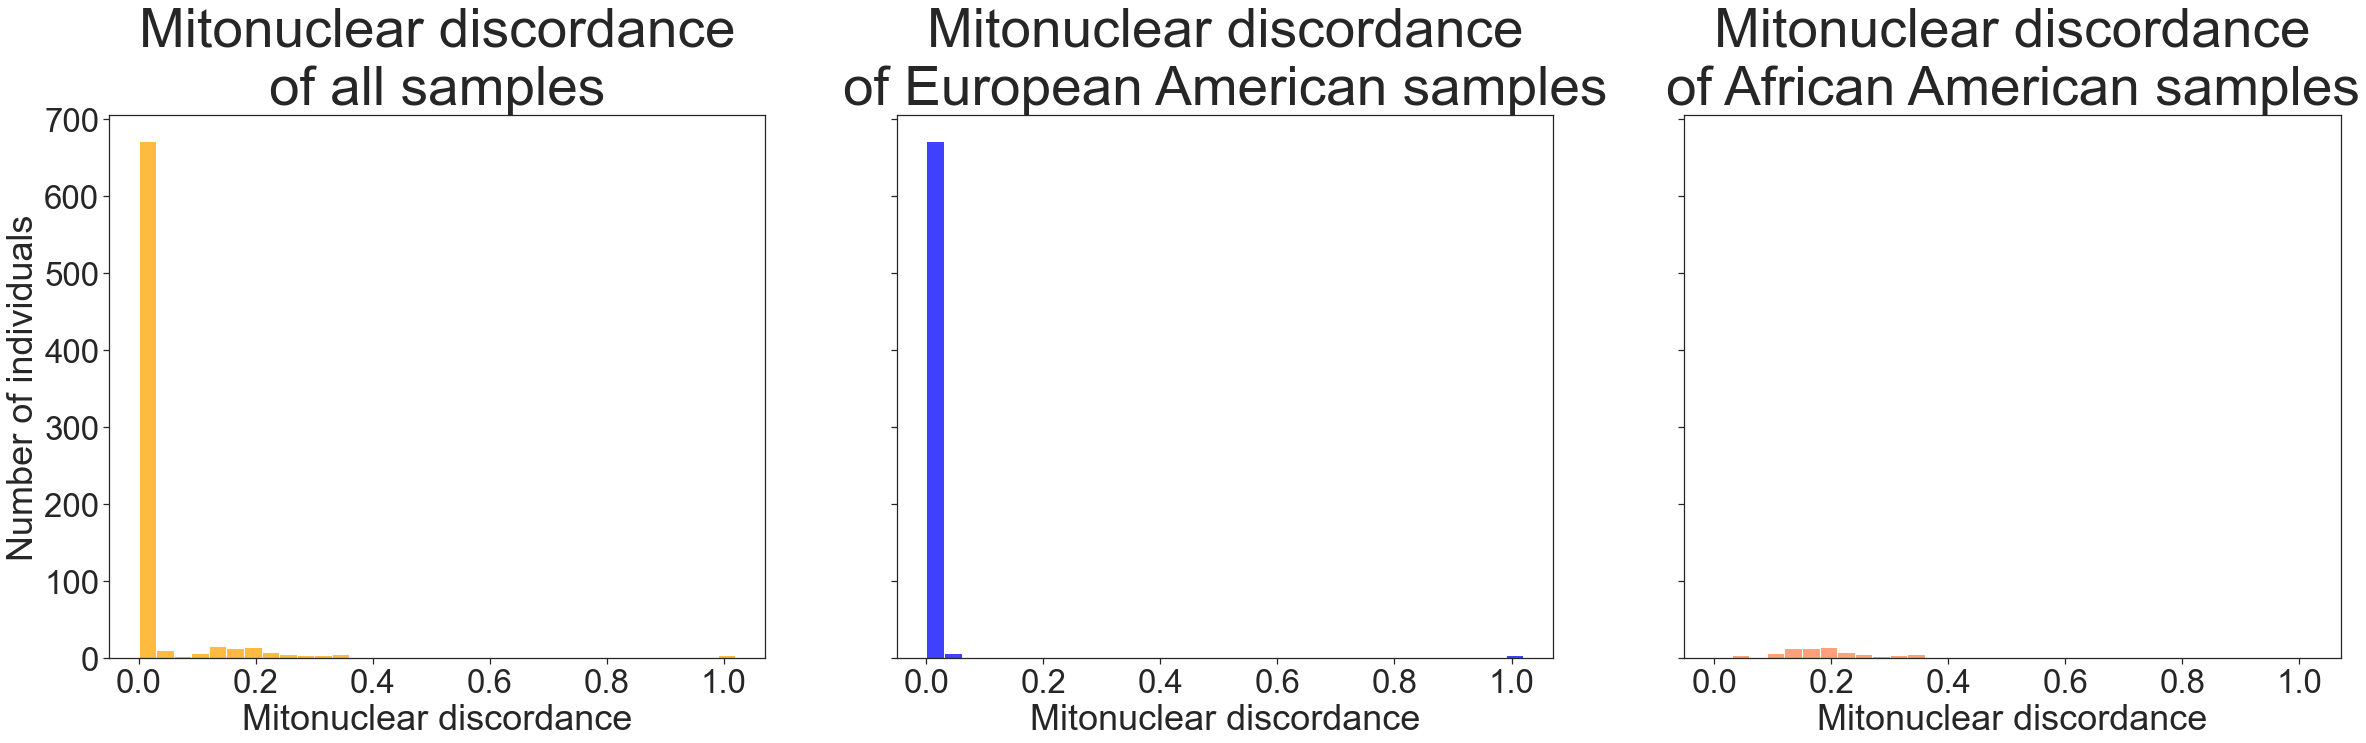

In [51]:
hist_mnd_hor()

# Local ancestry
- RFMix manual: https://github.com/slowkoni/rfmix/blob/master/MANUAL.md
- Main output: 
    - The most likely assignment of subpopulations per CRF point (<output basename>.msp.tsv).
    - Marginal probabilities of each subpopulation being the ancestral population of the corresponding CRF point (<output basename>.fb.tsv).
        - Zaidi & Makova 2019 used 0.9 posterior prob cutoff for local ancestry estimations.
    - Both output files are tab separated values forming a matrix with rows corresponding to genomic position and columns corresponding to haplotypes (id.0 , id.1).
- Other output:
    - Global diploid ancestry estimates are computed by RFMIX and output to <output basename>.rfmix.Q
    


In [52]:
%%bash
# Most likely assignment of subpopulations.
head -n4 ../data/2021-05-10/rfmixout/rfmixout.13.msp.tsv | cut -f1,2,3,4,5,6,7,8,9,10

# Marginal probabilities of each subpopulation being the ancestral pop.
head -n4 ../data/2021-05-10/rfmixout/rfmixout.13.fb.tsv | cut -f1,2,3,4,5,6,7,8,9,10

# The global ancestry estimates by chromosome provided by RFMix (per individual).
head ../data/2021-05-10/rfmixout/rfmixout.13.rfmix.Q | column -t
ls ../data/2021-05-10/rfmixout/*Q

head ../data/2021-05-10/rfmixout/*22*sis* | cut -f1,2,3,4,5,6

#Subpopulation order/codes: CEU=0	YRI=1
#chm	spos	epos	sgpos	egpos	n snps	GTEX-1117F.0	GTEX-1117F.1	GTEX-111CU.0	GTEX-111CU.1
13	19174634	19634794	0.25	0.86	92	0	1	1	0
13	19634794	19732049	0.86	1.02	30	0	1	1	0
#reference_panel_population:	CEU	YRI
chromosome	physical_position	genetic_position	genetic_marker_index	GTEX-1117F:::hap1:::CEU	GTEX-1117F:::hap1:::YRI	GTEX-1117F:::hap2:::CEU	GTEX-1117F:::hap2:::YRI	GTEX-111CU:::hap1:::CEU	GTEX-111CU:::hap1:::YRI
13	19174634	0.25147	0	1.00000	0.00000	0.00000	1.00000	0.00000	1.00000
13	19264827	0.41475	5	1.00000	0.00000	0.00000	1.00000	0.00000	1.00000
#rfmix      diploid  global   ancestry  .Q  format  output
#sample     CEU      YRI
GTEX-1117F  0.20347  0.79653
GTEX-111CU  0.97393  0.02607
GTEX-111FC  0.86094  0.13906
GTEX-111VG  1.00000  0.00000
GTEX-111YS  0.99333  0.00667
GTEX-1122O  1.00000  0.00000
GTEX-1128S  0.99733  0.00267
GTEX-113IC  0.63612  0.36388
../data/2021-05-10/rfmixout/rfmixout.1.rfmix.Q
../data/2021-05-10/rfmixout/rfmixout.10

('Pearson correlation (European): ',
 (0.9998766016029708, 0.0),
 'Pearson correlation (African): ',
 (0.999876601602971, 0.0))

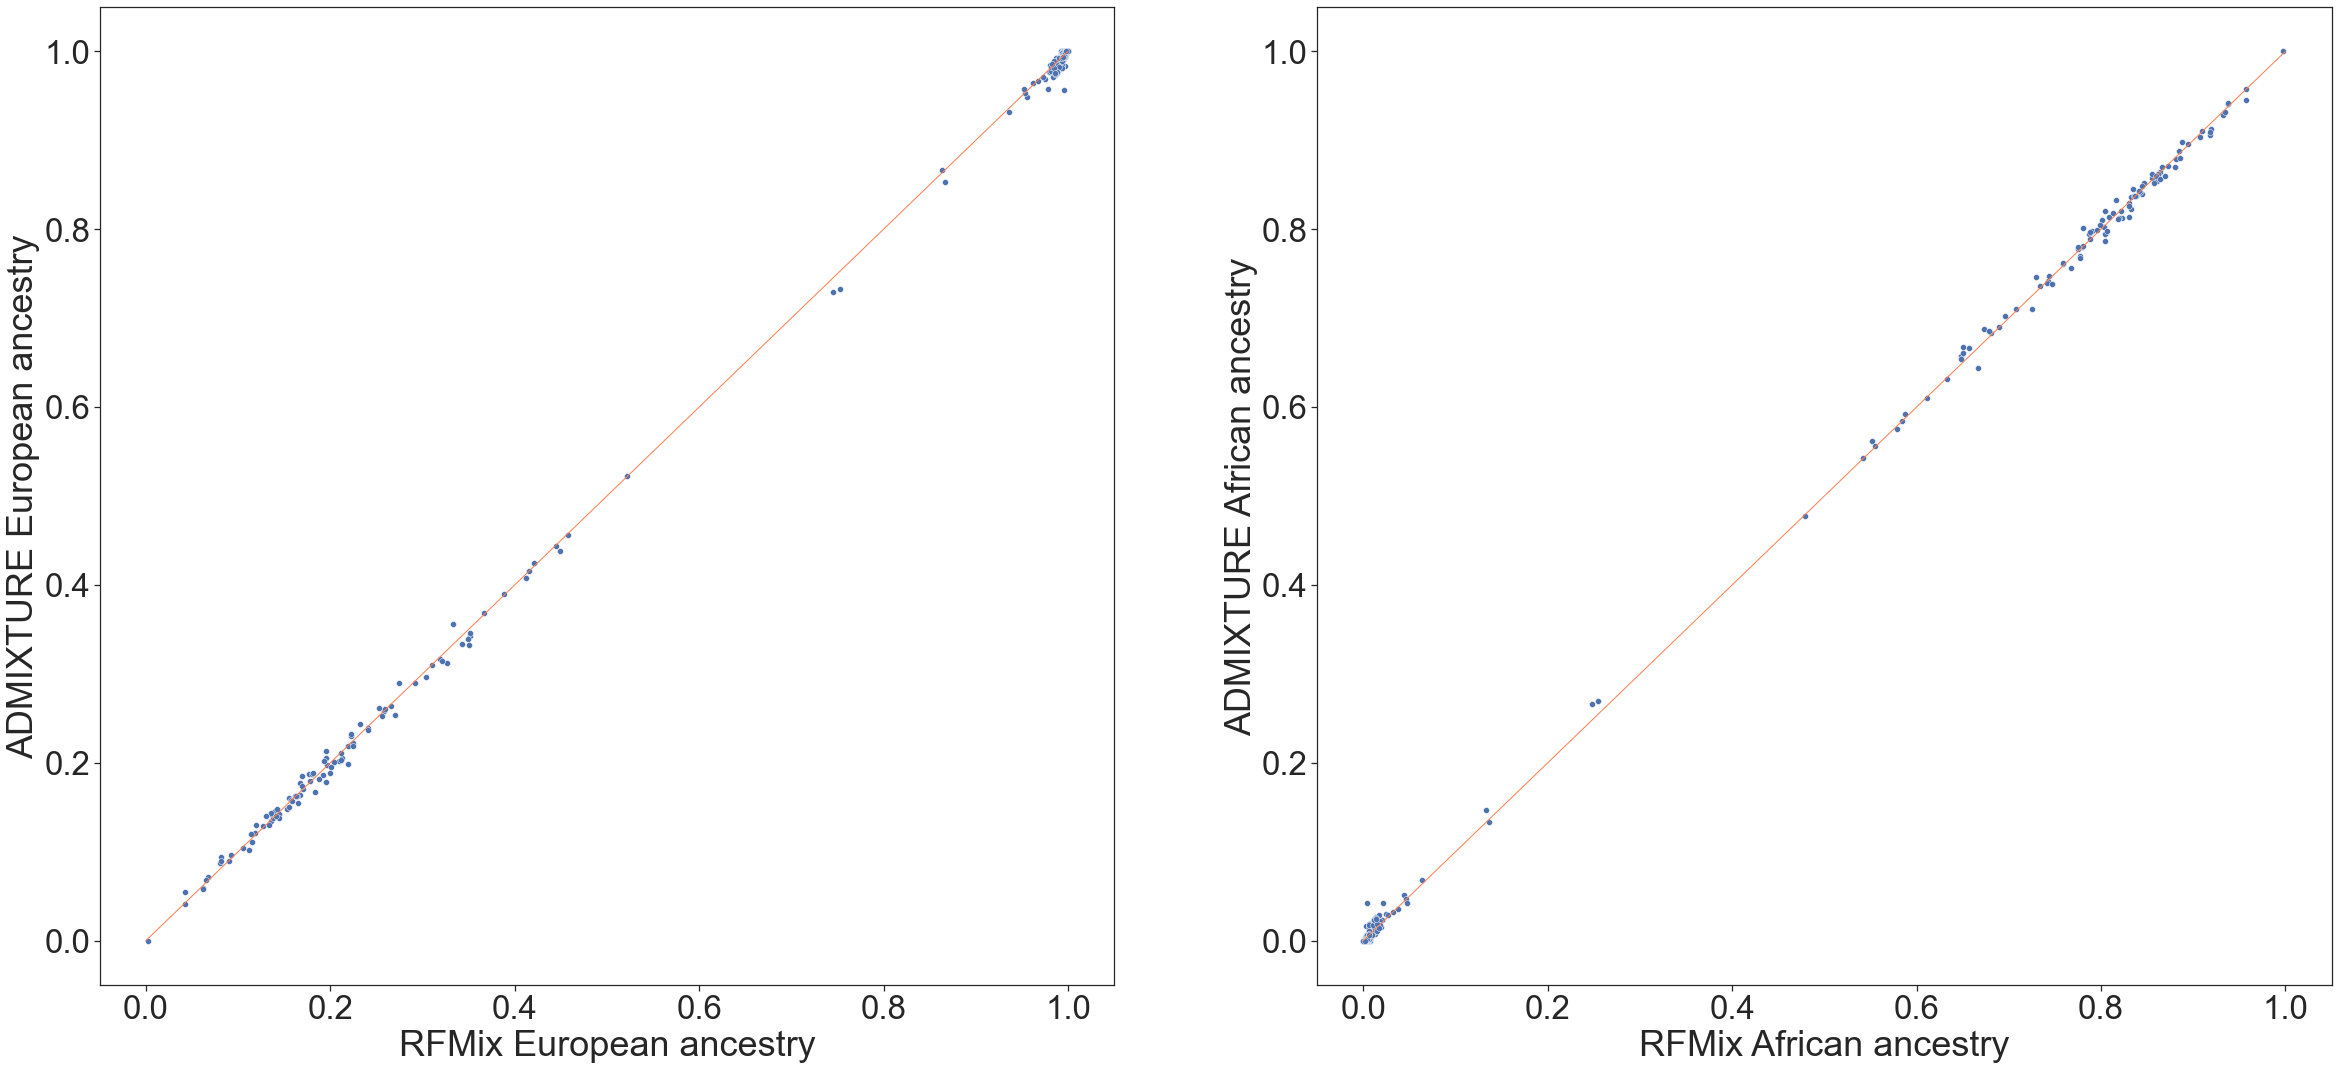

In [53]:
def concat_Qfiles():
    out = pd.DataFrame()
    # Concatenate files with global ancestry estimates at the chromosome-level.
    for CHR in range(1,23):
        one_chr = pd.read_table('../data/2021-05-10/rfmixout/rfmixout.'+str(CHR)+'.rfmix.Q', skiprows=1)
        one_chr.rename(columns={'#sample':'Sample'}, inplace=True)
        # Create a column with the chromosome number for these ancestry estimates.
        one_chr['Chr'] = CHR
        out = out.append(one_chr)
    return(out)


def chr_len_to_prop():
    # The chromosome lengths for GRCh37 / hg19. (https://www.ncbi.nlm.nih.gov/grc/human/data?asm=GRCh37) 
    dict_grch37_chr_len = {'1':249250621, '2':243199373, '3':198022430, '4':191154276, '5':180915260, '6':171115067, '7':159138663, '8':146364022, '9':141213431, '10':135534747, '11':135006516, '12':133851895, '13':115169878, '14':107349540, '15':102531392, '16':90354753, '17':81195210, '18':78077248, '19':59128983, '20':63025520, '21':48129895, '22':51304566}
    # Total genome size.
    total_length = sum( dict_grch37_chr_len.values() )
    # Divide the chromsome lengths by the total genome size.
    dict_grch37_chr_prop = {CHR: int(length)/int(total_length) for CHR,length in dict_grch37_chr_len.items()}
    return(dict_grch37_chr_prop)


def rfmix_chr_to_global():
    # The chromosome-level diploid ancestry values.
    all_chr = concat_Qfiles()
    # The weights/proportions for each chromosome.
    dict_grch37_chr_prop = chr_len_to_prop()
    # Weigh the chromosome ancestries with genome-level chrom size proportions.
    out_weighted = pd.DataFrame()
    for CHR in range(1,23):
        weight = dict_grch37_chr_prop[str(CHR)]
        chr_ancestry = all_chr[all_chr['Chr']==CHR][['CEU','YRI']]#.reset_index(drop=True,inplace=True)
        weighted_chr_anc = weight*chr_ancestry
        # Compile the weighted values per chromosome.
        out_weighted = out_weighted.append(weighted_chr_anc)
    all_chr['CEU_weighted'] = out_weighted['CEU']
    all_chr['YRI_weighted'] = out_weighted['YRI']
    #return(all_chr)
    # Combine scores for all chromosomes to get global ancestry.
    out_global = pd.DataFrame()
    for sample in all_chr['Sample'].drop_duplicates():
        data = all_chr[all_chr['Sample']==sample]
        out_global = out_global.append( pd.DataFrame(data={'short_ID':[sample], 'RFMix European ancestry':[sum(data['CEU_weighted'])], 'RFMix African ancestry':[sum(data['YRI_weighted'])]}) )
        #return( pd.DataFrame(data=[sample, sum(data['CEU_weighted']), sum(data['YRI_weighted'])]) )
        #out_global = out_global.append( (sample, sum(data['CEU_weighted']), sum(data['YRI_weighted'])) )
    return(out_global.reset_index(drop=True))


def rfmix_admixture():
    # Join ADMIXTURE and RFMix results.
    df_ADMIXTURE = df_tpm_v8_ann_K2[['short_ID','global_eu','global_af']].drop_duplicates().reset_index(drop=True)
    df_RFMIX = rfmix_chr_to_global()
    df_GLOBAL = pd.merge(df_ADMIXTURE,df_RFMIX, on=['short_ID'])
    df_GLOBAL = df_GLOBAL.rename(columns={'global_eu':'ADMIXTURE European ancestry','global_af':'ADMIXTURE African ancestry'})
    return(df_GLOBAL)


def subplot_rfmix_admixture():
    df_GLOBAL = rfmix_admixture()
    # Compare RFMix to ADMIXTURE global ancestry estimates.
    # Scatter plot with 'y=x' line.
    fig, axes = plt.subplots(1,2, figsize=(40,18), sharex=False, sharey=False)
    ax1 = axes[0]
    sns.scatterplot(data=df_GLOBAL, y='ADMIXTURE European ancestry', x='RFMix European ancestry', ax=ax1)
    ax1.plot([0,1],[0,1],linewidth=1, color='coral')
    ax2 = axes[1]
    sns.scatterplot(data=df_GLOBAL, y='ADMIXTURE African ancestry', x='RFMix African ancestry', ax=ax2)
    ax2.plot([0,1],[0,1],linewidth=1, color='coral')
    # Statistics.
    return("Pearson correlation (European): ",stats.pearsonr(df_GLOBAL['RFMix European ancestry'], df_GLOBAL['ADMIXTURE European ancestry']),
           "Pearson correlation (African): ",stats.pearsonr(df_GLOBAL['RFMix African ancestry'], df_GLOBAL['ADMIXTURE African ancestry']))
    

def cv_error_unsup():
    # Dictionary with CV error values.
    dict_cve = {'1':0.40218,'2':0.36557,'3':0.34939,'4':0.34569,'5':0.34238}
    df_cve = pd.DataFrame.from_dict(dict_cve, orient='index').reset_index()
    df_cve.columns = ['K','CVE']
    #return(df_cve)
    # Plot these values.
    sns.scatterplot(data=df_cve, x='K', y='CVE')
    sns.lineplot(data=df_cve, x='K', y='CVE')
    plt.ylabel('Cross validation error\n')
    
def cv_error_sup():
    # Dictionary with CV error values.
    dict_cve = {'1':0.38083,'2':0.34343,'3':0.34396,'4':0.34506}
    df_cve = pd.DataFrame.from_dict(dict_cve, orient='index').reset_index()
    df_cve.columns = ['K','CVE']
    #return(df_cve)
    # Plot these values.
    sns.scatterplot(data=df_cve, x='K', y='CVE')
    sns.lineplot(data=df_cve, x='K', y='CVE')
    plt.ylabel('Cross validation error\n')
    
def cv_error_norefs():
    # Dictionary with CV error values.
    dict_cve = {'1': 0.36013,'2': 0.33831,'3': 0.33902,'4': 0.34172,'5': 0.34254}
    df_cve = pd.DataFrame.from_dict(dict_cve, orient='index').reset_index()
    df_cve.columns = ['K','CVE']
    #return(df_cve)
    # Plot these values.
    sns.scatterplot(data=df_cve, x='K', y='CVE')
    sns.lineplot(data=df_cve, x='K', y='CVE')
    plt.ylabel('Cross validation error\n')

    
    
#concat_Qfiles()
#chr_len_to_prop()
#rfmix_chr_to_global()
subplot_rfmix_admixture()
#cv_error_norefs()

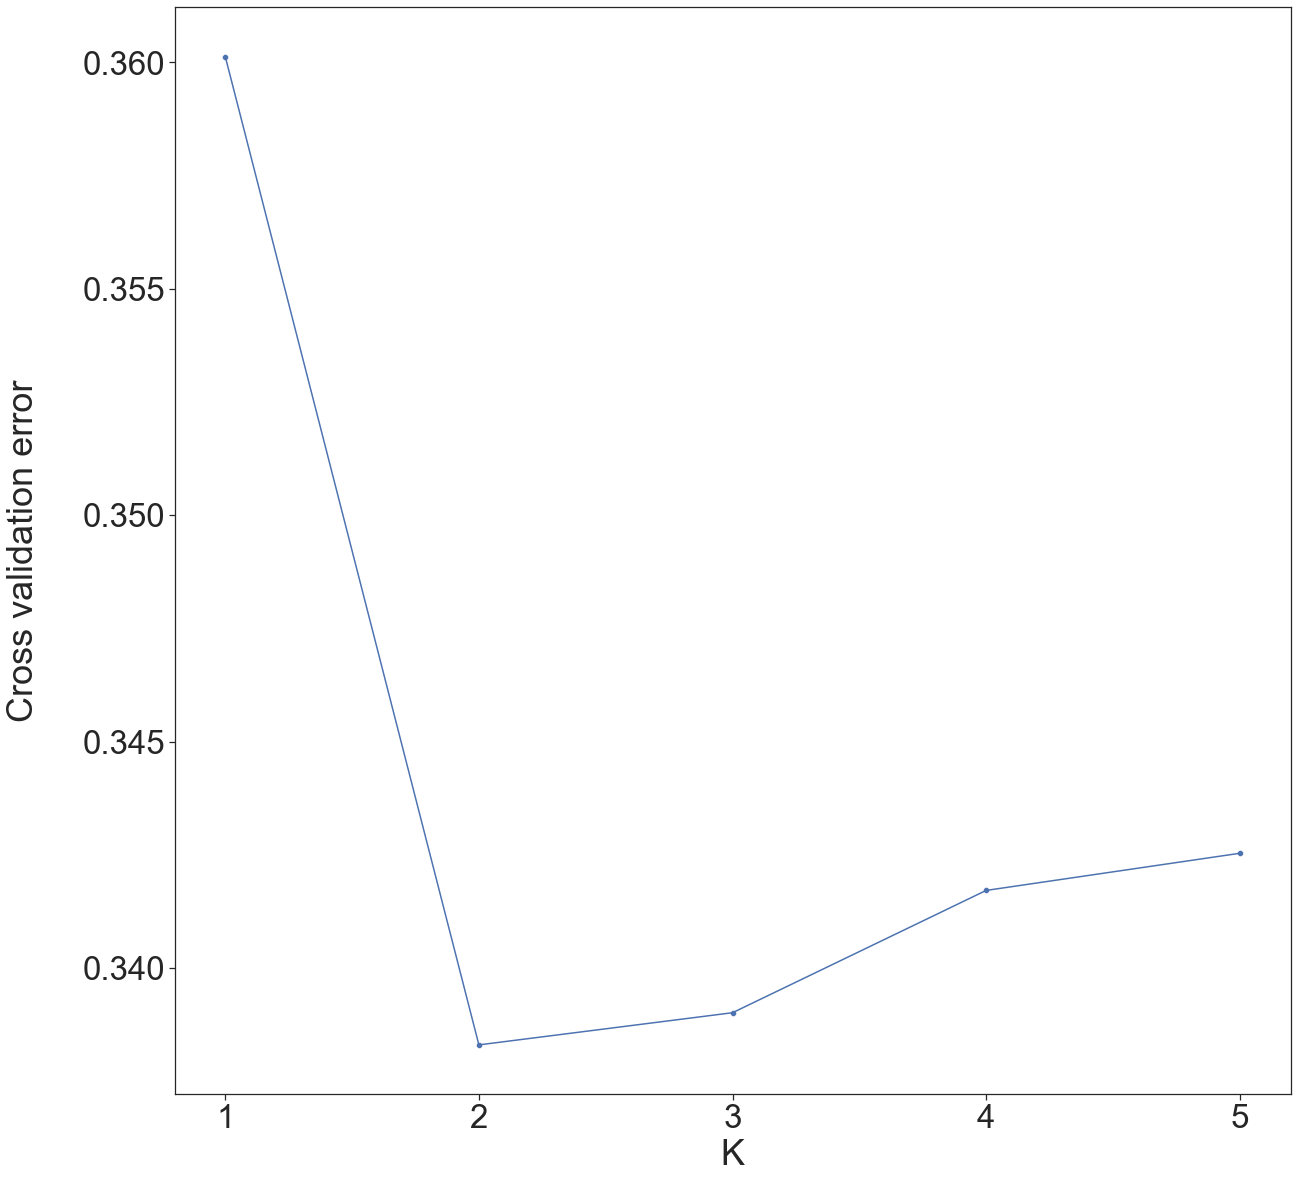

In [54]:
cv_error_norefs()

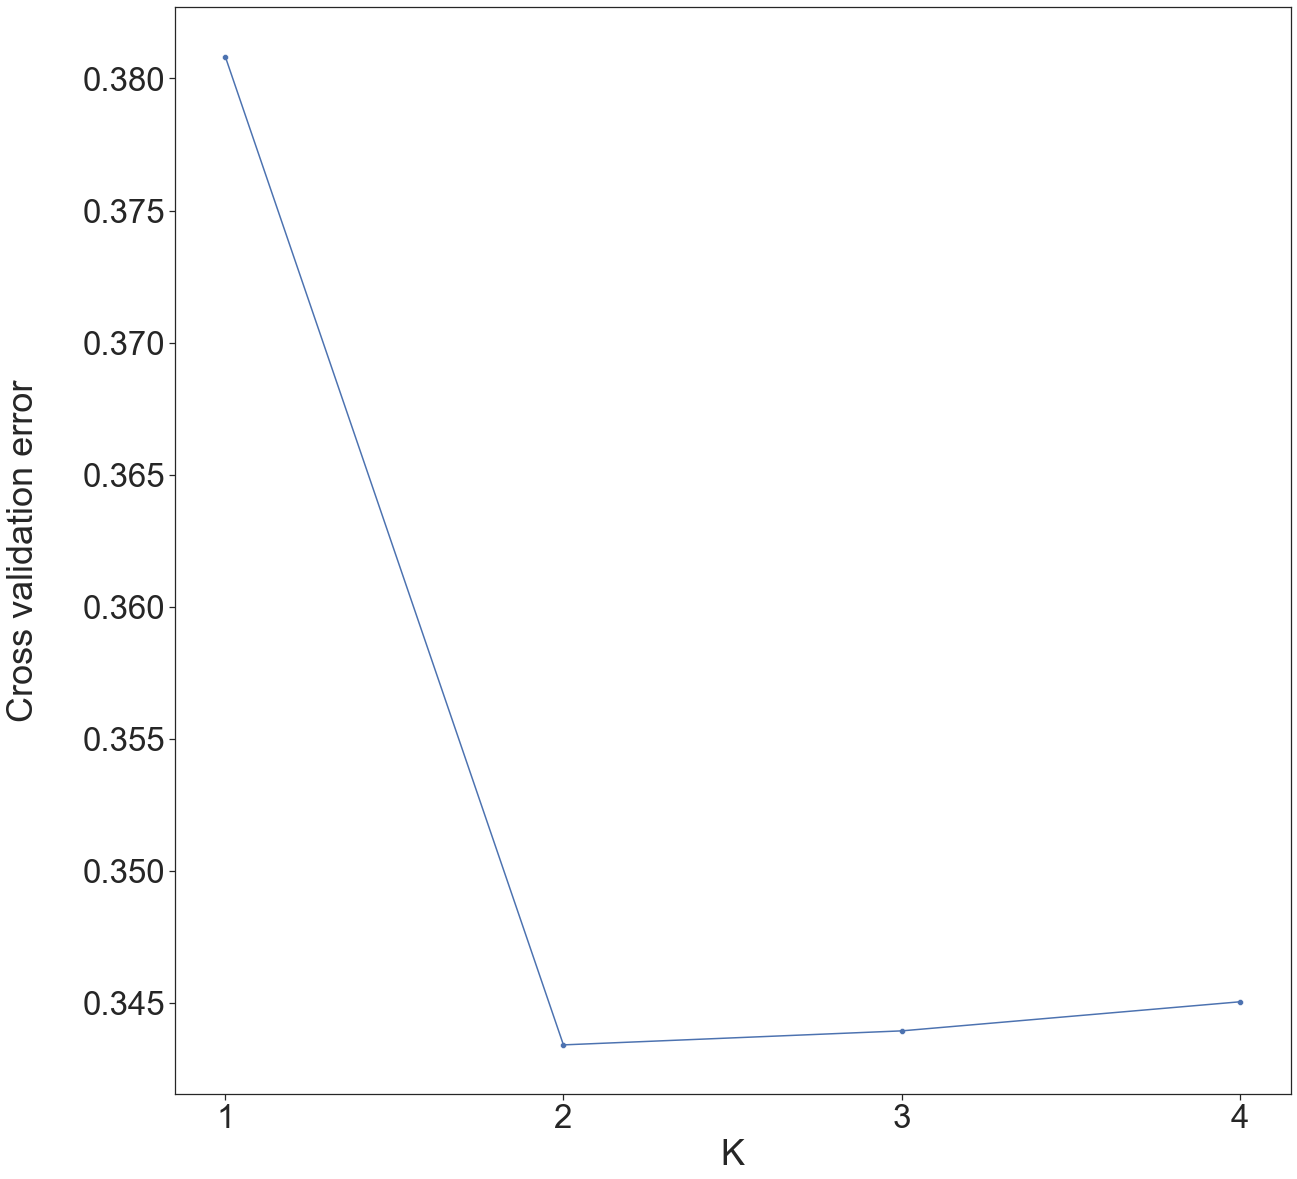

In [55]:
cv_error_sup()

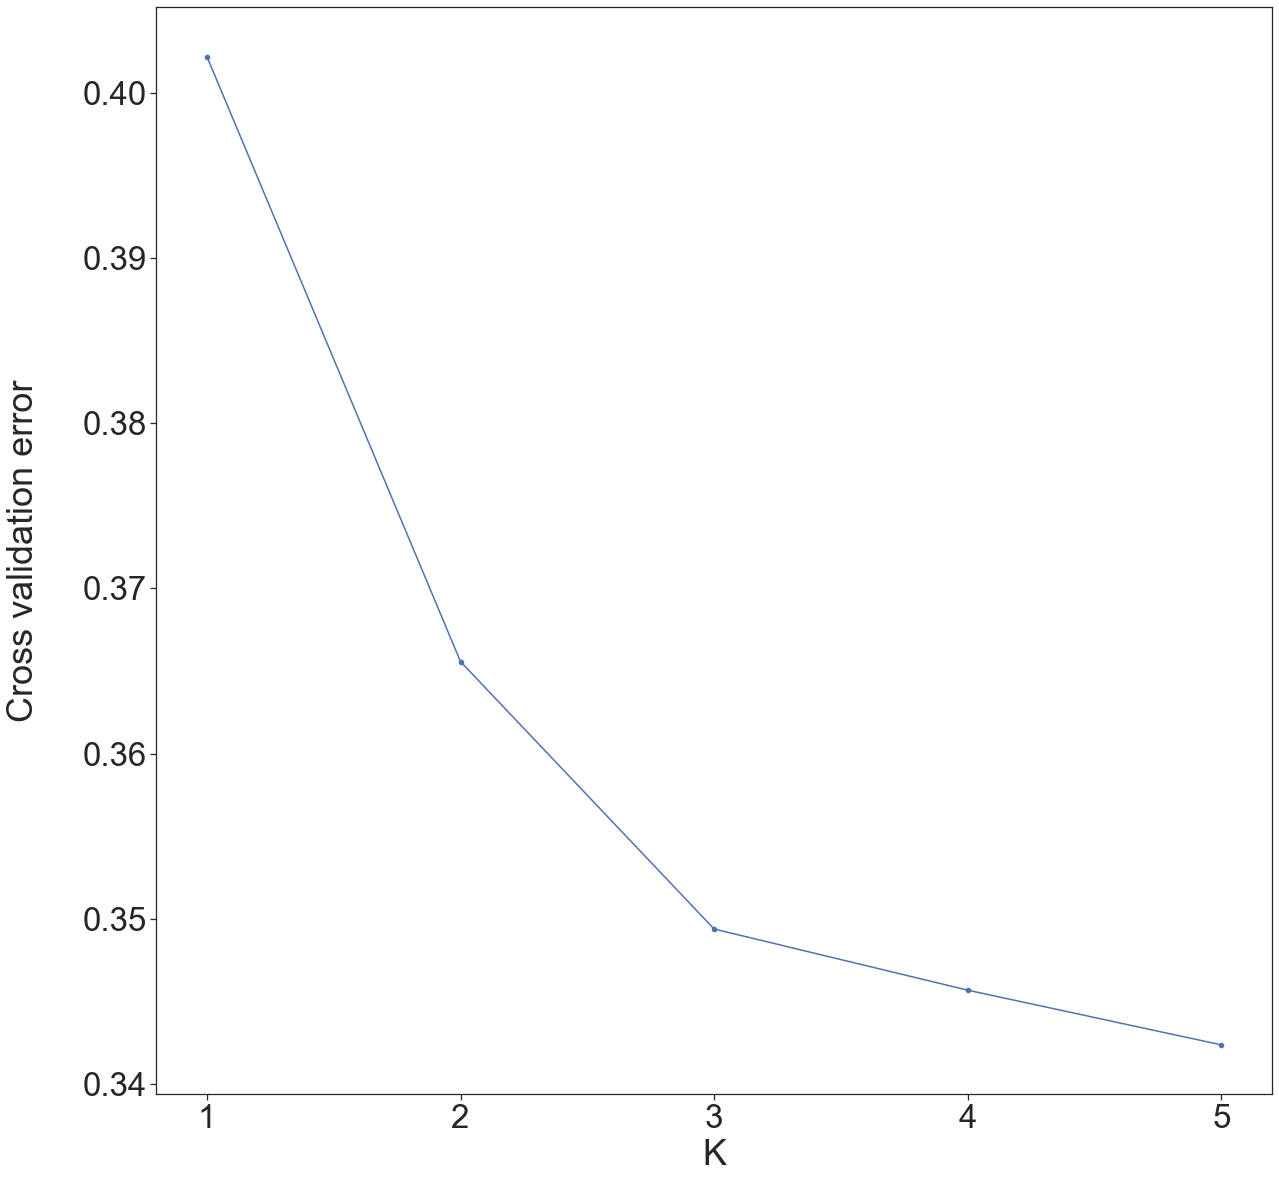

In [56]:
cv_error_unsup()

('Pearson correlation (European): ',
 (0.9998766016029708, 0.0),
 'Pearson correlation (African): ',
 (0.999876601602971, 0.0))

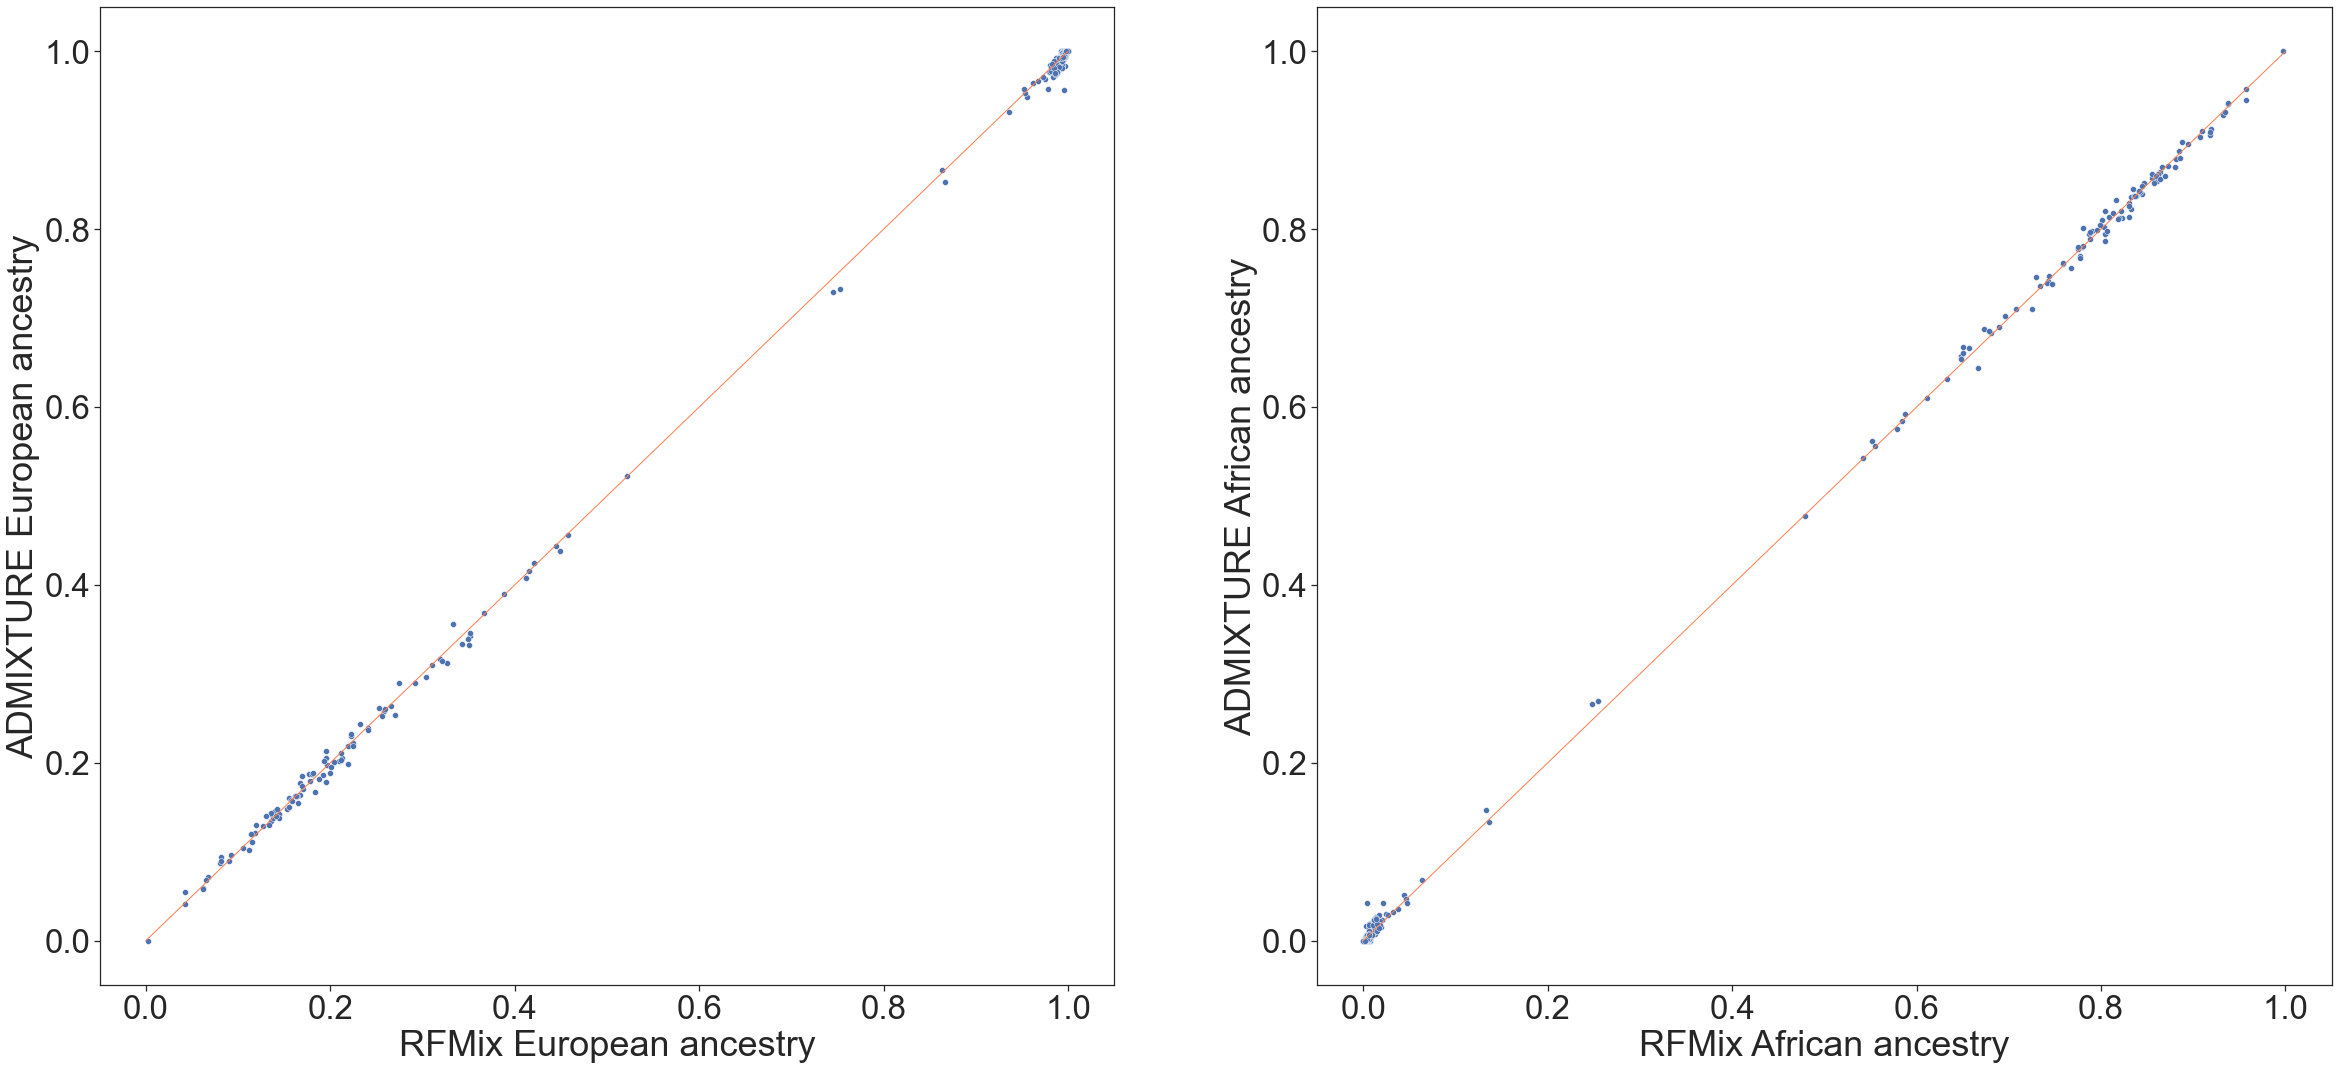

In [57]:
subplot_rfmix_admixture()

In [58]:
rfmix_admixture()

short_ID  ADMIXTURE European ancestry  ADMIXTURE African ancestry  \
0    GTEX-1117F                     0.219452                    0.780548   
1    GTEX-111CU                     0.976227                    0.023773   
2    GTEX-111FC                     0.969354                    0.030646   
3    GTEX-111VG                     0.999990                    0.000010   
4    GTEX-111YS                     0.999990                    0.000010   
..          ...                          ...                         ...   
784   GTEX-ZYVF                     0.992557                    0.007443   
785   GTEX-ZYY3                     0.993236                    0.006764   
786   GTEX-ZZ64                     0.999990                    0.000010   
787   GTEX-ZZPT                     0.999990                    0.000010   
788   GTEX-ZZPU                     0.999990                    0.000010   

     RFMix European ancestry  RFMix African ancestry  
0                   0.220470                0.779530  
1                   0.979238                0.020762  
2                   0.974794                0.025206  
3                   0.998303                0.001697  
4                   0.998379                0.001621  
..                       ...                     ...  
784                 0.993208                0.006792  
785                 0.994084                0.005916  
786                 0.999648                0.000352  
787                 0.999882                0.000118  
788                 0.998131                0.001869  

[789 rows x 5 columns]

In [59]:
# FB is Marginal probabilities.
# MSP is Most likely assignment of subpopulation.
# SIS is ???
# Q is Diploid global ancestry estimate for each chromosome.

!ls ../data/2021-05-10/rfmixout

rfmixout.1.fb.tsv   rfmixout.14.rfmix.Q rfmixout.2.fb.tsv   rfmixout.4.rfmix.Q
rfmixout.1.msp.tsv  rfmixout.14.sis.tsv rfmixout.2.msp.tsv  rfmixout.4.sis.tsv
rfmixout.1.rfmix.Q  rfmixout.15.fb.tsv  rfmixout.2.rfmix.Q  rfmixout.5.fb.tsv
rfmixout.1.sis.tsv  rfmixout.15.msp.tsv rfmixout.2.sis.tsv  rfmixout.5.msp.tsv
rfmixout.10.fb.tsv  rfmixout.15.rfmix.Q rfmixout.20.fb.tsv  rfmixout.5.rfmix.Q
rfmixout.10.msp.tsv rfmixout.15.sis.tsv rfmixout.20.msp.tsv rfmixout.5.sis.tsv
rfmixout.10.rfmix.Q rfmixout.16.fb.tsv  rfmixout.20.rfmix.Q rfmixout.6.fb.tsv
rfmixout.10.sis.tsv rfmixout.16.msp.tsv rfmixout.20.sis.tsv rfmixout.6.msp.tsv
rfmixout.11.fb.tsv  rfmixout.16.rfmix.Q rfmixout.21.fb.tsv  rfmixout.6.rfmix.Q
rfmixout.11.msp.tsv rfmixout.16.sis.tsv rfmixout.21.msp.tsv rfmixout.6.sis.tsv
rfmixout.11.rfmix.Q rfmixout.17.fb.tsv  rfmixout.21.rfmix.Q rfmixout.7.fb.tsv
rfmixout.11.sis.tsv rfmixout.17.msp.tsv rfmixout.21.sis.tsv rfmixout.7.msp.tsv
rfmixout.12.fb.tsv  rfmixout.17.rfmix.Q rfmixout.22.fb.

# Local ancestry enrichment (using hg19)
1. Get the lanc population average for each SNP (like 'lanc_popavg_PUR.sorted.nochr.bed').
    
    [Ran for all chromosomes and populations in `brubeck` instead of here]
    
    [Then appended chromosome files into one]
    
    
2. Annotate (using 'mito_annotation.sorted.nochr.bed') each SNP with gene information (resulting in 'mt_lanc_annot_PUR.bed').
    
    The columns of 'mt_lanc_annot_PUR.bed'    ("gene.chr","gene.start","gene.stop","gene.name","broad.category","narrow.category","snp.chr","snp.start","snp.stop","eur.lanc","afr.lanc","nat.lanc")
    
    [Used: `bedtools intersect -wao -a mito_annotation.sorted.nochr.bed -b mt_lanc_annot_AfAm.bed`]
      
      
3. Run the bootstrap in 'lanc_deviation_bootstrap.R'.

4. Plot the results (Rscript in Zaidi 2019 github).


In [60]:
[print("lanc_popavg_"+pop+".sorted.nochr.bed") for pop in ['EuAm','AfAm'] ]

lanc_popavg_EuAm.sorted.nochr.bed
lanc_popavg_AfAm.sorted.nochr.bed


[None, None]

In [61]:
# Export file.
#df_tpm_v8_ann_K2.to_csv("gtexportal_v8_tpm_ann_K2.mt", index=None, sep='\t')
!head gtexportal_v8_tpm_ann_K2.mt
!pwd

Gene	GTEX_ID	TPM	short_ID	self_rep_race	mtDNA_haplo	Tissue	mito_haplo	mt_ancestry	global_af	global_eu	mitonucl_discord
ND1	GTEX-1117F-0226-SM-5GZZ7	15870.0	GTEX-1117F	AfAm	L	Adipose - Subcutaneous	L	African	0.7805479999999999	0.219452	0.2194520000000001
ND2	GTEX-1117F-0226-SM-5GZZ7	9515.0	GTEX-1117F	AfAm	L	Adipose - Subcutaneous	L	African	0.7805479999999999	0.219452	0.2194520000000001
CO1	GTEX-1117F-0226-SM-5GZZ7	10790.0	GTEX-1117F	AfAm	L	Adipose - Subcutaneous	L	African	0.7805479999999999	0.219452	0.2194520000000001
CO2	GTEX-1117F-0226-SM-5GZZ7	11720.0	GTEX-1117F	AfAm	L	Adipose - Subcutaneous	L	African	0.7805479999999999	0.219452	0.2194520000000001
ATP8	GTEX-1117F-0226-SM-5GZZ7	10730.0	GTEX-1117F	AfAm	L	Adipose - Subcutaneous	L	African	0.7805479999999999	0.219452	0.2194520000000001
ATP6	GTEX-1117F-0226-SM-5GZZ7	13880.0	GTEX-1117F	AfAm	L	Adipose - Subcutaneous	L	African	0.7805479999999999	0.219452	0.2194520000000001
CO3	GTEX-1117F-0226-SM-5GZZ7	19890.0	GTEX-1117F	AfAm	L	Adipose - Subcu

In [62]:
import pandas as pd
#pd.set_option("display.max_rows", None, "display.max_columns", None)

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statistics
import statsmodels.api as sm
from itertools import permutations

import seaborn as sns; sns.set(style="ticks", color_codes=True)
#iris = sns.load_dataset("iris")
#g = sns.pairplot(iris)

from Bio import SeqIO
import sys

#%%timeit

# Get groups by which to filter subjects.
def split_afam_atmedianMND(df):
    #df_euam = df[df['self_rep_race']=='EuAm'][['short_ID','self_rep_race']].drop_duplicates()
    df_afam = df[df['self_rep_race']=='AfAm'][['short_ID','self_rep_race','mitonucl_discord']].drop_duplicates()
    # Get median MND for AfAms.
    med_mnd = df_afam['mitonucl_discord'].median()
    # Keep AfAm IDs above and below the median MND.
    upper_med = df_afam[df_afam['mitonucl_discord']>=med_mnd]#['short_ID']
    lower_med = df_afam[df_afam['mitonucl_discord']<med_mnd]#['short_ID']
    # Export to use in local ancestry enrichment.
    #upper_med.to_csv("../../lanc_enrichment_3groups/afam_upperMedianMND.ids",index=None, header=None)
    #lower_med.to_csv("../../lanc_enrichment_3groups/afam_lowerMedianMND.ids",index=None, header=None)
    # Add new annotation.
    upper_med['new_ann'] = "AfAm_highMND"
    lower_med['new_ann'] = "AfAm_lowMND"
    # Get EuAm.
    df_euam = df[df['self_rep_race']=='EuAm'][['short_ID','self_rep_race','mitonucl_discord']].drop_duplicates()
    df_euam['new_ann'] = "EuAm"
    #return(df_euam)
    # Merge into final list.
    out = pd.concat([df_euam,upper_med,lower_med])
    return(out)

# Read FB files to get physical position values, and filter by "EuAm", "AfAm_highMND", "AfAm_lowMND".
def read_fb(CHR,filt):
    fb = pd.read_table("../data/2021-05-10/rfmixout/rfmixout."+str(CHR)+".fb.tsv", skiprows=[0,0])
    # Melt the columns into rows.
    fb = pd.melt(fb, id_vars=['chromosome','physical_position','genetic_position','genetic_marker_index'], var_name='Subject_haplo', value_name='Value')
    # Split the old column headers.
    fb['Subject'] = [x.split(':')[0] for x in fb['Subject_haplo'] ]
    fb['Haplo'] = [x.split(':')[3] for x in fb['Subject_haplo'] ]
    fb['Pop'] = [x.split(':')[6] for x in fb['Subject_haplo'] ]
    fb = fb.sort_values(['physical_position','Subject_haplo'])
    # Filter subjects: "EuAm", "AfAm_highMND", "AfAm_lowMND"
    ##groups = df_tpm_v8_ann[['short_ID','self_rep_race']].drop_duplicates()
    groups = split_afam_atmedianMND(df_tpm_v8_ann_K2)[['short_ID','new_ann']].drop_duplicates()
    if filt != 'all':
        groups = groups[groups['new_ann']==filt]
    fb = fb[fb['Subject'].isin(groups['short_ID'])]
    return(fb)

# Reads MSP file, but unused here.
def read_msp(CHR):
    msp = pd.read_table("../data/2021-05-10/rfmixout/rfmixout."+str(CHR)+".msp.tsv", skiprows=[0,0])
    msp = msp.rename(columns={'#chm':'chromosome'})
    # Melt the columns into rows.
    msp = pd.melt(msp, id_vars=['chromosome','spos','epos','sgpos','egpos','n snps'], var_name='Subject_haplo', value_name='Value')
    # Split the old column headers.
    msp['Subject'] = [ x.split('.')[0] for x in msp['Subject_haplo'] ]
    msp['Haplo'] = [ {'0':'hap1','1':'hap2'}[x.split('.')[1]] for x in msp['Subject_haplo'] ]
    #msp = msp.sort_values(['physical_position','Subject_haplo'])
    return(msp)
    
# Calculate population averages of ancestry.
def lanc_popavg(CHR,filt):
    fb = read_fb(CHR,filt)
    popavg = pd.DataFrame()
    for pos in fb['physical_position'].drop_duplicates():
        fb_pos = fb[fb['physical_position']==pos]
        # Total haplotypes in the diploid dataset.
        no_haplo = fb_pos.shape[0] / 2
        # Population average at each SNP.
        yri = fb_pos[fb_pos['Pop']=='YRI']['Value'].sum() / no_haplo
        ceu = 1 - yri
        ###ceu = fb_pos[fb_pos['Pop']=='CEU']['Value'].sum() / no_haplo
        #print( "YRI:"+str(yri), "CEU:"+str(ceu), "Total:"+str(ceu+yri))
        popavg = popavg.append({'#chromosome':str(CHR),'physical_position':str(pos),'YRI':yri,'CEU':ceu},ignore_index=True)
    popavg = popavg[['#chromosome','physical_position','physical_position','YRI','CEU']]
    return(popavg)

def merge_popavg():
    merged = pd.DataFrame()
    for CHR in range(1,23):
        merged = merged.append(lanc_popavg(CHR,"all"))
    merged.to_csv("../results/2021-05/lanc_popavg.bed", index=False)
    return(merged)

def save_popavg(CHR,filt):
    out = lanc_popavg(CHR,filt)
    if filt != "all":
        out.to_csv("../results/2021-05/lanc_popavg_"+filt+"."+str(CHR)+".bed", index=False, sep="\t")
    else:
        out.to_csv("../results/2021-05/lanc_popavg."+str(CHR)+".bed", index=False, sep="\t")


# Script arguments.
#CHR = sys.argv[1]
#filt = sys.argv[2]
#save_popavg(CHR,filt)


#read_fb(22,'AfAm_highMND')
#x[x['physical_position']==16894090]
#read_msp(22,'all')#['Value'].median()
#lanc_popavg(22,"AfAm_highMND")
#merge_popavg()

In [63]:
gene_annot = pd.read_table("~/bin/github-softlink/mitonuclear_gtex/lanc_enrichment/mito_annotation.sorted.nochr.bed", header=None)
gene_annot.columns = ["gene.chr","gene.start","gene.stop","gene.name","broad.category","narrow.category"]
gene_annot

gene.chr  gene.start  gene.stop gene.name broad.category narrow.category
0            1           0    3659867      SDF4       non_mito        non_mito
1            1           0    3777574      DVL1       non_mito        non_mito
2            1           0    4991536  TNFRSF14       non_mito        non_mito
3            1           0    4949004     PANK4       non_mito        non_mito
4            1           0    3648126   TNFRSF4       non_mito        non_mito
...        ...         ...        ...       ...            ...             ...
18411        Y    22810378   27810378      DAZ4       non_mito        non_mito
18412        Y    22901542   27901542      DAZ3       non_mito        non_mito
18413        Y    22901553   27901553      DAZ2       non_mito        non_mito
18414        Y    23692768   28692768     CDY1B       non_mito        non_mito
18415        Y    23692768   28692768      CDY1       non_mito        non_mito

[18416 rows x 6 columns]

In [64]:
test = pd.read_table("~/bin/github-softlink/mitonuclear_gtex/lanc_enrichment/lanc_popavg.bed")
test = test.rename(columns={'#chromosome':'snp.chr', 'physical_position':'snp.start', 'physical_position.1':'snp.stop', 'YRI':'YRI.lanc', 'CEU':'CEU.lanc'})
test

snp.chr  snp.start  snp.stop  YRI.lanc  CEU.lanc
0             1     740857    740857  0.107941  0.892059
1             1     799463    799463  0.107941  0.892059
2             1     990417    990417  0.107941  0.892059
3             1    1018704   1018704  0.107941  0.892059
4             1    1097335   1097335  0.107941  0.892059
...         ...        ...       ...       ...       ...
135540       22   51066990  51066990  0.104954  0.895046
135541       22   51103692  51103692  0.104954  0.895046
135542       22   51134186  51134186  0.104954  0.895046
135543       22   51163138  51163138  0.104954  0.895046
135544       22   51213613  51213613  0.104954  0.895046

[135545 rows x 5 columns]

# Ancestry enrichment plots

## T-test comparison of bootstrapped distributions (African Americans)

In [65]:
def read_enrich(pop):
    df_enr = pd.read_table("/Users/edmundo/bin/github-softlink/mitonuclear_gtex/lanc_enrichment_3groups/"+pop+"_lanc_deviation_bootstrap_unweighted.txt")
    #df_enr = df_enr[df_enr['category'] == 'high']
    return(df_enr)

def quantile_values(pop,mt_categ):
    df_enr = read_enrich(pop)
    df = df_enr[df_enr['category'] == mt_categ]
    print(pop+' ('+mt_categ+')')
    for anc_pop in ['European','African']:
        print(anc_pop+
              " ancestry\nLower Quantile (0.025): ",df[anc_pop].quantile(0.025),
              "\nUpper quantile (0.975): ",df[anc_pop].quantile(0.975))

def ttest_enrich():
    df_out = pd.DataFrame()
    for pop in ['AfAm','EuAm']:
        df_enr = read_enrich(pop)
        for mt_categ in ['low','high']:
            # 'high' or 'low' for the mt category.
            df_high = df_enr[df_enr['category'] == mt_categ]
            df_nonmt = df_enr[df_enr['category'] == 'non_mito']
            # Compare non-mt to high-mt in one ancestry ('European, or 'African').
            results_afr = stats.ttest_ind(df_high['African'],df_nonmt['African'], alternative='two-sided')
            results_eu = stats.ttest_ind(df_high['European'],df_nonmt['European'], alternative='two-sided')
            joint = pd.DataFrame([results_afr, results_eu])
            joint['Comparison'] = mt_categ+'-vs-nonmt'
            joint['Ancestry'] = ['African','European']
            joint['Pop'] = pop
            df_out = df_out.append(joint)
    return(df_out)



#read_enrich('EuAm')
#quantile_values('EuAm','high')
#print(ttest_enrich_afam('AfAm','European'),ttest_enrich_afam('AfAm','African'))
ttest_enrich()

statistic         pvalue     Comparison  Ancestry   Pop
0  13.113853   9.475096e-38   low-vs-nonmt   African  AfAm
1 -13.113853   9.475096e-38   low-vs-nonmt  European  AfAm
0  12.848503   2.313423e-36  high-vs-nonmt   African  AfAm
1 -12.848503   2.313423e-36  high-vs-nonmt  European  AfAm
0 -27.497907  1.911510e-141   low-vs-nonmt   African  EuAm
1  27.497907  1.911510e-141   low-vs-nonmt  European  EuAm
0 -22.575073  1.063562e-100  high-vs-nonmt   African  EuAm
1  22.575073  1.063562e-100  high-vs-nonmt  European  EuAm

In [66]:
# Get specific quantile values of enrichment plot distributions for high-mt in EuAm.
quantile_values('EuAm','high')

EuAm (high)
European ancestry
Lower Quantile (0.025):  -1.5342717412935774e-07 
Upper quantile (0.975):  0.0007944021723122617
African ancestry
Lower Quantile (0.025):  -0.0007944021723123306 
Upper quantile (0.975):  1.5342717411653017e-07


# Males:Females in AfAm and EuAm

In [67]:
def get_sex_annot():
    df_sex = pd.read_table("/Users/edmundo/Desktop/GTEx_Secure_files/gtex_v8_sex.txt")
    # Filter a column based on two possible values.
    df_sex = df_sex[(df_sex['RACE'] == 2)|(df_sex['RACE'] == 3)]
    df_sex.columns = ['short_ID','Race','Sex','Age']
    #return(df_sex)
    # Merge the sex annotation with our dataset.
    test = pd.merge(df_sex, df_tpm_v8_ann_K2)[['short_ID','self_rep_race','Sex']].drop_duplicates()
    return([test[test['self_rep_race']==pop]['Sex'].value_counts() for pop in ['AfAm','EuAm']])


get_sex_annot()

[1    70
 2    31
 Name: Sex, dtype: int64,
 1    456
 2    232
 Name: Sex, dtype: int64]

In [68]:
get_sex_annot()

[1    70
 2    31
 Name: Sex, dtype: int64,
 1    456
 2    232
 Name: Sex, dtype: int64]

## Missing esophagus genotypes (~66).

In [69]:
esoph_ann = df_tpm_v8_ann[df_tpm_v8_ann['Tissue'] == 'Esophagus - Muscularis'][['short_ID','Tissue']].drop_duplicates()
esoph_ann_k2 = df_tpm_v8_ann_K2[df_tpm_v8_ann_K2['Tissue'] == 'Esophagus - Muscularis'][['short_ID','Tissue']].drop_duplicates()

esoph_ann_k2['matched'] = True
not_in = esoph_ann_k2.merge(esoph_ann, how='right', on=['short_ID','Tissue'])
not_in = not_in[pd.isnull(not_in['matched'])]
not_in

short_ID                  Tissue matched
433  GTEX-1122O  Esophagus - Muscularis     NaN
434  GTEX-11DXY  Esophagus - Muscularis     NaN
435  GTEX-12BJ1  Esophagus - Muscularis     NaN
436  GTEX-13O1R  Esophagus - Muscularis     NaN
437  GTEX-13PVQ  Esophagus - Muscularis     NaN
438  GTEX-145LT  Esophagus - Muscularis     NaN
439  GTEX-145LV  Esophagus - Muscularis     NaN
440  GTEX-145ME  Esophagus - Muscularis     NaN
441  GTEX-14BIN  Esophagus - Muscularis     NaN
442  GTEX-14ICL  Esophagus - Muscularis     NaN
443  GTEX-15RIE  Esophagus - Muscularis     NaN
444  GTEX-16Z82  Esophagus - Muscularis     NaN
445  GTEX-17EUY  Esophagus - Muscularis     NaN
446  GTEX-18D9B  Esophagus - Muscularis     NaN
447  GTEX-18D9U  Esophagus - Muscularis     NaN
448  GTEX-1AMEY  Esophagus - Muscularis     NaN
449  GTEX-1GN73  Esophagus - Muscularis     NaN
450  GTEX-1H11D  Esophagus - Muscularis     NaN
451  GTEX-1H1DE  Esophagus - Muscularis     NaN
452  GTEX-1H1E6  Esophagus - Muscularis     NaN
453  GTEX-1H1ZS  Esophagus - Muscularis     NaN
454  GTEX-1H23P  Esophagus - Muscularis     NaN
455  GTEX-1H2FU  Esophagus - Muscularis     NaN
456  GTEX-1H3NZ  Esophagus - Muscularis     NaN
457  GTEX-1HB9E  Esophagus - Muscularis     NaN
458  GTEX-1HBPH  Esophagus - Muscularis     NaN
459  GTEX-1HBPM  Esophagus - Muscularis     NaN
460  GTEX-1HBPN  Esophagus - Muscularis     NaN
461  GTEX-1HC8U  Esophagus - Muscularis     NaN
462  GTEX-1HCU7  Esophagus - Muscularis     NaN
463  GTEX-1HCU8  Esophagus - Muscularis     NaN
464  GTEX-1HCU9  Esophagus - Muscularis     NaN
465  GTEX-1HCUA  Esophagus - Muscularis     NaN
466  GTEX-1HCVE  Esophagus - Muscularis     NaN
467  GTEX-1HFI6  Esophagus - Muscularis     NaN
468  GTEX-1HFI7  Esophagus - Muscularis     NaN
469  GTEX-1HKZK  Esophagus - Muscularis     NaN
470  GTEX-1HSGN  Esophagus - Muscularis     NaN
471  GTEX-1HSKV  Esophagus - Muscularis     NaN
472  GTEX-1HSMQ  Esophagus - Muscularis     NaN
473  GTEX-1HT8W  Esophagus - Muscularis     NaN
474  GTEX-1I1GP  Esophagus - Muscularis     NaN
475  GTEX-1I1GR  Esophagus - Muscularis     NaN
476  GTEX-1I1GT  Esophagus - Muscularis     NaN
477  GTEX-1I1GV  Esophagus - Muscularis     NaN
478  GTEX-1IDJC  Esophagus - Muscularis     NaN
479  GTEX-1IDJH  Esophagus - Muscularis     NaN
480  GTEX-1IDJU  Esophagus - Muscularis     NaN
481  GTEX-1IKOE  Esophagus - Muscularis     NaN
482  GTEX-1J1OQ  Esophagus - Muscularis     NaN
483  GTEX-1J1R8  Esophagus - Muscularis     NaN
484  GTEX-1J8EW  Esophagus - Muscularis     NaN
485  GTEX-1J8Q3  Esophagus - Muscularis     NaN
486  GTEX-1J8QM  Esophagus - Muscularis     NaN
487  GTEX-1JK1U  Esophagus - Muscularis     NaN
488  GTEX-1MGNQ  Esophagus - Muscularis     NaN
489   GTEX-QLQW  Esophagus - Muscularis     NaN
490   GTEX-R55D  Esophagus - Muscularis     NaN
491   GTEX-RNOR  Esophagus - Muscularis     NaN
492   GTEX-WHPG  Esophagus - Muscularis     NaN
493   GTEX-X15G  Esophagus - Muscularis     NaN
494   GTEX-XQ8I  Esophagus - Muscularis     NaN
495   GTEX-XYKS  Esophagus - Muscularis     NaN
496   GTEX-YB5E  Esophagus - Muscularis     NaN
497   GTEX-YFCO  Esophagus - Muscularis     NaN
498   GTEX-ZF29  Esophagus - Muscularis     NaN

# Remake the global ancestry, mitohaplo merge.

In [156]:
# Input mt haplogroup info for GTEx samples.
def get_haplo():
    df_haplo = pd.read_table("/Users/edmundo/Documents/GitHub/mitonuclear_gtex/mitonucl/data/2021-04-09/ids_aa_ea_GTEx_v8.haplo", header=None)
    df_haplo.columns = ['short_ID','mt_haplo','pop']
    df_haplo['pop'] = [{3:'EuAm',2:'AfAm'}[x] for x in df_haplo['pop']]
    df_haplo['mt_haplo_pop'] = [ {'L':'African','H':'Eurasian','U':'Eurasian','T':'Eurasian','J':'Eurasian',
                                  'K':'Eurasian','I':'Eurasian','V':'Eurasian','W':'Eurasian','X':'Eurasian',
                                  'C':'Native American','B':'Native American','A':'Native American',
                                  'Z':'Asian','F':'Asian','R':'Eurasian?','M':'Eurasian?','N':'Eurasian?'}[x] for x in df_haplo['mt_haplo']]
    return(df_haplo)

# Input qlobal ancestry estimated for K=2 using ADMIXTURE.
def get_global():
    df_ids = pd.read_table("/Users/edmundo/Documents/GitHub/mitonuclear_gtex/mitonucl/data/2021-04-09/NATMERG-WGS-ALL_biall_nopal_filt_common_pruned_keep2.ids", header=None)
    df_ids.columns = ['short_ID']
    df_ids = df_ids.reset_index()
    #return(df_ids)
    df_Q = pd.read_table("/Users/edmundo/Documents/GitHub/mitonuclear_gtex/mitonucl/data/2021-04-09/NATMERG-WGS-ALL_biall_nopal_filt_common_pruned_keep2.2.Q", header=None, sep=' ')
    df_Q.columns = ['anc_afr','anc_eur']
    df_Q = df_Q.reset_index()
    #return(df_Q)
    df_glob = pd.merge(df_ids,df_Q, on='index').drop(columns=['index'])
    return(df_glob)
    
# Compute mitonuclear DNA discordance.
def recalc_mnd(ann):
    col_mnd=[]
    for i,val in enumerate(ann['mt_haplo_pop']):
        # Estimate mitonuclear discordance.
        if val == 'African':
            mnd = 1 - ann['anc_afr'].iloc[i]
        elif val == 'Eurasian':
            mnd = 1 - ann['anc_eur'].iloc[i]
        elif val != 'African' or val != 'Eurasian':
            mnd = "Unknown"
        # Output the MND value.
        col_mnd.append(mnd)
    return(col_mnd)

# Merge these annotations into one file.
def join_global_haplo():
    df_ann = pd.merge( get_global() , get_haplo() ,on='short_ID')
    #return(df_ann)
    df_ann['mnd'] = recalc_mnd(df_ann)
    return(df_ann)


### Input the GTEx TPM file. ###
# Do not use. Old and missing haplogroups.
###df_tpm = pd.read_table('../results/2021-04/gtexportal_v8_tpm_ann.mt', sep='\t')[['Gene','GTEX_ID','TPM','short_ID','Tissue']]

# Very intensive step:
#df_tpm = pd.read_table("../data/viaGTExPortal/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct", skiprows=[0,1])
#df_tpm.to_csv("gtexportal_v8_tpm_ann.mt.tab", sep='\t')
df_tpm = pd.read_table("gtexportal_v8_tpm_ann.mt.tab", sep='\t')

# Wrangle the GTEx Portal v8 "gene TPMs" file.
def wrangle_tpm( counts ):
    # Keep mtDNA protein coding genes.
    # The list of mtDNA protein-coding genes.
    list_mtdna = [ 'MT-ND1','MT-ND2','MT-CO1','MT-CO2','MT-ATP8','MT-ATP6','MT-CO3','MT-ND3','MT-ND4L','MT-ND4','MT-CYB','MT-ND5','MT-ND6' ]
    counts_mt = counts[counts['Description'].isin(list_mtdna)]  
    # Move individual IDs into rows.
    counts_mt = counts_mt.melt(id_vars=['Name','Description'], var_name='GTEX_ID', value_name='TPM')
    # Change header names.
    counts_mt = counts_mt.rename(columns={'Name':'ENS_ID','Description':'Gene'})
    # Get rid of the Ensemble gene IDs.
    counts_mt.drop('ENS_ID', inplace=True, axis=1)
    # 
    counts_mt['short_ID'] = ["-".join(x.split('-')[:2]) for x in df_wrangled['GTEX_ID']]
    return(counts_mt)

# Remove the gene ID prefix "MT-".
def remove_mt_prefix(df):
    dict_mtdna = {'MT-ND1':'ND1','MT-ND2':'ND2','MT-CO1':'CO1','MT-CO2':'CO2','MT-ATP8':'ATP8','MT-ATP6':'ATP6','MT-CO3':'CO3','MT-ND3':'ND3','MT-ND4L':'ND4L','MT-ND4':'ND4','MT-ND5':'ND5','MT-CYB':'CYB','MT-ND6':'ND6'}
    new_col = [dict_mtdna[gene] for gene in df['Gene']]
    return(new_col)

# Join the TPM and annotations of global ancestry, mt haplogroup, and mitonuclear discordance.
def join_tpm_ann(counts):
    # Global anc and mt haplogroup annotations.
    df_ann = join_global_haplo()
    # Add the info to the merged raw counts.
    ann_counts = pd.merge( wrangle_tpm(counts), df_ann )
    # Remove "MT-" prefix.
    ann_counts['Gene'] = remove_mt_prefix(ann_counts)
    return(ann_counts)


#get_haplo()
#get_global()
#join_global_haplo()
#df_tpm_ann = join_tpm_ann()
#df_tpm_ann['Gene'] = remove_mt_prefix(df_tpm_ann)
#df_wrangled = wrangle_tpm(df_tpm)
df_tpm_ann = join_tpm_ann(df_tpm)

KeyboardInterrupt: 

In [ ]:
#df_tpm.to_csv("gtexportal_v8_tpm_ann.mt.tab", sep='\t')

In [ ]:
# Mito haplogroups.
join_global_haplo()['mt_haplo_pop'].value_counts()

In [ ]:
# Number of individuals.
join_global_haplo()['pop'].value_counts()

In [ ]:
# Individuals with a Non-European or Non-African mito haplogroup.
join_global_haplo()[join_global_haplo()['mnd'] == 'Unknown'].sort_values(['mt_haplo'])#.shape[0]

In [ ]:
# 18 of the missing 66 esophagus samples.
pd.merge(not_in,join_global_haplo()).sort_values(['mt_haplo'])#.shape[0]

# How to reincorporate these into the other analyses?

## - Exclude A,B,C (Native American), and F,Z (Central and SE Asia only).

## - Include M,N,R (Eurasian).

In [ ]:
# Very intensive step:
#df_tpm = pd.read_table("../data/viaGTExPortal/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct", skiprows=[0,1])
    
def wrangle_tpm( counts ):
    # Keep mtDNA protein coding genes.
    # The list of mtDNA protein-coding genes.
    list_mtdna = [ 'MT-ND1','MT-ND2','MT-CO1','MT-CO2','MT-ATP8','MT-ATP6','MT-CO3','MT-ND3','MT-ND4L','MT-ND4','MT-CYB','MT-ND5','MT-ND6' ]
    counts_mt = counts[counts['Description'].isin(list_mtdna)]  
    # Move individual IDs into rows.
    counts_mt = counts_mt.melt(id_vars=['Name','Description'], var_name='GTEX_ID', value_name='TPM')
    # Change header names.
    counts_mt = counts_mt.rename(columns={'Name':'ENS_ID','Description':'Gene'})
    # Get rid of the Ensemble gene IDs.
    counts_mt.drop('ENS_ID', inplace=True, axis=1)
    # 
    counts_mt['short_ID'] = ["-".join(x.split('-')[:2]) for x in df_wrangled['GTEX_ID']]
    return(counts_mt)

def ann_tpm(counts):
    # Global anc and mt haplogroup annotations.
    df_ann = join_global_haplo()
    # Add the info to the merged raw counts.
    ann_counts = pd.merge( wrangle_tpm(counts), df_ann )
    return(ann_counts)

#df_wrangled = wrangle_tpm(df_tpm)
df_tpm_ann = ann_tpm(df_tpm)

In [ ]:
df_tpm

In [ ]:
df_wrangled

In [ ]:
df_tpm_ann

# Resample genes across the nuclear genome for direction of effect in EuAm and AfAm.

In [ ]:
df_tpm_v8_ann